In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
import ast
from termcolor import colored
import string
from nltk.tokenize import word_tokenize 
import string
from tqdm import trange

sns.set_style('darkgrid')

# For my jupyter theme
%config InlineBackend.print_figure_kwargs = {'facecolor':'white'}

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# torch.cuda.current_device(), torch.cuda.get_device_name(0)

if torch.cuda.is_available():  
    dev = 'cuda:0' 
else:  
    dev = 'cpu'
#dev = 'cpu'

## Resumen:

1. Quitando símbolos tóxicos (", espacios, !, etc) tenemos los siguientes resultados:
  - LSTM: *train*=0.6386, *test*=0.5886 `(EMBEDDING_DIM = 20, HIDDEN_DIM = 20, EPOCHS = 25)`
2. Quitando símbolos tóxicos (", espacios, !, etc) y agregando como completamente tóxicos todos los que no tienen índices (los que viene como [ ]):
  - LSTM: *train*=0.6386, *test*=0.5886 `(EMBEDDING_DIM = 20, HIDDEN_DIM = 20, EPOCHS = 25)`
  
3. Sin quitar símbolos tóxicos (", espacios, !, etc), es decir, dataset original:
  - LSTM: *train*=0.570, *test*=0.531 `(EMBEDDING_DIM = 20, HIDDEN_DIM = 20, EPOCHS = 25)`
  
4. Sin quitar símbolos tóxicos (", espacios, !, etc) y agregando como completamente tóxicos todos los que no tienen índices (los que viene como [ ]):
  - LSTM: *train*=0.570, *test*=0.531 `(EMBEDDING_DIM = 20, HIDDEN_DIM = 20, EPOCHS = 25)`
  
Para la LSTM lo mejor parece ser la opción 1. Lo mejor hasta ahora es con `(EMBEDDING_DIM = 20 HIDDEN_DIM = 20 EPOCHS = 25)` (test=0.581, aunque no se fijó la semilla y no se puede reproducir).

## Preprocesamiento

In [3]:
from utils import (color_toxic_words, remove_symbols, completely_toxic, separate_words, 
                   get_index_toxic_words, f1)

In [4]:
train = pd.read_csv('Datos/tsd_train.csv', converters={'spans':ast.literal_eval})
test = pd.read_csv('Datos/tsd_trial.csv', converters={'spans':ast.literal_eval})

In [5]:
train['spans_clean'] = train['spans']
test['spans_clean'] = test['spans']

In [6]:
# Pondremos los que tienen [ ] como completamente tóxicos para ver qué sale.

clean_spans = [completely_toxic(span, text) for (span, text) in zip(train['spans'], train['text'])]
train['spans_clean'] = clean_spans

clean_spans = [completely_toxic(span, text) for (span, text) in zip(test['spans'], test['text'])]
test['spans_clean'] = clean_spans

In [7]:
# Quitamos símbolos

indices_clean = [remove_symbols(index, text) for index,text in zip(train['spans'], train['text'])]
train['spans_clean'] = indices_clean

indices_clean = [remove_symbols(index, text) for index,text in zip(test['spans'], test['text'])]
test['spans_clean'] = indices_clean

In [8]:
# Pasamos a minúscula
train['text'] = train['text'].apply(lambda x:x.lower())

# Pasamos a minúscula
test['text'] = test['text'].apply(lambda x:x.lower())

## Cargar embeddings

In [9]:
from torchtext.data import Field


text_field = Field(
    tokenize='basic_english', 
    lower=True
)
label_field = Field(sequential=False, use_vocab=False)
# sadly have to apply preprocess manually
preprocessed_text = train['text'].apply(lambda x: text_field.preprocess(x))
# load fastext simple embedding with 300d
text_field.build_vocab(
    preprocessed_text, 
    vectors='glove.twitter.27B.200d'
)
# get the vocab instance
vocab = text_field.vocab

/home/mario/anaconda3/lib/python3.8/site-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [10]:
vocab.lookup_indices(['another', 'violent', 'and', 'aggressive', 'immigrant', 'killing', 'a', 'innocent', 'and', 'intelligent', 'us', 'citizen', '....', 'sarcasm'])


[126, 1322, 6, 3243, 2117, 412, 7, 796, 6, 1014, 85, 1085, 0, 3944]

from torchtext.vocab import GloVe
embedding_glove = GloVe(name='6B', dim=100)

In [11]:
train['spans_clean'][0]

[8,
 9,
 10,
 11,
 12,
 13,
 14,
 16,
 17,
 18,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39]

In [12]:
train.iloc[0]

spans          [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,...
text           another violent and aggressive immigrant killi...
spans_clean    [8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 20, 21,...
Name: 0, dtype: object

## LSTM

In [13]:
train_data = []
for index, text in zip(train['spans_clean'], train['text']):
    toxic_words = [text[i[0]:i[-1]+1] for i in separate_words(index) if len(index) > 0]
#     print(toxic_words)
    
    tokens = word_tokenize(text)
    tagged_tokens = []
    
    for token in tokens:
        if token in toxic_words:
            tagged_tokens.append('toxic')
            # Removemos en caso de que se repita posteriormente pero esté como 'non_toxic'
            toxic_words.remove(token) 
        else:
            tagged_tokens.append('non_toxic')
            
    train_data.append((tokens, tagged_tokens, text, index))

In [14]:
test_data = []
for index, text in zip(test['spans'], test['text']):
    toxic_words = [text[i[0]:i[-1]+1] for i in separate_words(index) if len(index) > 0]
#     print(toxic_words)
    
    tokens = word_tokenize(text)
    tagged_tokens = []
    
    for token in tokens:
        if token in toxic_words:
            tagged_tokens.append('toxic')
            # Removemos en caso de que se repita posteriormente pero esté como 'non_toxic'
            toxic_words.remove(token) 
        else:
            tagged_tokens.append('non_toxic')
            
    test_data.append((tokens, tagged_tokens, text, index))

In [15]:
def prepare_sequence(seq):
    idxs = vocab.lookup_indices(seq)      # Si no está que lo ponga como 'UNK'
    return torch.tensor(idxs, dtype=torch.long, device=dev)
def prepare_sequence_tags(seq):
    tag_to_ix = {"non_toxic": 0, "toxic": 1} 
    idxs = [tag_to_ix[s] for s in seq]
    return torch.tensor(idxs, dtype=torch.long, device=dev)

In [16]:
from torch.utils.data import Dataset, DataLoader


class SpansDataset(Dataset):
    """Spans dataset."""

    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        text = prepare_sequence(self.data[idx][0])
        spans = prepare_sequence_tags(self.data[idx][1])
        sample = {'tokenized' : self.data[idx][0], 'original_text' : self.data[idx][2], 'text': text, 'spans': spans, 'true_index' : self.data[idx][3]}

        return sample

In [17]:
train_size = len(train_data)
test_size = len(test_data)

train_ds = SpansDataset(train_data)
test_ds = SpansDataset(test_data)

trainloader = DataLoader(train_ds, batch_size=1, shuffle=True)#Having bigger batches WILL make training faster
#However big batches are more difficult in RNNs in general due to variable sequence size, they need padding.
#Test is dev in reality
testloader = DataLoader(test_ds, batch_size=1, shuffle=True)

In [18]:
"""
word_to_ix = {'UNK': 0}

for sent, tags in train_data:
    for word in sent:
        if word not in word_to_ix:              # word has not been assigned an index yet
            word_to_ix[word] = len(word_to_ix)  # Assign each word with a unique index
"""            
tag_to_ix = {"non_toxic": 0, "toxic": 1}        # Assign each tag with a unique index

In [19]:
from torch import autograd
"""
try2
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, weight, hidden_dim, vocab_size, tagset_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim
        
        # Usar otro embedding, tratar con alguno que haya en 'transformers'
        self.word_embeddings = nn.Embedding.from_pretrained(weight)
        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers = 2, dropout=0.05, bidirectional=True)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores
"""
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, stacked_layers, dropout_p, weight, hidden_dim, vocab_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim#Dimension del estado oculta en cada direccion de la LSTM
        self.stacked_layers = stacked_layers#Cuantas capas en la LSTM
        
        self.word_embeddings = nn.Embedding.from_pretrained(weight)
        self.lstm = nn.LSTM(embedding_dim,
                            hidden_dim,
                            num_layers = stacked_layers,
                            dropout = dropout_p,
                            bidirectional = True)

        # Linear layers
        self.fc1 = nn.Linear(hidden_dim*2, 1)#2 veces el tamaño de hidden_dim por ser bidireccional

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        output, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        x = torch.sigmoid(self.fc1(output.view(len(sentence), -1)))
        return x

In [20]:
def postprocessing(indices_list):
    delta = 7
    #Asumiendo que tienes indices numéricos enteros.
    if len(indices_list) > 1:
        l = sorted(indices_list)
        new_list = []
        for i in range(len(indices_list)-1):
            #Agrego el indice existente
            new_list.append(l[i])
            #Si no hay mucho espacio entre este y el siguiente indice, selecciono todos los indices intermedios
            if (l[i+1] - l[i]) <= delta:
                new_list = new_list + list(range(l[i]+1,l[i+1]))
        new_list.append(l[-1])#El ultimo elemento
        return new_list
    else:
        return indices_list

In [21]:
postprocessing([61,62,63,71,72,74,200])#No rellena

[61, 62, 63, 71, 72, 73, 74, 200]

In [22]:
postprocessing([61,62,63,70,71,72,74,200])#Rellena

[61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 200]

In [34]:
def tagger_LSTM(text):
    ix_to_tag = {0: 'non_toxic', 1: 'toxic'}
    words = word_tokenize(text.lower())
    
    with torch.no_grad():
        inputs = prepare_sequence(words)
        tag_scores = model(inputs)
        
        tags = [1 if x > 0.5 else 0 for x in tag_scores]

        tagged_sentence = list(zip(words, tags))

    return tagged_sentence

def get_index_toxic_words(sentence, tagged_sentence):
    toxic_indices = []   
    m = 0
    #tag_to_ix = {"non_toxic": 0, "toxic": 1}
    for word_tag in tagged_sentence:
        word, tag = word_tag    
        if tag == 1:#toxic
            # Si la palabra tóxica aparece 2 o más veces ésto solo dará la primera 
            # aparición, hay que arreglar eso pero por lo mientras sirve
            # word_indices = [sentence.find(word) + i for i in range(len(word))]
            # toxic_indices.append(word_indices)
            
            # Así parece evitar el problema de la palabra repetida
            word_indices = [m + sentence[m:].find(word) + i for i in range(len(word))]
            toxic_indices.append(word_indices)
            m += sentence[m:].find(word) + len(word) + 1
            
    toxic_indices = [val for sublist in toxic_indices for val in sublist]
    #Unir espacios y otras cosas para que suba el F1    
    return postprocessing(toxic_indices)


def f1(predictions, gold):
    """
    F1 (a.k.a. DICE) operating on two lists of offsets (e.g., character).
    >>> assert f1([0, 1, 4, 5], [0, 1, 6]) == 0.5714285714285714
    :param predictions: a list of predicted offsets
    :param gold: a list of offsets serving as the ground truth
    :return: a score between 0 and 1
    """
    if len(gold) == 0:
        return 1. if len(predictions) == 0 else 0.
    if len(predictions) == 0:
        return 0.
    predictions_set = set(predictions)
    gold_set = set(gold)
    nom = 2 * len(predictions_set.intersection(gold_set))
    denom = len(predictions_set) + len(gold_set)
    return float(nom)/float(denom)

def f1_scores(pred, true_index, tokenized, text):
    scores_LSTM = 0
    for i in range(len(pred)):
        tags = [1 if x > 0.5 else 0 for x in pred[i]]
        tagged_sentence = list(zip(tokenized[i], tags))
        prediction_index = get_index_toxic_words(text[i], tagged_sentence)
        scores_LSTM += f1(prediction_index, true_index[i])
    return scores_LSTM/len(pred)

def plot_loss_and_score(train_loss, test_loss, f1_scores_train, f1_scores_test, show=True):
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(18,7))

    ax0.plot(np.arange(1, len(train_loss) + 1), train_loss, marker='o', label='train_loss')
    ax0.plot(np.arange(1, len(test_loss) + 1), test_loss, marker='o', label='validation loss')
    ax0.set_xlabel('Epochs')
    ax0.set_ylabel('Loss')
    ax0.legend()

    ax1.plot(np.arange(1, len(f1_scores_train) + 1), f1_scores_train, 
             marker='o', label='f1 score in train')
    ax1.plot(np.arange(1, len(f1_scores_test) + 1), f1_scores_test, 
             marker='o', label='f1 score in test')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('F1 score')
    ax1.legend()

    if show:
        plt.show()

In [24]:
"""#0.61 en dev loss
HIDDEN_DIM = 250
embedding_dim = len(vocab.vectors[0])
model = LSTMTagger(embedding_dim, vocab.vectors, HIDDEN_DIM, len(vocab.vectors), len(tag_to_ix))
model.to(torch.device(dev))
"""
"""
#try3 #0.65 en dev loss, acercandose
HIDDEN_DIM = 600
embedding_dim = len(vocab.vectors[0])
model = LSTMTagger(embedding_dim, 6, 0.15, vocab.vectors, HIDDEN_DIM, len(vocab.vectors), len(tag_to_ix))
model.to(torch.device(dev))
"""
#try4
HIDDEN_DIM = 600
embedding_dim = len(vocab.vectors[0])
model = LSTMTagger(embedding_dim, 6, 0.2, vocab.vectors, HIDDEN_DIM, len(vocab.vectors))
model.to(torch.device(dev))

LSTMTagger(
  (word_embeddings): Embedding(20566, 200)
  (lstm): LSTM(200, 600, num_layers=6, dropout=0.2, bidirectional=True)
  (fc1): Linear(in_features=1200, out_features=1, bias=True)
)

In [26]:
model = torch.load('best-model-try4.pt').to(torch.device(dev))

In [25]:
import torch.optim as optim

criterion = nn.BCELoss()
#optimizer = optim.SGD(model.parameters(), momentum = 0.85, lr=0.0005)
optimizer = optim.Adam(model.parameters())

In [25]:
loss_per_epoch = [0]
training_loss = [0]
f1_scores_train = [0]
f1_scores_dev = [0]
stop_after_best = 100
best_l = None
best_tl = None
worst_l = None
worst_tl = None
worst_l_f1 = None
best_l_f1 = None
worst_tl_f1 = None
last_epoch_save = 0

Training on: GeForce GTX 1080
###############################################
Current epoch: 15
Last model save was in epoch 4
Stopping training in: 90 epochs.
###############################################
[Best iter] training F1 is: 0.622636438420319
[Best iter] dev F1 is: 0.6399204001357657
###############################################
[Last iter] training F1 was: 0.7143720946328628
[Last iter] dev. F1 was: 0.5053416346299253
###############################################


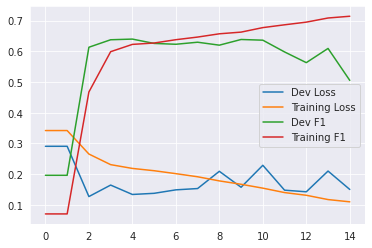

Sentence 0 done.
Sentence 1000 done.


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display

stop_after_best = 100
#Nombre del archivo de backup
savefile = 'best-model-try4.pt'

epochs_without_change = 0
epochs = len(loss_per_epoch)

while epochs_without_change < stop_after_best:  # itero hasta que no mejore el desempeño en dev por 100 épocas
    display.clear_output(wait=True)
    print("Training on: " + torch.cuda.get_device_name(torch.cuda.current_device()))
    print("###############################################")
    print("Current epoch: " + str(epochs))
    print("Last model save was in epoch " + str(last_epoch_save))
    print("Stopping training in: " + str(stop_after_best - epochs_without_change) + " epochs.")
    print("###############################################")
    print("[Best iter] training F1 is: " + str(best_tl))
    print("[Best iter] dev F1 is: " + str(best_l))
    print("###############################################")
    print("[Last iter] training F1 was: " + str(f1_scores_train[-1]))
    print("[Last iter] dev. F1 was: " + str(f1_scores_dev[-1]))
    print("###############################################")
    #Dibujo lo que puedo
    plt.plot(range(epochs), loss_per_epoch)
    plt.plot(range(epochs), training_loss)
    plt.plot(range(epochs), f1_scores_dev)
    plt.plot(range(epochs), f1_scores_train)
    plt.legend(["Dev Loss", "Training Loss", "Dev F1", "Training F1"])
    plt.show()
    tl = 0
    t_pred_l = []
    t_true_index_l = []
    t_tokenized_l = []
    t_text_l = []
    for i, v in enumerate(trainloader): #Not using batches yet
        text = torch.reshape(v['text'], (-1,))
        tags = torch.reshape(v['spans'], (-1,))
        optimizer.zero_grad()
        tag_scores = model(text)
        
        #Para la F1
        t_pred_l.append(tag_scores.cpu().detach().numpy())
        t_true_index_l.append([a.cpu().detach().numpy()[0] for a in v['true_index']])
        t_tokenized_l.append([a[0] for a in v['tokenized']])
        t_text_l.append(v['original_text'][0])
        
        loss = criterion(torch.reshape(tag_scores, (-1,)), torch.reshape(tags, (-1,)).float())
        tl += loss.item()
        loss.backward()
        optimizer.step()
        if i % 1000 == 0:
            print("Sentence {} done.".format(i))
    tl /= len(trainloader)
    l = 0
    print("Starting evaluation for loss function.")
    #evaluar el modelo
    pred_l = []
    true_index_l = []
    tokenized_l = []
    text_l = []
    
    model.eval()
    with torch.no_grad():
        for v in testloader:
            text = torch.reshape(v['text'], (-1,))
            tags = torch.reshape(v['spans'], (-1,))

            tag_scores = model(text)
            
            #Para la F1
            pred_l.append(tag_scores.cpu().detach().numpy())
            true_index_l.append([a.cpu().detach().numpy()[0] for a in v['true_index']])
            tokenized_l.append([a[0] for a in v['tokenized']])
            text_l.append(v['original_text'][0])
            
            loss = criterion(torch.reshape(tag_scores, (-1,)), torch.reshape(tags, (-1,)).float())
            l += loss.item()
    model.train()
    l /= len(testloader)
    print("Starting evaluation for dev F1")
    f1_d = f1_scores(pred_l, true_index_l, tokenized_l, text_l)
    f1_t = f1_scores(t_pred_l, t_true_index_l, t_tokenized_l, t_text_l) #Es aproximado, pero solo es una referencia
    
    epochs_without_change += 1
    if best_l is None or best_l < f1_d:
        print("Model improved, saving.")
        torch.save(model, savefile)
        best_l = f1_d
        best_tl = f1_t
        epochs_without_change = 0
        last_epoch_save = epochs
        print("Model improved, saved.")
    #Para graficar con una escala coherente.
    if(worst_l_f1 is None or f1_d < worst_l_f1):
        worst_l_f1 = f1_d
        f1_scores_dev[0] = worst_l_f1
    if(worst_tl_f1 is None or f1_t < worst_tl_f1):
        worst_tl_f1 = f1_t
        f1_scores_train[0] = worst_tl_f1
    if(worst_tl is None or tl > worst_tl):
        worst_tl = tl
        training_loss[0] = worst_tl
    if(worst_l is None or l > worst_l):
        worst_l = l
        loss_per_epoch[0] = worst_l
    #Rastreo las perdidas
    loss_per_epoch.append(l)
    training_loss.append(tl)
    f1_scores_train.append(f1_t)
    f1_scores_dev.append(f1_d)
    #Rastreo la época actual
    epochs += 1
print('Finished Training')

In [ ]:
plot_loss_and_score(train_loss, test_loss, f1_scores_train, f1_scores_test, show=False)
plt.title('train-f1: {:.4f} \n test-f1: {:.4f}'.format(np.max(f1_scores_train), np.max(f1_scores_test)))
plt.savefig('Images/preprocesamiento-4.png', bbox_inches='tight')
plt.show()

## Evaluación

In [27]:
#model = torch.load(savefile)
model.eval()

LSTMTagger(
  (word_embeddings): Embedding(20566, 200)
  (lstm): LSTM(200, 600, num_layers=6, dropout=0.2, bidirectional=True)
  (fc1): Linear(in_features=1200, out_features=1, bias=True)
)

In [28]:
evaluation = pd.read_csv('Datos/tsd_test.csv')
evaluation.head()

,text
0,That's right. They are not normal. And I am st...
1,"""Watch people die from taking away their healt..."
2,tens years ago i contacted the PDR and suggest...
3,The parallels between the ANC and the Sicilian...
4,Intel Community: ‘How can we work for a Presid...


In [41]:
indices_evaluation = []
for i,text in enumerate(evaluation['text']):
    tagged_sentence = tagger_LSTM(text)   
    prediction_index = get_index_toxic_words(text.lower(), tagged_sentence)
    indices_evaluation.append(prediction_index)
    print(str(i) + colored(' Pred: ', color='cyan', attrs=['bold']) + 
           color_toxic_words(prediction_index, text)) 

0 Pred: That's right. They are not normal. And I am starting from the premise that they are ABNORMAL. Proceed wth the typical racist, bigot, sexist rubbish.
Thanks!
1 Pred: "Watch people die from taking away their healthcare"

DING DING DING!  Winner of stupid post of the day award!
2 Pred: tens years ago i contacted the PDR and suggested that the time might be good to work with alaska on building a gas line.. alaska rejected them without even consideration despite china being flush with cash and hungry for gas.. and set up another infamous boondoggle.. the transcanada-exxon rip off that we are still paying for and have yet to receive anything of value.. hundreds of millions of dollars on studies.. and buyouts.. i hope china says f you alaska.. you are nothing but ignorant people..
3 Pred: The parallels between the ANC and the Sicilian Mafia are glaring. The ANC has always been run by a few "families" who treat the state as 'turf' ; as just one big piggy bank for their self-enrichment.

7 Pred: A rock has more mental horsepower than the indubitably ignorant. And more integrity as well. They're largely very dishonest people who repeat the same lies over and over. Just like their 🍊 hero.
8 Pred: Ha ha, HILLARY LOST. All you hillary fools need to be rounded up and put in prison along with your leader. You are all anti--American scum. Perhaps we should dump you in Mexico along with all the illegal trash you let in....if you love 'em so much, go live with 'em. But you are not welcome here, you hate filled Marxist morons.
9 Pred: Yes....it is to be expected....oddly enough it happens every time he opens his mouth and says dumb things.
10 Pred: See a shrink you pathetic troll.
11 Pred: Trump troll...
12 Pred: ADN is endorsing, without officially endorsing.  Bunch of cowards!!!
13 Pred: What exactly is suspicious about it? Taking the advice of the entire democrat party? Partisan politics is our reality. It's not my fault democrats complain when they get what they called for. 

18 Pred: A fool and our money are soon to be parted.
19 Pred: Chris Birch is a mean, self-centered, contrary ass. He repeatedly interrupted Robin Brena during his presentation and always, always sucks up to Big Oil. He could care less about his constituents and the rest of Alaska. He needs to get gone. What has he done for you, South Anchorage? Sarcastic is the perfect adjective for Chris Birch!
20 Pred: I always knew you were a dirty cop.
21 Pred: Idiot "miner" in the photo isn't even wearing a dust mask. MSHA needs to inspect this operation for more worker safety violations.
22 Pred: No, my poor benighted correspondent, your reductionism reveals an archaic mindset. Intersex, questioning, nongendered, and a vast variety of others have rights too!
23 Pred: justin is an embarrassment to Canada.

he needs a muzzle. 

he needs a brain.
24 Pred: No but most forget that there are a ton of Opel & Vauxhaul (Gm ) and Fords sold in Europe. Some of which are some of Europes largest selling model

29 Pred: When you consider the source - he writes like the Trump we've all come to know -  "I could stand in the middle of 5th Avenue and shoot somebody and I wouldn't lose voters", a racist, 
misgynistic, liar who only brings hate to the table.
30 Pred: you missed the point totally, nobody said that he did not have the constitutional right to do what she did, they are questioning the appropriateness of her actions.  acting like a jerk in front of a national tv audience is not proper demeanor for an elected delegate representing the democratic party and Hawaii.  she brought shame and dishonor to us.
31 Pred: One candidate came across as an adult, and the other was pathetically juvenile.
32 Pred: You're laughably ridiculous!
33 Pred: your an idiot, this is a tax based on a lie
https://www.youtube.com/watch?v=5Smhn1gL6Xg
34 Pred: The Turks turn out to be as ignorant as the Trump voters.  Voting against their own interests and those of their families.  Their children will curse them.
35 P

45 Pred: Alaskans, not "Alaskan's." They would never put a headline with such a poor grasp of the English language in the ADN. Moron.
46 Pred: Too bad she won't apologize for being an idiot.
47 Pred: Good luck with that.  The voters of Hawaii are ignorant.  They vote based on popularity contests and not the issues on hand.  I'll give you a million to one odds that during the next election, same ole same ole......We get what we reap and sow.
Sad.
48 Pred: Some people don’t need dope to be dopey.
49 Pred: THANK YOU. I'm so sick and tired of people acting like the military is filled with precious snowflakes that will be oh so very #triggered the minute that someone isn't genuflecting before the flag, the anthem, or the notion of invading yet another country for capitalist interests.


How on Earth did this dumb association get made between such pageantry and people in the military without it getting laughed out of the room on the first day? It doesn't even pass the laugh test....the idea 

56 Pred: Bloody hell your column should be sucked up by the waste disposal truck. That is all it is worth and stinks just as bad.
No reporter  has ever mentioned the support of the atrocities committed by Batista supported and sanctioned by the U.S. government  Done to protect callous landowners of sugar plantations from their own workers. The States sent in their Marines several times to put down sugar plantation workers.

The U. S. dominated and directed all aspects of life in Cuba from the end of the Spanish War to Castro's overthrow of Batista.. Castro would not take directions from the Americans to put Cuba under American thumbs so they made 20 attempts to kill him.

A doctrine that many, many people over look is the Monroe Doctrine. States basically that only the U. S. can interfere with governments in the Western Hemisphere!
57 Pred: Trudeau and Morneau are fiscally and economically inept and incompetent.
58 Pred: Now I'll stop watching MINOR LEAGUE BASEBALL...bunch of rich cry 

63 Pred: Have you walked around Denver lately , or Civic Center Park ? These poor homeless people are pigs !
64 Pred: Moron.  Illegals have no Constitutional rights~
65 Pred: G and M, shut out the clearly commy trolls from china, like DI!!
66 Pred: There is even a website where sore loser Democrats can pretend that Hillary won. La-la-land indeed! 

#liberaltears #salt #schadenfreude
67 Pred: A Country where we have a right to protect ourselves and our property from scumbags.
68 Pred: Anything to keep the idiot out of the house. Must be tough on Trudy to have opposition party members constantly laughing at him.
69 Pred: That kind of posturing is not only ridiculous.   It's toxic.
70 Pred: Priebus is a partisan opportunist who put party before country every chance he gets. Kelly may in fact be an upgrade compared to him. Either way, more proof that Trump and Friends are as incompetent as they are crass.
71 Pred: I'd bet that the overwhelming majority of illegal aliens in this country hav

73 Pred: Apparently, the bang gang kids only needed a weak ass excuse, real or imagined, to kill
74 Pred: What a stupid, un-American statement.
75 Pred: >> "If you can’t raise me $50,000, I won’t show up, so get to work"
Reminds me of the supermodel Linda Evangelista who would not get out of bed for less than $10,000. So much for the little people.

And o'leary says he can't be bought? How stupid does he thing we are? What a jackass.
76 Pred: Right! George Clooney had no idea about Harvey Weinstein's serial predation. 

He's full of crap.
77 Pred: By the way , Nazis were and are fascists so if you are one, your a fascist . Scum like this and Trumpler need to be run out of our country and given to ISIS to use as chew toys
78 Pred: The money you idiots give these people are why they are here. STOP FEEDING THE FIRE. Unbelievable how stupid people can be....Drops mic
79 Pred: I agree that you are ignorant.  Like I said many times now, learn to read.  Nowhere did I say I was not American.  

84 Pred: Hey Repubes, I bet you think that "wall" is going to be built on Mexicos dollar too huh? What a bunch of gullible losers!!!!
85 Pred: What is more sad about Trump are the legion of lackeys and stooges who know deep down inside he's an ignorant clown, but out of blind stupidity and hanging on like a cheap groupie they'll support him anyway.
86 Pred: This president* is just the worst. Terrible president*. Cannot wait until he is gone. He simply has no idea what he's doing. He doesn't even seem to understand how to behave like an adult.


At this point, I'd almost prefer to pick someone at random from the phonebook to run things rather than this moron.
87 Pred: F*cking nasty...
88 Pred: Trump is a silly, weak clown.  What an embarrassment
89 Pred: OMG this is by far the most stupidest comment I have read yet!  Get back to reality here Chris Linder.  Educate yourself.  I know personally why the 76 yr old lady jumped.  I know why another person jumped as well.  NO DRUGS FOR EITHER.

94 Pred: The Ontario liberals are c o m m u n i s t s … their agenda has been to make energy unaffordable in an effort to cripple industry while creating dependence on the state … liberals are anti-capitalists and they are beholden to OPSEU for getting them elected … living in Ontario is like living in Venezuela - it sucks!
95 Pred: Wonder if the moron is married.
96 Pred: I mean lets face it, They say only the good die young.  If true Hill-larious has many years left. If Hillary gets off the campaign trail, America will be better for it!  I think she needs an old folks home where she can rest and yell at the top of her lungs all she wants about Americans being deplorable if they are not leftist useful idiots.
97 Pred: Along with 'fat, dumb and happy'.  Or maybe 'stupid is as stupid does'?
98 Pred: Everything the idiot touches turns to crap & now he wants to gamble on health care?  Mind boggling how stupid he is.
99 Pred: Liar.  That's what bigoted hate leads to.  Willfully misinformed

106 Pred: This is why we have Congress and the federal judiciary.  Trump will be stopped again on this latest of his idiotic ideas.

Worst President Ever.  No one else even comes close.
107 Pred: Far far far more dignity than the current orange face orangutan sitting in the office now.

Why they had their faults as all leader do with some policy, they weren't full blown sexual predators, narcissists,  liars, and they all knew how to apologize when the time came. Just look at the dignity of the current Potus. What a sham. I'd take anyone of his predecessors including W before this moron.
108 Pred: Never! Rampahosa will be a very useless president.
109 Pred: Braddah needs to find another line of work. He's too stupid to be a criminal.
110 Pred: No, dumdum-you dont get it. The business does not get to decide who he serves and who he does not. If he makes cakes for one, he must make them for ALL
111 Pred: boo hoo hoo. Poor ting. Mayor Caldwell is so hated.   

Nice try dragging Trump into 

118 Pred: Actually I think that those who voted for him or support him are far bigger idiots than trump is. He is what he is and what he always has been and what he always will be. People who voted for him can't claim that he mislead them.
119 Pred: another comment so pathetic that you have to give yourself a "like"...what a troll
120 Pred: self centred fools are not what we need for leaders , so go back to your TV  acting O leery.
121 Pred: People are tired of ALL corrupt bastardos... we don't need wedges Brother, we need to link arms and take on this corrupt government... we need a call to action, to get in the streets and shut stuff down, starting with our "elected" officials offices, status quo candidates on ALL sides.  This vote is a Corporate Coup.
122 Pred: Don't forget Trump Chumps are proven idiots. For example, assuming a convicted felon like say, Nelson Mandela or Ghanaian did poor quality work and made questionable arguments. 

Of course, Trump Chumps have nothing to recomm

128 Pred: You're pathetic.  You voted for Trump because you believed his BS, because your widdle feewings got hurt and because you can't think for yourself.
129 Pred: Shut up nerd. You try too hard.
130 Pred: You’re is one of the dumbest comments I’ve ever read.
131 Pred: Sick f**ks like this should just be shot.  What a waste of skin, air, and taxpayers money.
132 Pred: This guy is an idiot. He was all in for shorting Canadian banks and probably took many down this road with him. He has now learned his lesson about how well run Canadian banks are.
133 Pred: there are sick delusional people and liars, and old banister is clearly sick and lying living the left wing stupid world outside of reality
134 Pred: And you are stupidity like your Fuhrer likes them...
135 Pred: You cannot erase history. Why does the media give coverage to the most foolish ideas. Check out study by Princeton as to the criteria for removing names, statues etc
136 Pred: Some of us remember your cracked pot posts abo

139 Pred: McConnell & trump’s puppy,  Our very own senator gardener voted for this crap.   Get ready get screwed middle class and the poor by the GOP.  Trump must really be hurting if he needs his taxes cut. But then again, he cowardly refuses to show how poor he really is.  Poor in spirit Y dinero.
140 Pred: "Is this Trump ( idiot ) going to go around bullying every institution that he finds "offensive"

We get it, perfectly acceptable for the left to engage in this tactic but if the institute in question supports your position it's unacceptable.
141 Pred: Round up the thug protesters and tossem in here too. Maybe they might need a few years to think over how stupid they are
142 Pred: "Look, the average Democrat voter is just plain stupid.  They're easy to 
manipulate.  That's the easy part." - Hillary Clinton, 2005
143 Pred: Is it remotely possible for you to pull your hypocrital head out of your nether regions?  look in the mirror--and that of your fellow Trumpnuts, whence their pol

149 Pred: So just how are people supposed to react to an actual siren warning??  Maybe bend over, grab your ankles and kiss your sweet arse goodbye??
150 Pred: Lars is what is technically known as a "jerk." Ignore him. He has no legitimate interest in what you have to say.
151 Pred: Idiot occupying the White House insults mayor of London ... again
152 Pred: You're disgusting.  Your attempt to defend Nazis is disgusting.
153 Pred: Idiots at the shallow end of the gene pool.
154 Pred: Not my problem, you want police service?? Pay for it. Expensive and not necessary. Police are expensive and spend too much time creating revenue. Watch the news, they think they are a branch of the military. Idiots one and all.
155 Pred: You forgot the Comet Pizza idiot.
156 Pred: Leave it to the tinfoil hat wearers to waste tax payers money on this stupid lawsuit!
157 Pred: The mascot was a ridiculous pick twenty years ago, too. Did you ever see the welcome sign going into Keenesburg?  "Home to 500 people 

161 Pred: When I stated Hammer is not going to jail and these charges will be dropped, many of you explained in detail how I am an ignorant fool who has no idea what I am talking about, and yet Hammer is not in jail, and the charges were dropped, on the very same grounds I stated. Golly, where are all my critics now? The civil thing to do is admit when you're wrong, and especially after what some of you folks had to say of my intelligence.
162 Pred: Interesting that most of the comments on here are about Trudeau-bashing rather than the issue in the article. I have problems with LPC policies or lack of same, but these Trudeau-haters are just so stupid...
163 Pred: Who acts for Trudeau? Stupid question, the same guy whose doing it now, and doing a pi$$ poor job of it.
164 Pred: Stu, it's difficult to respond to the stupidity of your remark.
165 Pred: Clearly no A team Liberal trolls were available.
166 Pred: No, you're the most stupid person this website has ever seen. And that's saying 

172 Pred: How can you make such a stupid statement as to say I contribute nothing to society ? I pay my local property taxes which educates our kids and I pay many thousands in federal income taxes each year which supports society .  What is wrong with you for you to make such a stupid statement without even knowing what your talking about ?
173 Pred: It's fine that you're proud of being a bigot, a racist and a xenophobe, but no serious adult wants that in the Presidency representing our country.  There are simply not enough Klan member types to get trump elected.  In 6 weeks, he'll be ancient history - a bad memory, just like Palin...
174 Pred: I hope the new NDP premier of BC likes taking a solar powered bus to all of his visits around the province and across the country to First Ministers' Conferences.  Because he would be a hypocrite to fly an oil-powered jet plane to them.  Oh wait, he's NDP.  I guess the hypocrisy is implied, along with the idiocy.
175 Pred: Cooper, you are an id

181 Pred: I hope there aren't any stupid few Canarians who say the mountain is sacred. The few lolo Hawaiians ruin it for the many Hawaiians. Did I say the few lolo Hawaiians ruin it for the many Hawaiians?
182 Pred: Obama was the fool
183 Pred: Uh-No, keep voting for failed Liberal idiocy that guarantees results ala Detroit, Chicago, etc.  You'll wish your body had only some crap rather than gangbanger gunfire.
184 Pred: Canada:  Institutionalised mediocrity.
185 Pred: He's as stupid as those commie propagandists here who tried to attribute poor potato harvests to potato beetle supposedly being dropped from CIA airplanes over GDR, Czechoslovakia or Poland. This was so stupid and out of sync with real world that it was subject of snickering among local populations. Obviously you will not read that in books written by last marxists in the world, that is, Western academics.
186 Pred: jackie"  Please note, I was an outspoken opponent of 97.  I felt was a simplistic answer to an complex pr

190 Pred: Boy, Trump is an idiot....is there anyone left in America that does not think he is as dumb as a bag of rocks..???
191 Pred: We all know NR is a troll baiting those that follow the Leafs.  The above is a classic example of a bait.  Ignoring is the best remedy.
192 Pred: Please John the traitor McCain.Please DO NOT come back to our country.You are a scumfart.
193 Pred: why don't you reveal why you dislike the mayor so much?   you thought that he screwed you in than land condemnation but really it was your fault but you continue to blame him and the city for your stupidity.  you are malicious and vindictive.
194 Pred: wow the ignorance of you left wingers never ends, that list was compiled by OBAMA and comp, which identified those countries as not trust worthy for documents and vetting given they have all but no functioning base government that can be trusted. thus the countries are in deed the obama policy put into action, , this is not about terrorist who did anything in the 

202 Pred: if i take care of my constituents who donged me financially the rest of the  general public  will just grumble and i will get my way cause they are too dum stoopid to know da rules
203 Pred: You are a brainless 'celebrity' who supported the mass murdering communists in North Vietnam.  You add nothing to any debate and should keep you vapid mouth shut.  Stay out of our country you useless twit.
204 Pred: Injustice served. Oregon has an insatiable need to constantly outdo itself when it comes to acts of stupidity.
205 Pred: FUKC YOU @QuinHillyer YOU ARE THE ONE NEED TO GO ,YOU ANTI AMERICA FAKE MOTHER FUKCER
206 Pred: It has ceased to amaze how supposedly educated people could display and allow such stupidity.
207 Pred: Neither one of these two clowns care about the Vets
208 Pred: I'm praying to the narcissists Gods that they'll keep tRump on this steady plummet to the bottom where he  belongs.    Can the American voters really risk putting this Viagra popping buffoon on the na

212 Pred: Geez, how stupid can people be! Both Hillary and Trump are poor candidates for our President! AMERICA has never been great. That's just PR! A country that doesn't uphold the Constitution, people's Civil Rights, the First Amendment, protect the environment, provide jobs, healthcare, affordable housing for its citizens, equal taxation, etc, isn't great! But we always have that possibility. But not with Trump or Hillary.
213 Pred: I'll ignore your "stupid" insult and reply anyway... 

No, the point isn't to be an average team that has a hot streak somewhere in the season that gives them a record where they barely hang on and steak into the playoffs.  The point is to be a good team PERIOD that can win most of their games not just during a hot streak anomaly, but throughout most of the season and in the playoffs.  You seem to have completely missed that nuance of my comment.  

Of course it's better to make the playoffs than not make the playoffs.  Of course it's better to have a 

219 Pred: You are a shallow minded fool, to prioritize a couple hours of traffic over the significance of the President's first visit to the Aloha State and, particularly, to Arizona Memorial.

Myself personally...I was not affected at all by any traffic his visit may have caused. As a lifetime resident and born-citizen of this state, I am truly honored that Trump chose to visit here and I hope he does so more often over the next 7 years of his presidency.

(Just not for two weeks a year, every year, like Obummer did)
220 Pred: what planet are you on? the ACA is a complete disaster! it has seen rates  and costs skyrocketing, it has kept more poor unable to use it regardless of being covered cause of the insane deductable levels!!, it clearly saw millions of people loose thier doctors and own plans,, obama needs to be laughed at for its complete failure!..  , and the economy saw the slowest recovery after a recession in its history, the fewest jobs created etc,,  it was a gigantic failu

225 Pred: It seems odd that Clinton campaign and Mr Mook  did not miss 15 $ million  from their coffers.  I suspect they weren't paying any attention because of the damned Russians.  I
226 Pred: Yeah, Putrumpkins don't get that. According to them, there's no value in studying things like history. And anyway, Putrumpkin is the New Messiah. In their Bizzaro World forward is backward, up is down, right is left, stupid is smart, our enemies are our friends, pathologically lying oligarchical billionaires personify the "regular blue collar guy," putting "the little guy's" welfare ahead of their own and draining the swamp means rampant nepotism and favoritism, filling it up with more self-centered billionaires, corrupt institutional politicians and lobbiests. And these are the people who whined about no one listening to what they wanted. Revenge legislation all the way. You can't fix stupid.
227 Pred: You are very, very, very dumb.
228 Pred: Is it as stupid as the House Republicans holding 57

233 Pred: "What to expect..." is that Trump will say some stupid things, be predictably crude, speak about issues of which he has no knowledge, further embarrass his troubled nation, and watch his foreign hosts smile awkwardly. And his moronic fans will be impressed as always, still convinced that his ineptitude and egomania indicates strength and virtue and even the revolutionary rise of the mythical Common Man.
234 Pred: Nah, the only asshole is the asshole firing a rifle within city limits.
235 Pred: "Everybody has their thing." What an idiot.
236 Pred: Rude comment! How can you say that we are better off with him gone? Do you want to tell his children that? Jerk!
237 Pred: Fall Kabib, you are a true ignorant uneducated dunce. I could care less what your Native relatives believe. I also blame Sheldon Jackson for dividing Alaska up and handed over to different denominations. None of those folks had the right to do what they did to Native people.
238 Pred: Nobody's buying your nonsens

246 Pred: Believe it.  Isn't change refreshing, interesting and exciting?  Not for stuck on stupid people tho.  It makes them terrified and depressed.
247 Pred: You cannot name one conservative who has been able to give a commencement address.

Res ipsa loquitur.

"...most persecuted and victimized group, ever."  is ridiculous.  The victims gulags and concentration camps would be strong contenders for that dubious distinction.
248 Pred: Hillary, the sexual predator enabler who attempted to destroy her fornicator husband's victims. She shows her total disregard for women. She is a vile, conniving, disgusting user.
249 Pred: Trump is running scared. He’s furiously tweeting his usual lies, and as usual, his idiot followers are buying it, hook, line and sinker: No facts allowed. 
I researched all this BS long ago, but many Trump Nuts think it’s “new news.”  They and their Lyin’ King and his media propaganda outlet, Frump News, are desperate to maintain their con that it’s Clinton, not Trum

254 Pred: Mukluk. It is often better to remain silent and have others wonder if you are a fool, than to speak and remove all doubt.  You are a complete moron.
255 Pred: MAUREEN you shrill witch. (sorry I csn't pronounce my 'B" s)  The first sentence in your draft goes "We've been conditioned by Hollywood", NO!!!  We have not. YOU have. You believe all the crap you hear from yourself and all the other lame stream media losers.  You just repeat the crap you saw on TV.  No sense of reality, YOU live Hollywood.
256 Pred: So, the Donald saw a twofer - a business opportunity with pretty young women attached, and a pair of suckers to take to the cleaners.  Trump pulled it off - taking candy from a baby.  So, let's blame the feckless, ill-starred entrepreneurs, right?  The clay pots drifting downstream alongside the cast-iron Dutch oven, who is looking for a little additional flotation, right? Get close, and the clay pots are broken.  That is what happened.  This was minor entertainment for Th

262 Pred: Just another attack on the middle class, from the party that supposedly represents the middle class. Just looking at my natural gas bill there are already four different taxes added to the bill. The fuel itself is the cheap part. And the government wants to add some more. Ridiculous. Just look at Ontario where this government is leading us.
I'm starting to think the real solution is a tax on idiots. Undoubtedly within the Liberal party and the voters that elected these clowns there would be enough collected to pay off the entire national debt.
263 Pred: She doesn't understand what someone has to do to be impeached, and she thinks being impeached means booted out of the presidency.  She's a real idiot.
264 Pred: And Trump is just stupid enough to fall for it. Trump is a narcissistic, mentally unstable, incompetent egomaniac. And that's on one of his better days.
265 Pred: So you agree that black children should be killed. I got it. So much for innocent until proven guilty. Tha

271 Pred: So....morons protestors blocked I-5 today near Bellingham.  The result was a four mile, hours long backup.  Oh...and to add to your pathetic protest whining...you were responsible for a terrible rollover accident in the backup that trapped two women in their van.  The first responders had to drive the wrong way on the freeway to get to them and were delayed doing so.  The women were extricated from their vehicle and taken to the hospital in serious condition.  So, social justice warriors are you proud of yourself...say tough crap for these women?  And what exactly would you say if it were your family member or friend?  You idiots are breaking the law by doing this crap..you make th choice, you had better be able to live with it...and probably going to jail for your lawlessness.  Civil disobedience is against the law for a reason...remember that when you engage in it.  We have run out of patience for you worthless crap heads and this will end.  It's up to you how it does....
2

276 Pred: No he shot someone so he shouldn't be free. He should be locked up like He is for the next decade. You holla like its no big deal but what if it was your little brother who was shot? Then your dumb ass wouldnrlt be screaming free ace g or whatever gay nickname he has. That is the lamest gangster name ever. Do you think that name scares people? Ace clown is what i will now call him
277 Pred: NANA is a whore for Trump.
278 Pred: Trash, and just not the regular bigoted flatulence, this crap you write is evil trash.
279 Pred: The "life blood" of the black market is prohibition. The idiot Prohibes actually feed the black market.
280 Pred: Trump is mentally ill.  We will not see any rationality out of this Whitehouse for the next 3.75 years.
281 Pred: Sooooo, by your logic, Medred is the perv? Yeah. We ladies love to be protected by big, Bluto, stupid guys like yourself. No wonder we are self-sufficient.
282 Pred: In your desperate attempt to defend Francis' blatantly cynical manip

284 Pred: Crap? Is it because it's an old allegation, the so-called victim was just a minor, or that the alleged perpetrator is now gay?
285 Pred: So it's true...all Liberals are in fact mentally retarded.
286 Pred: old soul, you post ignorant stupidity time and time again, and then when your ignorant stupidity is thoroughly debunked with facts you cannot refute you are incapable of manning up as you have no idea how to be a man. Like most liberals you are a gutless coward who flags the post then responds with a grade school insult with all the debate skills of a stoned 14 year old drop out loser who can't handle his weed. No matter how many times you flag the post you're still a chicken&^%$ coward who makes crackheads sound bright and educated. But I will always say in defense of liberals like you, you can only work with the *^$# fer brains you were born with. You are most assuredly the biggest coward on this board.
287 Pred: Really? Is DM the new Huffington Post? First white men don'

291 Pred: can someone explain to me why we have any trustees other than for them to collect our money.  Clearly they are useless and a waste of tax dollars.  As for this lady, toss her - oh forgot, we can't becuase she was elected so she can only toss herself.  took her long enough.  what a bloody joke.  stupid people in power.
292 Pred: the muslim imported punks are not americans. they are a poison upon my country and should be exterminated.
293 Pred: F-ing idiot like the Nissan driver who think rules of the  road don't apply to them.  Sadly they are just one of many idiots on the road who make their own rules.
294 Pred: Just how stupid can our so called politicians get? You cannot buy tobacco until you are 21 but you can die for America at 18. This state cannot even control drunk drivers or pot smokers. This just puts more control burdens on business' and our police. If they want their idiotic laws then they should be the ones enforcing them.
295 Pred: Just wait until the U.S.  needs

300 Pred: Supporting the lie a wall will be paid by Mexico and ignoring massive infrastructure needs in the first place is not only tone deaf but is self destructive as a society. Electing an incompetent thief with multiple bankruptcies and history of associating with criminals as President of this great country is just plain stupid.

  You will never get rich betting against the stupidity of the American voters.
301 Pred: Over 30,000 scientists have signed on to the fact that "manmade global warming" is a hoax! in 2014 the arctic added icepack according to Nasa, whose theory that solar cycles are what effects the climate not man! We pay WAY TOO MUCH TAX already!! Not to mention that Washington is run by IDIOTS who don't do their jobs. Fire them all and start over!
302 Pred: so here we are in 2017 and people are still supporting pedophile priests over the child victim even tho the evidence is compelling. this child was sexually abused twice, once by the pedophile priest and again by hi

308 Pred: Tom Anderson took bribes from felon BIll Allen.  Ten Republican legislators were caught taking bribes and went to jail.  Others remain in Juneau.

Sleazel also was reportedly kicked off an Alaska Airlines flight for being a drunkin fool.
309 Pred: Your comment is profoundly stupid.
310 Pred: there is a reason losers like you make such statements of nonsenes, STUPIDITY
311 Pred: WHAT??????? Deliver bribes?????? To DELIVER with musket fire and the sharp point of their bayonets - THAT we were NOT going to pay any bribes!!! What a sad bunch of History failures and what a 'Dumbed Down bunch of idiots.
312 Pred: May I suggest a tax on idiots. Who elected these clowns anyways? They won't be happy until we're mired in debt and we are all mailing our wallets to Ottawa.
313 Pred: Can you even believe their little pack of stupid even exists?
314 Pred: Maybe you could use some advice on writing these ridiculous accusations under your own name rather than sniping and hiding.
315 Pred: Tha

323 Pred: Problem is the senate still has the same CBC members in charge.  They'll protect their oil masters right up to our bankruptcy.  It's our fault.  We failed to vote those losers out of power last fall.
324 Pred: Sick, pervert. If you are a sex offender do the laws apply to those in the villages as they do to all others where you cannot live near a school or daycare center?
325 Pred: Because his followers are also stupid.
326 Pred: This is the stupidest thing ever. When we can't afford to spend more money these people spend more. If they want to go to their office, fly to Juneau as they already have offices there. We also need to make a limit as to the number of times they fly back and forth to Juneau. This crap of flying home on weekends has to stop. If you don't like it don't run for office.
327 Pred: ^^ Russian troll detected
328 Pred: What a pile of shit.
I love Bruce and I could write a better case against Bruce than this rubbish !
329 Pred: It's time for Toronto to secede 

335 Pred: A PROVEN LIAR saying someone else is not telling the Truth? Implausible, in-imaginable and totally unlikely for ANYONE other than a dTrump0 to 'tell a lie about something so important'. 100% belief-factor to the Widow....and a whopping -394% to the immature, puerile, sociopath, bully-boy President of the USA!  Hey, even Clinton had more guts than D-Goofball 2017...at least he finally admitted that he lied about getting a blow job from Monica!
336 Pred: Another pathetic attempt to justify illegal aliens....just pathetic...
337 Pred: Hell, let's print our own damn money! How expensive can a good printing press be?
338 Pred: dumbest comment posted this week

congrats!
339 Pred: This post is bullshit she's not a killer she never pulled the trigger
340 Pred: I have seen the homeless downtown tie their dog up and go in and have a quick beer.  To state that they do not have money to spend is incorrect.  The ENABLERS in LAME County keep giving money to these  losers............
341 P

348 Pred: The now deceased shooter appears to be a deranged Bernie Sanders supporter. While the shooter is ultimately responsible for his actions, the mass media, Democrat leaders, and leftist "entertainers" contribute to a divisive, rabid anti-Trump/anti-Republican atmosphere which motivates extremists like this Democrat shooter.

The other big takeaway is that it would have been a massacre had there not been an armed security detail present to return fire and kill the assailant. High ranking politicians (including Democrats) have armed security details, but ordinary citizens do not. Hawaii Democrats deny ordinary citizens their constitutional right to self-defense with firearms, including concealed carry. Hypocrites!

Prayers for the full recovery of those injured in this senseless shooting of legitimately elected officials and Capitol Police officers.
349 Pred: The morons just can't stop stealing from people. In Canada, up to certain amount of income, we have to give almost 50% of o

353 Pred: I  agree, how many times have stupid Ontarians voted in this morally corrupt party now?. I'm betting they do it again!, can't fix stupid........
354 Pred: Time to give the opposition weapons and overthrow this jerk.
355 Pred: Anyone who thinks that government selling pot will keep the revenue out of the hands of the black market and criminals is a fool.
356 Pred: Let's hear it for pussy power!
357 Pred: maybe you are being stupid but i know wileybot isnt
358 Pred: Law enforcement complaining about people breaking the law?
Arrest them and prosecute them.
I don't see a problem here.
Now that you cant ruin some poor schmuck's life who smokes weed and you happen to catch them with it, arrest these dirtbags instead who try to hide under the cover of legalized MJ.
They should all be charged under the RICO laws.
359 Pred: Well, it would seem that Ms. Cormier and her 'bigoted' hubris has allowed her to both 'suck & blow' at the same time... She was published by the Globe and Mail Edi

362 Pred: The president-elect has just announced that he doesn’t need daily intelligence briefings because he’s “a smart person.” ----- What an incredibly stupid statement from a "smart person." Donald J. Trump - Clown President of The United States of America
363 Pred: So called conservatives! What did you think you were getting when you got together and voted in this little imp? Yes she was a little wacky but our city would be in much better financial shape had we ignored the cheap political assasination executed against Amy and done the right thing. Hope you establishment hypocrites are happy!
364 Pred: China is playing Trump like a fool.
365 Pred: Another moron, nominated by an idiot.
366 Pred: Council  needs to be spend less time coming up with idiotic laws and focus on controlling their spending!
367 Pred: growing pains for young qb
but he is going to be great

i love the hate from pathetic fusker and lam fans 
care more about hating us than just following your own sorry teams
yo

375 Pred: horrific and stupid.  a public hanging is in order.  that poor animal.
376 Pred: How ridiculous! And the kid who hit him? Also an idiot.
377 Pred: Kiss your company's ass, snowflake.
378 Pred: I love how you managed to (pretend to) stand up for unity and then conclude the sentence with a divisive snarky comment. Silly hypocrite!
379 Pred: Our ignorant, clueless legislators are working hard to ensure that Alaskans are as ignorant and clueless as the legislators themselves are. Stupid Alaskans are the only way these moronic legislators will continue to get re-elected.
380 Pred: Wavemaker you have sympathy for a rapist?  A friend of your perhaps, or are you a rapist as well and afraid to get snipped?  Probably just a simple minded idiot would be my first guess though.
381 Pred: BC is not the best place on earth,  that was a PAID PROMOTION for the Olympics from a marketing company. Stop being a complete idiot.
382 Pred: Indeed, people the world over, all know that President Trump

391 Pred: Even though Trump makes a fool of himself daily, it's Putin who will be his downfall.  Never has a KGB agent played a world leader the way Putin is pulling all of Trump's strings.  Putin rocks the USA's democracy to its very core and Trump says thank you.  Impeachment is on its way.  What a complete imbecile!!
392 Pred: Another clown in favour of more tax in this country. Blows my mind people can be this stupid.
393 Pred: Yup, too bad your such a screaming jerk. Using my children in a post about sexual activities in the WH did it for me. I'd love to meet you and deliver a fathers proper response that would shut down your bulls**t followed by your chicken sh**t, making you an effing piece of sh**t.  So flag me you pathetic scum. All I care about is that you heard these words and others see you as you really are, an a***hole.
394 Pred: Shame on Edward Paul Boyko,a complete bigoted jackass.
395 Pred: Flip him around and kick him in the balls.
396 Pred: Ask a stupid question, get

400 Pred: $70k for sprinklers in new construction? Mac you're drinking the Chamber of Commerce KoolAid.  If you believe the CoC hype I've got some beachfront in St. Louis Heights to sell you. Gotta ask, you got back flow preventer on your plumbing or is that some of the stupid you can't fix?
401 Pred: Does anyone really care if these clowns leave as there are many more with intelligence who are waiting to join.
402 Pred: All these politicians are Democrats or as I call them donkeys. There is no accountability no one taking a stand nothing just raise taxes raise taxes raise taxes. I'm sick and tired of these elected officials who are all talk and no action. They don't even know the final price tag I'd say 20 billion if are lucky. What a complete joke.
403 Pred: Well, the kids are voting with their emotions rather than intelligence and logic. Well done! You're raising emotional idiots.
404 Pred: It's the wall that's stupid, a waste of taxpayer money, and Mexico has no reason to pay for i

409 Pred: Justin's compntency rating has been downgraded from well-meaning moron to plain stupid.
410 Pred: Oh, those wily Canadians taking advantage of the poor, ignorant Americans!
411 Pred: To hell with Mother Earth. Won't be anything to save anyway. Guess all the politicians have another place to go. What is in ANWR that isn't on the Slope? We've just heard about two huge finds. Aw, fuck it. Tell your grandchildren you tried, but failed. It's not even gonna be up to them to determine their future. That will be done for them in the first 100 days of 1917...I mean, 2017. Heil, Comrade Trump.
412 Pred: What a buncha hypocritical liars !

No wonder no one takes this garbage rag seriously anymore.

Toronto elected Frod who was a self avowed racist and you have the audacity to preach to others.

No playoffs for your Blown Jays !

Who introduced the dangerous far right wing Nationalistic populism to this continent ?

TORONTO
413 Pred: There is a difference between being tolerant and being

418 Pred: So if they repeal the ACA, it will be much easier to push through a piece of crab bill, probably worse than what we have already seen come out of Trumps cesspool.
419 Pred: How many reasons do Albertans and the west need to set adrift the eastern parasites.
420 Pred: What an absurd post.
421 Pred: Your analogy is faulty but you're too ignorant to know it.
422 Pred: That has to be the most idiotic comment I have ever read.
423 Pred: What a scumbag. Cops should shoot him on sight with the slightest resistance. They should have done the same with James Holmes and the rest of the mass shooters and terrorists.
424 Pred: The dummy needs to be sitting on Bannon's lap when he makes his idiotic statements. That way he won't be blamed for his stupid comments. 😜
425 Pred: Pussies
426 Pred: I guess we're not in disagreement, if I'm interpreting your last line correctly.  There are many people who oppose Trump, but don't act like idiots, protest, and get arrested.
427 Pred: You still need

432 Pred: You  can't fix stupid. And now I don't even try.
433 Pred: Same way that O got in: America is tired of the status quo.

We all long for FDRs, Truman, Eisenhower, Kennedy, but all we get are fools that are screwing over America.
434 Pred: I dunno... the Liberal hypocrites are worse, IMO, since they actively pat themselves on the back and claim to be different.
435 Pred: Giving stupid kids a chance not to f up thier lives with a conviction.
436 Pred: Pfft.  Nut up and take issue with the cowards in this story.  Help flush them so we don't have these issues, instead of you coming up with some garbage attack against what isn't the root-cause of the problem.

Jeezus...'Mericans.
437 Pred: It's so stupid people can appear smart.  They need to get over themselves.
438 Pred: Trudeau is a fool and a disaster as a Prime Minister.  He shoots off his mouth with absolutely no understanding of the issue.  I think that's a fair assessment, according to your criteria, don't you?
439 Pred: It

441 Pred: And water is still wet you idiot
442 Pred: CNN just fired her.  They create the environment where this kind of dangerous idiocy can thrive, and then they fire her. What hypocrites!
443 Pred: Oh no, since Trump is a true elitest - and cares less about the working class, except for what they can do for him - anyone with a brain knew he was going to surround himself with fellow elitest users like himself.  As a narcissistic, egocentric, bullying and strangely personally insecure billionaire who inherited money from daddy and made money by cheating everyone with whom he came into contact, I expected him to do exactly what he did. Only an idiot would think Trump cares about the common working man. Only an idiot would believe anything he says. Only an idiot would vote for him. Only an idiot would support him.
444 Pred: Man America sucks.  I hope these refugees will seek asylum in a good country like Canada.  We don't deserve them.
445 Pred: Being stupid with a gun is a privilege, N

450 Pred: You are an ass. Racism is real and systemic; it is not liberal or conservative, it is deep and affects everyone. The worst thing is that the POTUS, despite having the power to to heal and unify, is the person stoking the flames of division, discord, and hatred. He is a shameful and disgusting symbol of what is becoming "Not Great" about America, and athletes, by visiting or boycotting things, contribute to either the validation or criticism of Trump's behaviour. NO ONE is apolitical in this day and age.
And your stats are appallingly incorrect. Do a little research before you further embarrass yourself.
451 Pred: There's a simple solution to that - just do what many young adults in Boulder do: Violate all the rules, living with more than three people in a rental house and cutting a bunch of other corners to save yourself money, then attend protests against "big, greedy, evil" this-or-that for violating some arcane, pointless regulation and get your hypocritical outrage on!
45

457 Pred: I love that Mazie is kicking the silly Trump's behind. You go girl!
458 Pred: Its another failure of our education system.  Unfortunately, half the country does NOT understand or appreciate our free enterprise system-- which creates more Opportunity for All.
They don't appreciate our sovereignty; or our Constitution.
Instead, they're so ignorant, they want to copy every tiny socialist country, failed socialist countries,etc.! 
Its so pathetic to the point---they don't deserve to live in the U.S.
459 Pred: Please go on. Help me understand the true ideology of the Left. The idiot Manning has spent years in prison and is no threat. Trump is another matter all together.
460 Pred: The most detestable of all is the smug moron who couldn't choose between some broccoli and a shit sandwich. Enjoy your sandwich!
461 Pred: You really must be dumb as nails.  The terrorist here wasn't Muslim, he was Christian.  and yet you can still find a way to use this act to attack Islam.  you are a s

469 Pred: I have a problem with calling others stupid, because one disagrees with their position.  An action might be stupid, but a belief?  I'm not sure.  I might consider it to be wrong-headed, but I hesitate to call them stupid.  Sorry about that.
470 Pred: Our political parties seem to prefer stupidity.
471 Pred: White or Black or Brown that ignorant lady had no clue that the color of the blood running under each color skin is the same!
472 Pred: Well Johan, you are as much an idiot as is Mngxitama. There is no point in explaining why.
473 Pred: You are rude. I will have nothing further to do with you until you learn civil discourse. Do you talk this way to your mother? Is this how you were brought up? Too bad for you, but you could straighten yourself out, maybe become a decent human being, instead of garbage. Good luck, I won't be there to be a target for your jack-assed insults. Have a good life, schmuck.
474 Pred: The elephant in the room is the Denver Post. Keeping the useful 

478 Pred: good side of trump?  are you kidding me?   trump has no good side all bad, he is divisive, a racist and bigot, pathological liar, scammer, tax cheat, sexual pervert,
479 Pred: holy fuck you troglodytes cant even handle the simple act of meming
480 Pred: 304-227   Deal with it loser.
481 Pred: Local troll GBA has submitted acidic letters to the editor for decades as an admitted racist, misogynist, xenophobe, fast food handler, tax preparation insider, and established authority on quasi delusional, and self serving Christian behaviors. Did I leave anything out?
482 Pred: The only immaturity is your failure to recognize reality based in historical fact despite it biting you in your behind on a daily basis.  Try reading something beyond your television screen.
483 Pred: The woman is a nut, but you must muse at the sad, hysterical  article!!
484 Pred: How ironic is it that a lying, coldhearted, narcissistic sociopath, Donald Trump, is telling America that this church tragedy is a 

491 Pred: this guy is an idiot.
I'll disclose I'm male.
but my wife had continual, high levels of "morning sickness", as did her sisters.
You don't have diclectin, they're sick and miserable.  You swallow it and wait the few minutes to digest, and they're normally functioning pregnant moms.
The relationship is as straight forward as having a shot of tequila and feeling the buzz in your head 5 odd minutes later.
Not sure what this fellow has missed.
492 Pred: this woman is bat s hit crazy!!!
493 Pred: Disgusting excuse for progressive Catholic journalism that smears most of America as racist.  Hateful, worthless, stupid, harmful, irresponsible, and untrue.
494 Pred: You're an absolute cretin.
495 Pred: Trump is so hypocritical. It is campaign rhetoric and his debasing comments towards women, minorities and the disabled, among others, that have given the rasicist and white supremacists the push they need to come out en masses.
496 Pred: Old bitch like the rest of those crooks in the Demo

502 Pred: as usual you are as many here incompentent and stupid at the same time about trump. . the media gave trump a free pass? man what planet of stupid were you on? they were shilling outwardly for hillary!..  and save the usual talking point bs,, his presidency is 2 months old, yet you ignorant sheep are calling it a train wreck? man get some help for the brain washing stupidity you live in
503 Pred: "Putin is a thug"

Oh boo hoo, So was Bush and Cheney and Saudi Arabia that chops heads off of women that drive - that Canada was stupid to sell arms to on behalf of the USA

ENOUGH.
504 Pred: People are free to be just as stupid and ignorant as they like-- unless it's negatively affecting other people.
505 Pred: Gosh, he saved so much time! Hope it was worth it for the idiot Durango driver.
506 Pred: This column was written by an Ugly Canadian,
507 Pred: Please remember that Albertans elected the NDP and that this group of demonstrators only numbered about 1,000, including those buse

513 Pred: Just another day in the Trump kleptocracy.
514 Pred: "Starcucks"  - damn you, I just spit coffee all over my screen.
515 Pred: Paul Martin eliminated the deficit (not the Federal Debt) by massively slashing health and education transfers to the Provinces, which simply transferred the Federal Deficit to the Provinces. Ontario, under the Liberals, is going bankrupt because of Liberal fiscal mismanagement. 
Trudeau junior has already added $30 billion to the deficit and that is only after 1-year in office!
Liberals have nothing to teach us about money management. 
They are fiscal morons.
516 Pred: ....until the rooskie get their hands on your personal info'......you and the rest of the morons here would be the first to start bawling
517 Pred: why does this dumb ass keep attacking bill clinton.. has he not figured it out yet that he his running agains hillary.. not bill.. not obama.. its hillary... 

hey trump.. whose cock is bigger.. yours, bills or obama's..  we all want to kno

523 Pred: and he is to stupid to know it. The guy is a total poser and a fool
524 Pred: All members of Congress should take a pay cut too. They are all crooks and liars, except for a few honest crooks, like King. He tells the truth, except when he doesn't.
525 Pred: Here is the legislature kicking the can down the road again.  Another case of being penny wise, pound foolish.
526 Pred: You are deliberately ignorant, illiterate, and unlearned. And might I add arrogant and proud of it. I won't add anything as disingenuous as "I wish you well." LMAO.
527 Pred: where is pie chart section of people who don't give a shit
528 Pred: caption reads - "buy this magazine or we'll shoot  your  prime minister"
529 Pred: No, you're not wrong.  What you are is boorish and ignorant.
530 Pred: You blithering idiot. Why wasn't the shooter arrested when he turned himself in? You're weak, shut your hell mouth.
531 Pred: There are some stupid people out there
But still not getting our guns
532 Pred: Oh spark

540 Pred: Jughead - Cat's out of the bag so you might as well bring up NOAA doctoring climate data before the Paris conference to manipulate the behaviour of the limited. Critical success factor would be to have someone dummy it down & explain it to you first. Maybe show him a selfie of you & Eco-Barbie McKenna in Paris so he can appreciate the nostalgia of two weak minds in a single frame.
541 Pred: ... WHO DID YOU VOTE FOR THIS LAST ELECTION ... please, save the lies for fellow Republicans.  You guys are SICK!!
542 Pred: Get real.  

Who believes Comey told Trump he's not under investigation?

Comey, as head of the FBI was investigating Trump's ties with Russia and possible (likely) collusion with Russia in interfereing in the election.  He was also investigating Trump's team.  You're dreaming if you think Trump wasn't directing them every step of the way. 

Trump is a pathological liar and unbelievably stupid. 

Anyone who believes Trump or his lying surrogates and "communications t

548 Pred: ...and you are surpised? When basketball, football is more important to schools and colleges than Stem courses? When millions are wasted on sports from Jr. High through college, players make more money then soldiers dying on front lines, and police stopping gansta idiots. You have ball playing morons who fall for anything because they have learnt or been taught nothing and kids come out of school dumb as a post! Yet school bonds for education are in doble digit millions! Cant fix stupid.
549 Pred: My favorite thing about Wilbur Ross is he jacked up his net worth by 1.3 billion to make the Forbes richest list.  What vain idiots.

And I must say that Russiagate is one of the best shows on TV.  I recommend everyone read Carter Page's testimony for lots of fun and laughs.
550 Pred: you had me at   "people are idiots" ....
551 Pred: Are we getting a better rate of return on oil under SB 21 or under ACES?   You know the answer, it is obvious except to the incredibly stupid or oil b

559 Pred: The Russian troll farms have cooked up the appropriate line of propaganda for their bots to echo.

The line of propaganda is crafted to appeal to those who have no view grounded in reality, those who are easily led to believe the exact opposite of any evident reality.

Trump/Putin can tell their followers up is down and they'll all chime in that anything else is fake news.

Truly wondrous, …the extent of the indoctrination.

Trump can murder America in the street, (…and he's hard at it.),  and yet his followers won't lift an eyebrow.

They're too busy listening to Sebastion Gorka, or Alex Jones or some other equally crazy loon.
560 Pred: I love stupid criminals.
561 Pred: Parnell refused the money, because expanding the welfare state is not financially sustainable.
 Both the state, & the feds are broke.
Walker, & the rest of the liberty loathing left are economic, budgetary idiots.
562 Pred: This judge, as so many left wing nuts thinks he knows what's good for everyone. His a

571 Pred: As I said, "emotional hugely ignorant..."
572 Pred: You are an idiot, if you had a brain you would be dangerous. Luckily the is virtually no chance of that happening.
573 Pred: This argument seems especially trite at a time when we are being ruled by a cadre of overly-privileged aristocratic morons.
574 Pred: Damn..two weeks ago Comey was an upstanding, trustworthy guy.  Now that he is pulling his head out of his ass and doing his job, he is a partisan hack.  Someone should start writing his obituary, because they're going to find him suicided here pretty soon methinks.
575 Pred: The stupid just get more stupid. Truly pathetic. I wouldn't have believed people could be this stupid before the election. Now I accept it as an every day fact. And the stupid is growing.  How did you ever learn to read? Or do have a 6 year-old read to you and type in your response after minimally editing it for for you for spelling and grammar?
576 Pred: What kind of Crap is that?
577 Pred: She must

581 Pred: Ridiculous! Here's someone trying to help these people out and it's not good enough for them for now. Politics is compromise, but for these idiots that's too complicated. They're every bit as bad as the far right wing nuts who take the same stance, not compromise. Drive by these extremes and get on with it.
582 Pred: Actually, subscription revenue to the so called MSM --- New York Times etc --- spiked higher after the election.

My guess is that with a pathological liar now occupying the office of POTUS, people are beginning to realize just how important a free press actually is to democracy.
583 Pred: The color of the paint has nothing to do with it being corrosion resistant.  Face it, the red color makes the damn thing an eye sore.
584 Pred: Scumbag.  Hope someone turns his a$$ in.
585 Pred: No the embarrasement is to the country when idiots who don't beleive in science because it is fake are appointed to important positions. Sad.
586 Pred: Whats pathetic is watching Libera

591 Pred: "You can keep your doctor."
You just called yourself really stupid.
592 Pred: The thread topic is "Spicer says he doesn’t know if Trump believes Russia interfered in 2016 election."

 I have a county commissioner friend who used to tell me "You Can't Fix Stupid" and in all honestly I had really hoped he was wrong.

 Do keep writing on the internet.

Cheers.
593 Pred: aa another ignorant left wing loser of stupid, i live in ontario nut job, i respect what trump is doing, i also call for leaders here to act the same, but our current crop of cult liberals is not up to it and dont care
594 Pred: Wow dumber than dumb,..Lol
595 Pred: Classic. And to think for years he attacked others and criticized others for their oversights. What a hypocrite.
596 Pred: Hey K. I said to keep it clean. Dumb Hawaiian.
597 Pred: President Trump has a nice ring to it.  Suck it up, snowflakes.
598 Pred: What you refuse to accept, Mr. Conklin, is that this aina was taken illegally by haole business men 

601 Pred: The cops in Seward are dicks. No common courtesy, no understanding, just straight on dickhead Cops. I've been involved in situations where things escalate quickly because of the rudeness & audacity of some police officers. They think cause they have a badge they can speak to you however they want. FUCK THAT
602 Pred: Breitbart is garbage.... please take yourself over there, Franco.

BTW Where are your pals, Mussolini and Hitler ?
603 Pred: This is an issue? How silly.
604 Pred: Pathetic.
Clinton Portis always played the role of a clown well.
His ridiculous hats and his antics were grotesque burlesque.
He finally achieved what he deserved: revulsion and rejection.
Just another broken down football player with nothing to offer.
605 Pred: RadirD, you're an idiot.
606 Pred: Dang! Just when you think someone couldn't be any more stupid.
607 Pred: no one expected the stupidity of the cry babies but yet here you are
608 Pred: Didn't these stupid people have Pokemons to catch?
609 Pr

614 Pred: Just because you're too stupid to save any money while people making 1/4 the salary are doing so, doesn't mean you're middle class.
615 Pred: A tale told by an idiot, full of sound and fury but signifying nothing
616 Pred: 2am, you hear a noise in the house. You flee, run to the neighbors, tears in your eyes, stain in your PJs. Scream "call the cops"! Cops show up 10 minutes later, guns drawn, kick in the locked door. No one there. The noise was the ice maker in the freezer.  

But I get your point, no need to be "manly", or a "hero". Not the best way to stay alive. As you say, stupid is as stupid does.
617 Pred: Yes. And you're a moron if you think so.
618 Pred: That is absolutely ridiculous, as I pointed out in a comment above the government is based on a system of checks and balances, and the President must be held in check as well. He cannot wield unyielding power or else he is a dictator and equivalently as powerful and corrupt as someone like Putin. What he has done is 

620 Pred: General Mathis and Tillerson testified before Congress that it is better for the U.S to remain in this pact yet the idiot undermines them again. Time to use reverse psychology on the moron to get what we need.
621 Pred: Lot of stupidgit fools on here ...Trump handled theNK piss ant as needed...Cool off know it all jack asses..
622 Pred: take terrorism lightly,  and it will eventually bite you in the arse!
623 Pred: How does it make sense for a free enterprise coalition to take over government as the Liberals did in BC? The results were disastrous. Now they want to do it all over again. Isn't it better for free enterprise to compete in a non-partisan environment and get contracts based on merit and track record instead of smarmy back room deals? The free enterprise coalition even robs free enterprise! As was clearly evident when Clark grabbed the NDP throne speech - the Liberals have no inclination whatsoever to act on behalf of public interests. They put us on the road to a f

628 Pred: G&M Fuck right off.
629 Pred: No, it's rarely used for you, Pandora. You want to believe that number three is the reason people use it for your posts, but it's actually number 2,  "your remark is ridiculous. I think you're an idiot"
630 Pred: Once more a lame, unintelligent, snarky reply without any susbstance to deny the truth of exactly what I posted.  Demonstrates the totally lack of anything other than garbage ideology gleaned from the right wing playbook.  The tone of your comment sounds suspiciously like other posters operating under a host of pseudonyms with the sole purpose of sad attempt to turn sow ear dogma into silk.
631 Pred: Yeah, she should have shown some stones and just back handed the idiot for being a little punk like his mama would have done!
632 Pred: my god you are ignorant, no loser its not a dont tax me, its im taxed enough already, which is true for all of canada pal!
633 Pred: I'm watching these idiots staying on old hwy 99, the seediest part of Seat

637 Pred: Poor Dr K Dave. Is this your comment template? How many times to I read "how does garbage like this pass for journalism"? Why are you here? I doubt you even read the articles as it's far too easy to write "how does garbage like this pass for journalism" straight away once you know one of your enemy journalists has posted. There's nothing random about the tweets about #M103, They are real and mostly "over the top", but I won't see you complaining about "garbage like this" passing for commentary.
638 Pred: What a bunch of IDIOTS. The most fair and COLLECTIBLE tax is a SALES TAX. 
The success of a tax is if it is widespread, can be enforced easily and is paid by those who actually purchase goods and services. 
The fewer collectors of a tax the better, and there are much fewer businesses to collect a sales tax than there are residents, who may or may not honestly pay an income tax There are a LOT of income tax cheaters and to enforce collection of income tax requires a new State 

641 Pred: Always a moron!  What has he done to make changes with the Dems?  He voted for repeal in Barry's last year. What has changed?  I can tell you what hasn't changed...McCain is a liar!!!
642 Pred: What a load of caca!!

Stay kicked out join Outward Bounds instead this young man obviously TOO SMART for boy scouts ... :)
643 Pred: So the response is sympathizing with the poor nazis and their need to defend themselves.

This is beyond stupid. They showed up after a night march attempting to terrorize the town itching for a fight.

But lets just blame those that showed up to protest them. Lets throw down a ton of false equivalencies to attempt to make both sides look bad.

The permit for the event was revoked before it even started, the alt-right showed up loaded for bear and the police knew it was a riot not a peaceful protest. 

The fact that we keep even having this both sides are bad conversation when nazis are involved is simply amazing to me. They literally killed a person and

647 Pred: Only thing I learned from this election is that America is full of suckers and idiots and they all helped Trump win the white house.
648 Pred: ya standing up to try and stop a gas attack, a crime on humanity is aggression in your little mind?? , its ignorant people like you that are a disgrace.
649 Pred: . . . the title heading in the chapter about his Presidency. . . if there is a world left for history to instruct.

And, everytime you try your hand at supporting that monster, you identify yourself as with him, a believer, supporter, advocate and enabler of all those things.  

A Trumpist, given to Trumpism, and therefore a supporter of racism, narcissism, elitism, sophistry and misogyny.

I know what it looks like when I see it on the TV.  It's ugly.  It has orange hair, flappy jowls, and a comical facial expression of attempted "toughness" that comes across as lame and buffoonish.

Look in the mirror.  That's what else it looks like.  Equally as ugly.

The ripples in the w

656 Pred: yeah he is a moron.  him and krooked kathleen.  see these 2 fools at the airport, handing out winter coats and boots.  such a farce.  they should be ashamed of themselves but instead they are globe trotting and hiding as too afraid of getting lynched.  trudeau is back but hopefully the UN will take him and his selfies
657 Pred: Well OK, maybe not an idiot ..... but I think we can all agree on A$$HOLE.
658 Pred: Cruz is a piece of garbage a globalist fraud
659 Pred: What part of Universal Healthcare do these idiots in Washington not understand. It's time to join the rest of the civilized world.
660 Pred: I now see what you mean. Well thank the gods for these liberals like Phil Barnhart to protect us dumb yokels from being influenced by "rich outsiders" and our own bad decisions.
661 Pred: Moron!!
Dumb Moron!.
662 Pred: noise is noise musher exception is ridiculous.
663 Pred: who gives a shit what tis arrogant jew thinks about anything.  What good did he do  for NYC?
664 Pred: 

669 Pred: Paul Ryan is on the ropes and  is doing everything he can do to remain in any  Government position.  He's a professional political whore who  has back stabbed Trump all too often
670 Pred: Then there is the imbecilic white hate society.  Are you on the board?
671 Pred: Listen Konrad, The french and english will always be enemies. Even when I buy gas at a last resort in Quebec on my way out east I get crap from Quebecker Next time I shoot. They are good for shit..
672 Pred: Not for the f----n moron.
673 Pred: Docs have been doing this for years. You wouldn't even want to know what they say and do during colonoscopies. These nurses were merely too stupid to keep their mouths shut- this happens all the time.
674 Pred: Good riddance to an oily-tongued hypocrite, bully and adulterer.
675 Pred: Yes, that's a great example of collective (gasp!) action used to work towards addressing a problem. Thanks for bringing it up.


Donnie still seems to be quite confused about the matter, how

679 Pred: your either an islamist or a far left(marxist) who hates Jesus Christ...
there are no homicide baptists running around, genius!!
-------------------------------------
THIS is hate; all from the Qur’an.”

The eternal, unchanging words of Allah:

Q 2:193 “And kill them [unbelievers] wherever you find them.”

Q 2:216 “Fighting is prescribed for you.”

Q 8:12 “I will strike terror into the hearts of those who disbelieve. Therefore
strike off their heads and strike off every fingertip of them.”

Q 9:5 “Slay the idolaters wherever you find them, and take them captive and
besiege them and lie in wait for them in every ambush.”

Q 9:123 “O you who believe! Fight those of the unbelievers who are near to you
and let them find in you hardness.”

Q 4:73 “So, when you meet those who disbelieve smite at their necks till when
you have killed them and wounded many of them.”

Q 5:14 : “We [Muslims] estranged them [Christians] with enmity and HATRED
between one and the other, TO THE DAY OF JUD

687 Pred: Attention Readers: ONLY black readers should heed the NCAAP warning for American Airlines.  Every other color of person is not allowed to be forewarned or even mildly alarmed.  ONLY black people may feel any different towards said airline, not whites or any other race.
688 Pred: Man, time to start packin again.... Getting tired of this crap!
689 Pred: That's why Trump keeps doing such stupid stuff.  To get the media against him and increase how much his followers love him.  It's all planned. Yup.
690 Pred: What's honorable is telling idiots that they're idiots (even if tardily).
691 Pred: With jerks like this prof, our UAA system is doomed. His peers should work to get him out of the university ASAP.  Stupid is as stupid does. I'd bet this man thinks he's a real sophisticated, highly educated man. Wow, his common sense must have disappeared if it ever existed, maybe he's eating his paints?
692 Pred: How many off-colour, racist anti-white slags by black students on campuses go

696 Pred: Once again the idiotic "I can't defend Trump's lies so I will bring up Obama's" defense rears it's ugly head. I could list all the whoppers that Trump has said recently but that would take to long. But if you're a believer in Dear Leader Trump, shouldn't he be better than that? Every time your Dear Leader opens his mouth a lie comes out....
697 Pred: STD's occur in every "sexually active" group. A very small number of gays fall into that group. Most gays are monogamous, in committed relationships. Your portrayal of gays is wrong headed and stupid. I figure you're a troll or an idiot, because Trump certainly doesn't agree with you.
698 Pred: U can rape all the women so long as they're not black. Just make sure U come home before bedtime.
699 Pred: Know we now why u have a security detail you piece of shit rip off bitch
700 Pred: Celibacy?!?! You do realize that the majority of pedophiles are -married- men with seemingly normal families, do you? You do realize that the professi

703 Pred: Becoming religious does not make you violent, but going to Afghanistan and becoming religious can. When in Afghanistan and seeing grown men have sex with young boys and goats after maghrib it's pretty difficult not to judge.  When their 'prophet' and founder Mohammed married a 6 year old and was screwing her by 10 years of age, respect is hard to come by, I don't like pedophiles.
Verses in the Qur'an call for violence against all who do not believe in Allah. 
I know good people exist who practice Islam but the radical Muslims are like an ever spreading stage 4 cancer.
704 Pred: Yes they would, then they could oh so self righteous about how depraved all homosexuals are and this just proves it!
705 Pred: So....basically the commissioner is saying our safety doesn't matter and if you commit a crime you won't go to jail if your mentally ill.....So Stupid!  So now they sheriff will release inmates early everyday because he has no place to put them.....thanks for NOT CARING about o

710 Pred: Thank you for outing yourself, CC.  Indeed, you can't fix stupid.
711 Pred: Wombat, despite my strong opposition to transgendered people serving in the military, I have to agree with you on every single point mentioned here.  Although I agree with Trump on many points, he himself is an idiot.
712 Pred: "The cross-partisan Senate committee, which includes five Conservative appointees, two Liberals and two unaffiliated senators, says the federal government has to ensure that language training is provided so the Syrians can successfully join the work force and society."
They're not going to join the work force and society you idiots!  They're going to stay on welfare and child benefits.
Why can't the Liberals admit they made a mistake and cancel this program.  20,000 more applicants in the pipeline...
713 Pred: Hillary is 100% correct! Her loss had NOTHING to do with the fact she was an awful candidate, a corrupt venal entitled puppet for Wall Street, an arrogant presumptuous ps

714 Pred: Yes, seeing each other's face is part of communications, but it's not compulsory, nor should it be. Like most things in our society, it's a matter of freedom of choice. We manage to communicate just fine sitting beside each other,  or in the dark. This compulsory 'must see the other person's face' thing is sheer bullshit, and an excuse for bigots and misogynists to support the oppression of a small group of Muslim women.
715 Pred: Lets hope she does not create more terrorist breeding grounds. Bush. Obama and Hilary really gave a boost to the spread of Islam which is pretty stupid.
716 Pred: B*tchy comments coming from Mister Bracco,  Principal - aged 45, and Mister Osborn, Vice Principal - aged 31. sounds like mean girls to me...from the misters that is...
717 Pred: What a jerk the guy is.
718 Pred: Don't blame Obama, those black officers probaby voted for him. Trump actually opened the scab of racism. Doesn't matter if not a slave now, if your ancestors were, ALL generations

722 Pred: Flippin' riot: that is what it is! HaHa. I almost hate to say it (but I don't), but Lynn Gattis made her own bed. Seniors have kids and other relatives who vote; they are a growing part of the population. Hopefully, a whole lot of stupidity took a bath yesterday.
723 Pred: I expect he feels no more stupid than you do. Do you?
724 Pred: Your level of IGNORANCE astounds.
725 Pred: Hope you dung yourself a nice bunker.
Nuclear war is coming under Donald Trump because he's too stupid to understand what it means
726 Pred: Thanks for your thoughtful comments, Hodor.

I think you’d have to be pretty stupid to want Trump to release those sort of things, don’t you? Tax returns will be fine for now.

Oh, and did you hear?? Apparently Trump’s new campaign manager (What, his third??) now says we’re NOT going to round up all the illegals and kick them out en masse as Trump promised. My guess is that Trump was just saying that sort of thing to begin with to attract the Palin-Americans he n

734 Pred: Yes, the NFL is being a bunch of hypocrites with respect to their own rules.
735 Pred: my god you prove your stupidity yet again, righties CREATE every dam penny of taxation available via thier investment businesses and risks,, you theaving lefties steal it and live of OUR hard work and risks!!,,  thank god more and more are no longer voting for you left wing takers
736 Pred: Another bleeding heart terrorist symphathizer.  If somebody he loves gets whacked by one of those Wackos, watch him scream like a stuck pig.
737 Pred: So you voted for a guy who 'grabs them in the p**sy'. I don't want my daughters anywhere near the new idiot.
738 Pred: Stupid comment.
739 Pred: Meanwhile Taxed is now complaining his Hyundai Santa Fe is a piece of crap!
740 Pred: you admitted in the first post that you shot at it..we all took screens shots..and it's still there..not very bright are ya?? im sure if you were you wouldn't be a pathetic hobo living on a boat with some nasty ho.
741 Pred: Soun

745 Pred: Drive the highway all the time. Too many reckless drivers and  rarely see any law enforcement. I would like to see a Trooper helicopter flying over in times of high traffic times and giving tickets out like crazy. The only thing that cures an idiot driver the real fear of getting caught.
746 Pred: You are a sad pathetic individual.........so we develop and theres a short term burst in economic activity....then whats next genius.
747 Pred: Did nobody think to make a penis shaped hat for Trump to wear?
748 Pred: The president of Turkey is an effing pig.
749 Pred: Youre an idiot.
750 Pred: You are a moron and have no idea what you are spewing. Keep pumping the toxic crap into yourself buddy!!
751 Pred: Should ha taken his weapon n pulverized him
752 Pred: Mike, you're one those stupid humans I always hear about. Bravo!
753 Pred: If you've mowed down that many deer and other creatures then may I suggest that driving a truck isn't such a good thing. I've been driving for many a ye

759 Pred: Follow the money Alaskans...Chris Christie has already been proven to be a liar and a crook over injuries and taxpayer costs incurred over his closing lanes on a busy bridge at rush hour as political payback for a non-supporter mayor in a town across the bridge.   
He`s the fat New Jersey Governor who thought HE had a chance at becoming president and bad-mothed Trump,...until he wasn`t anymore.  
Now Christies` a Trump brown-noser.   THIS is the guy who rounded up and sent "RGA" money to Randy and the state party through the RGA PAC ("republican governor`s non-profit, tax free "association").   Ruedrich and co. are reaching out of state AGAIN for money to try to stop Walker and Mallott, calling an old play from an old oily play-book .  There are still snakes in the grass fellow Alaskans.
https://www.adn.com/politics/article/anti-walker-group-plans-big-ad-push-last-days-governors-race-0/2014/10/27/
760 Pred: my god you are stupid, , the cpc doesnt believe in carbon taxes to de

768 Pred: The south was willing to break up their country and to send hundreds of thousands of their young men to die, while killing  hundreds of thousands of others,   in order to defend their right to enslave another human being. 

And they want to commemorate that idiocy ? What does that say about the gene pool as it reflects on modern southerners ? Did they not yet learn ?   

History is history, so  move the statues to  a museum,  and put them right next to the dinosaurs. The symbolism will be noted by most.
769 Pred: Move your self back to California scumbag...
770 Pred: You didn't mention Alaska moron.
771 Pred: Trump looks like a bumbling fool, and he knows it.  So, he's REALLY dangerous right now.

Hope the "Generals" are guarding the buttons.
772 Pred: BMW - The brand of choice of egomaniacs and useful idiots.
773 Pred: Very true.
Still sick bastards.
774 Pred: typical idiot jimbo, thinks this is about the environment or will do anything for it,, man you are one brain washed 

780 Pred: We are so stupid to put up with this bullshit! Well, get used to it because Trudeau opened up pandora’s box, this is just the beginning. I suspect that this is happening allot more often, than reported by the news.
781 Pred: ghetto trash
782 Pred: so you are both an idiot and a left wing sheep! important to know!
783 Pred: Hi.  I'm Bill de Blasio.  I'm a Communist Asshole...Thank You.
784 Pred: Incredibly stupid idea. Supervised injection sites have proven to be a complete catastrophe in Vancouver. Lefties never learn.
785 Pred: Cant believe this fool was a republican 😄
786 Pred: Wadhams still touting the lies of Obamacare imploding (read the article from Eric Cantor about those lies) and the joke about tax reform, should tell you even dumb as a brick Ken Buck knows what's going on....you can only lie for so long before even the dumb people get it!
787 Pred: man you keep living in the total stupidity of denial of the most corrupt party in our history the ontairo liberals
788 

791 Pred: Wow, is Kelly really taking credit for this. Research the media coverage of the MGTF takedown on May 4th, 2017 where 52 members of the east side crips (including leaders and senior members of this gang) were indicted and arrested on Federal drug and drug conspiracy charges. They operated, lived and hung out in these boundaries as well as the Welton St corridor. I'm here to tell you Kelly had NOTHING to do with this. It's hard to do shootings and homicides when you're locked up. This violent organization was DISMANTLED on May 4th. Noelle, I can't believe you took the bait on this one. You probably covered the takedown on May 4th. Way to go! You and Kelly should be ashamed. How pathetic!
792 Pred: You are delusional, idiotic and have no concept of reality.  A perfect liberal.
793 Pred: Still can't get rid of you Roy.  You get banned then just change your name.  Pathetic
794 Pred: I'm appalled at some of you so called adults. You are attempting to humiliate and belittle high sch

795 Pred: Are you serious?  I hate to clue you in, but very few people reading your posts are as dumb as you Trump lapdogs to believe the Daily Mail.  ARE YOU SERIOUS? THE DAILY MAIL? You'd have more credibility is quoted Fox News.  But now I know how desperate you're getting to look sane around those who don't live in your MAGAphant bubble.  It's too easy making you look stupid.  Actually we don't make you look stupid, once your fingers hit the keyboard, stupidity prevails.  Please don't stop, you're making this too fun.  Maybe next time quote Breitbart or Limbaugh.
796 Pred: Every year the Eugene Weekly comes out with it's 'lamebrain edition' where it trys to convince the public that pit bulls are just some misunderstood, cuddly breed. Sheer idiocy IMO.
797 Pred: Ah.....so now someone is automatically a jerk if they don't stand for the anthem.
I suppose I am also a jerk since I don't get the warm fuzzies from daily recitation of the Pledge of Allegiance.
798 Pred: we know the con you

802 Pred: Every day some idiot with an axe of some sort to grind finds something, anything, to make Trump out to be a fool. Well, I think I can assure all the asshats that still can't get over $illary getting beaten by a businessman instead of a swamp creature, politician , that Donald Trump is no fool and if you believe he does not have the support of the people in middle America I have a bridge in Wyoming to sell you. You libs vastly underestimate the conservatives in this country. Keep up the criticism of every single move that Trump makes, you're digging your own graves.
803 Pred: Come on damn it.  Hillary wasn't the best choice for the Democrats and I'm a liberal.  She never really had an economic plan other than chirping in her campaign stump, "I'm going to turn the economy over to Bill."  Geez.  Give me a back flipping break.
804 Pred: The author of this article is an idiot. This maybe good politics but bad for the country. What if business owners choose not to build the busines

809 Pred: Really... They edited out the word ass? Political correctness, and censorship run amuck? The press reserves the right to say ass, why censor the public? Is the word vagina bad? Foot? Should I have said "rats foot"
810 Pred: Oregon State is absolutely terrible!
811 Pred: You can't be this stupid. Oh right this is Oregon.
812 Pred: Actually, fighting against Trump by preparing and filing ACLU law suits is great therapy.  We've been able to derail most of the idiotic things he tried to do, and throwing sand in the gears has been very comforting.  He's an imbecile and will continue to do stupid things, so I'm sure I'll have plenty of work to do.  

But thanks for thinking about me.  I never think about you.  Not ever.
813 Pred: as apposed to all the lies and bs you post to hate trump and support nut job left wing ideas here right miller!!,, not to hard to see who was really mr SOROS presidential candidate! see how that works you one sided bias idiot?
814 Pred: Alaskans voted this

821 Pred: well it looks like the delusional left wing living in hate and stupidity are back again!  its the LEFT wing democracts that were undermining democracy with the media you ignorant idiot
822 Pred: This is how politicians are described.
 Poli-tics  poli means many, tics, blood
sucking parasites.
823 Pred: Wow, some people are so insensitive and uneducated in land claims issues in Alaska. Its best they keep their inaccurate assumptions to themselves instead of looking like an idiot.
824 Pred: America gets to buy our natural resources at discounted prices while we have go to Walmart and buy their cheap crap for over inflated prices.  Who's going really lose if the tax wall goes up?

I the Prime Minster want to humoring Trump that's OK, but if he's giving up the high ground over bull shit, he's an idiot.
825 Pred: I'm quite sure I've already read this article a few years ago, same statements, same comments, looks like this guy loves to be seen as an idiot, just to gain some click o

833 Pred: dumb old chump is going to game the system when he becomes president and become much wealthier.  he has already appointed robber barons including most of his family into key portfolio's of his new administration.  this blustering buffoon should not be trusted to day anything until it is actually done.
834 Pred: Such a loser and fool is the infested scrotus. Juvenile and childish don't begin to describe the behavior exhibited on a regular basis. Those who voted him in still haven't reached the embarrassment barrier and likely never will.
835 Pred: it is sick delusional idiots like you that dont get it,, see if a teacher perhaps had a gun it would of been stopped!
836 Pred: Love the hateful comments post below by the socialists. Way to go. Btw, now you know how some of us felt when your loser-in-chief was elected in '08.
837 Pred: what an idiotic statement.... anything obama right...
838 Pred: More nanny state foolishness. The left is happy to let people decide if they will eve

841 Pred: Are you picture jerks happy now?  You should be ashamed for killing this goat!  What is wrong with you?  I hope this haunts you for the rest of your miserable life.  LEAVE ANIMALS ALONE!!!
842 Pred: IDIOT, recycling the 2008 forecast - of course since then the DemocRATS have lost the HOUSE, THE SENATE, the Presidency not to mention 1,100+ seats in Legislative bodies throughout the Nation.

HOW STUPID CAN YOU BE!?
843 Pred: And Trump Chumps are idiots, so be careful if you meet one.
844 Pred: I agree, he was trying to simplify it, but he botched it didn't he?  He was trying to say that if a bowl of skittles had only 3 poisonous skittles in it would you still eat the skittles.  of course the answer is no.  But he messed up and said that 3 will kill you.  because he is a dummy just like his old man.
845 Pred: my god a  lunatic lib troll of complete stupidity
846 Pred: IRT Keonigohan:  I happen to have it on good authority that Hillary's pantsuits are made from an impermeable haz

852 Pred: No, the penis requirement is NOT for God's sake!
853 Pred: You know nothing of what I speak. You are intentionally and willfully ignorant. And arrogant enough to say so.
854 Pred: Mr. trump proves yet again that no one gets too old to learn a new way of being stupid.
855 Pred: Trump may be an ass at times,  but there can't be that many stupid people out there!  Just don't trust this poll!
856 Pred: What a load of crap. Everyone who is
willing to speak the truth about the
cowardly left is now apparently some
kind of sex fiend. But the pervert Bill
Clinton is okay. Oh, my bad the coward
supports the cowardly left.
857 Pred: That stupid social worker...Sundin...her mother will die and only then will she realize what real loss is.

What a bunch of stupid people, destroying family over something like this.
858 Pred: Well, you know Harold, you can't fix STUPID!
859 Pred: His Secretary of State has called him a moron.  Mental Health experts have looked at his behavior and agreed tha

863 Pred: This garbage has a right to speak, no matter how vile his message. 

i thin kit would be the ultimate insult to him if EVERYONE ignored him. No audience beyond a few stupid racists and no protesters. Send the message that he is so pitiful that no one cares. Without a protest, the cameras won't be there except to expose him for being a loser.
864 Pred: False argument. Linear extrapolation. Try again, only this time THINK before you say something this stupid.
865 Pred: Schizo, paranoid and hypocritical. Canada does not know who he/she is!
`
Globalization is the biggest producer of pollution and toxic materials.
.
Yet Justine keeps pushing for more immigration, more globalization, more trade, more human trafficking.
-
Toronto air is unbreathable, on of the most grid locked cities in the world. We can't even fix that how on earth are we going to stop 'climate change?'
866 Pred: my god you are one sick delusional one, there IS NOT RIGHT in our constitution for day care ignorant le

871 Pred: I have to disagree.  I'm not an airline employee but I do fly fairly frequently.  My observation is that passengers are becoming increasingly  disrespectful to the airline personnel and their fellow passengers.  I've seen it all the way from parents allowing thier kids to run up an down the isle, to people putting thier feet up on another passengers seat handles.  If people woudl just remember to treat others as you would want to be treated our travel experiences would all be better.  I'm actually glad that the flight crew have the ability to kick people off, because some of the passengers are real idiots.
872 Pred: Chelsea Handler lives up to all the old stereotypes about dumb blondes.
873 Pred: I mean't the Marine Barracks bombing in Beirut..  The policies of colonialism, its theft and murder, are carried on by leeches and parasites who kill their hosts
874 Pred: Who really gives a crap about this?  And for those who do watch this garbage: get a life!
875 Pred: In trumps wo

879 Pred: Exactly this.  I can't thing of anyone more hypocritical than Trudeau, waxing on about Canadian values, only when it suits him, lying to win elections.
880 Pred: SOMEONE NEEDS TO PUT A SIZE 12 BOOT UP WAKER'S AZZ  AND SEND'EM BACK TO TEXAS IN A OIL DRUM   STUPID AZZ
881 Pred: Dumb because it is obvious Assad never used chemical weapons.  It is clearly the rebels that have used chemical weapons, and not Assad.  Assad has a vast superiority in weapons, so has no need to resort to cheap weapons like chemical weapons, that are not very effective or easy to aim.  The rebels are the ones who don't have good weapons and have always been improvising alternatives like chemical weapons.  The UN can send in inspectors whenever they want, and they have never found any chemical weapons being used or possessed by Assad.  Why would Assad have turned over all his chemical weapons in 2013 if he intended to still use them?  Why would he bother using them at all, since he has much more lethal w

885 Pred: Maggots??? How is that not enough to take hoarding into animal abuse and criminal neglect???? Holy crap people!!
886 Pred: Hypocrite, failure, liar, killer. Just go, Obama.
887 Pred: "Trudeau will pay a high price for Trans Mountain’s approval"

Perhaps. But no one will pay a higher price than the Canadians who got stuck with this idiot after he was voted into power by morons.
888 Pred: You Can't fix Stupid
889 Pred: Why do people go to an area during hurricane season or to a war torn country and expect the government to bail them out. I would hope the individuals get billed for the cost. Being a Canadian should not mean you get a free pass to being stupid.
890 Pred: Bishop Morlino's attempt to shift the blame on to the local priest is both hypocritical and cowardly.
891 Pred: SCAMSTERS when it's funded by the people apparently it's alright. This is why most politicians are though of as scum. Remember when integrity meant something?
892 Pred: I'm sure they want to make sure t

898 Pred: Stupid reporting, and of course you had to use a horrible picture of a classy, wonderful American! Get over it, Trump won!
899 Pred: @AlwaysThere. You are clearly here just to instill some sense of discord.  Please go fuck yourself accordingly.
900 Pred: Promote? No. Kim is the one who want's to do that, and the leftists are the  idiots who would let him. Taste of you own medicine.
901 Pred: Creating other brand new horrific diseases by accident?  The road to hell is paved with good intentions.  Might not be immoral though.  Just stupid.
902 Pred: What a jerk. I bet his neighbors hate his truck but it's his mostly his driving manners that are to blame. Or, lack there of.  Posting his citation (on-line) only shows that "diesel jerk" is proud of his actions, rather than ashamed.
903 Pred: Berman is probably a Denier; at best he is a miserable freeloader, who wants the benefit of fighting climate change while not bearing any of the cost.
904 Pred: Fuck Alaska dispatch news for c

911 Pred: the usual parade of left wing trolls like ROTL in full gear,, insulting voters etc,, its you that has no intelligence since there is not one spec of evidence to show its russia, only opinions and even after the wikileeaks guy clearly said it came from CLINTON insiders,, you still spew this stupidity!  smarten up alot pal
912 Pred: hell fucking NO
913 Pred: you are a jerk
914 Pred: He's an idiot.
915 Pred: Right. Because booing like a bunch of 7th graders is a success. Pull your head out of oboobas ass and grow up.
916 Pred: Not having a colossal moron in charge during a crisis is one of the reasons why I thought it might be a good idea to not elect Trump…
917 Pred: Perspective counts. 201 out of 24 billion is smaller than a needle in a haystack, but if you have an agenda it just might work on a dumb population.
918 Pred: racist or stupid, is there any difference when it comes to the left like you?
919 Pred: I hope they die in jail.
920 Pred: Your post is ridiculous.
921 Pred:

926 Pred: The police shoot to kill to protect the child and themselves. This guy walk out with child and guns! Stupid. If they had wounded him then he could turn around, with help from some ambulance chasing attorney, and  sue police and city for excessive and unnecessary force and win with  a huge settlement! For being stupid? Lay down your guns and do as you are told. Unless you are looking to be killed! Then oh well.
927 Pred: And how do we keep guns out of the hands of stupid, irresponsible idiots?
928 Pred: Ugly ass eyesore.....
929 Pred: get use to it lefty losers, no more can you spew your arrogant stupidity of hate and get away with it!
930 Pred: who the fuk wld name his child that stupid name, destined for greatness.  dumb fricken parents,  show his parents picture and name, must b super parents to raise this dumb stupid loser.  lock his stupid arse up with his ridiculous name, hmmmm lets see hmmm his mother must be shay something and his father some don sheit.  he best they c

933 Pred: As the most corrupt, incompetent and unstable president in history, Donald Trump has advocated social, economic and healthcare policies that also mark him as the most militantly, virulently anti-life president in history. Were his presidency not so utterly tragic, the notion that Trump is "remotely interested in the right to life" would be laughable; as it is, it's merely preposterous.
934 Pred: Fitting 4 this PGPOTUS...dirty ugly coal for a purely fugly troll.
935 Pred: How much was the Denver Post paid to run this garbage?
936 Pred: Generous seperation packages my ass!  Price, your a joke.  They were anything but generous.
Here's hoping when the mill re-opens that the laid off Nippon workers are able to get their jobs back when they reapply.  Good luck to McKinley!!!
937 Pred: Don't be ridiculous.
938 Pred: This is a tiresome Liberal cheerleading article. Yawn. Good for Justin in doing his job. Trump is a troll of a president so really not hard to out do charmwise and he's 

944 Pred: Someone should tell this jackass that loose lips sink ships.
945 Pred: He's a full scale idiot.
946 Pred: More like a testicle of himself
947 Pred: Liberal crap rag ADN wasted no time trashing Michael Anderson after he took his own life.
948 Pred: Cowards.  Cursed are the evil in heart and dirty hands for they shall rot in hell.  Cursed are those whose feet who walk and rush to evil.
949 Pred: Carp never tires when apologizing for our idiot-in-chief.
950 Pred: Shove it up your ass you crazy bastard
951 Pred: Climate?  Institutional racism?  Bambam idiot.
952 Pred: Stephen Miller is vile trash. Got nuthin' else for ya.
953 Pred: EleDick, you need not overreact. Obviously, a lot of parents do not know how to feed or raise  their children, and that's why we have more and more obese children. I don't think Jamie Oliver is the idiot here.
954 Pred: The amoral bully, sexual predator, misogynist elected by the stupid to the highest office in the land and soon to be the potentate ove

960 Pred: Shadapp ya noisy schmuck and get back up on your cross.
961 Pred: "This was badly handled by stupid adults bent on humiliating this kid."

You missed the point of the article.  The point is that, in this brand new age of phone cameras, social media, and other technology, NO ONE really knows what the right way to handle these tricky situations is.

Based on the article--if you have high school-level reading skills--none of the adults at the school were trying to browbeat the kid, none were trying to intimidate him.  Even the cop, who may have been the toughest on the kid, told him he could avoid having to go to court.

We do need to review any old laws about sexual activity among teenagers, and about the use of technology.  Both are changing quickly and constantly.  People's abilities to read and think should also evolve in pace with the technology.
962 Pred: Yeah.  I miss the ability to block certain people who simply repeat nonsense, or carp, as you call it. :-)
963 Pred: So

968 Pred: ok then you dont use gasoline, plastic  or such anything else right??? ya hypocrite bs stupidity as usual
969 Pred: United is garbage.
970 Pred: Considering Trump's confrontational style and inflammatory rhetoric, the DMZ visit seems like a particularly stupid idea.  Find some other way to show support for our troops there, without adding to their risk
971 Pred: Christy has no authority over the port. That is federal jurisdiction. She's a fool, just like Trump.
972 Pred: Trump is unfit to be President.
His ignorance embarrasses Amerca.
973 Pred: As the saying goes, you can't fix stupid, especially when it's bolstered by denial.
974 Pred: This judge IS an idiot. 
His ruling directly contradicts the clear language empowering the President to issue whatever immigration control rules he sees fit.
And the implication of his ruling is that the United States government does not have the authority to make immigration rules.
975 Pred: Damn! A miserable waste of oxygen such as this guy

982 Pred: I think people should take responsibility for their barking dogs.   I have dogs that "want to bark" I reprimand and bring them in immediately.   I don't like to hear "idiots barking" either.   But that man had no right to shoot the dog at all.     He should have contacted  Animal Control not the Anchorage Police.    It became a police matter when he shot the dog.     If he doesn't understand the law - whoever is sponsoring him to the US needs to help him.
983 Pred: More like the idiot's inactions.
984 Pred: Alaskans aren't too smart by keeping the Capitol in Juneau,  are they? Then you have them electing the foul mouthed jerk Eagan,lol.
985 Pred: The accused has no obligation to even present a case. The burden is on the Crown, and the Crown failed.

It's amazing how people want to toss our whole justice system and the fundamentals of democratic society in the garbage...
986 Pred: B.S.... American arogance! Syria is a soverign country... get out american hypocrites... you,re n

992 Pred: I agree. I think we should stop calling them "alt-right" and start calling them Nazis instead.
993 Pred: I can't believe it.  Trump made me hate the boy scouts.  Suck it up kids, but you're not wanted in my neighborhood anymore.
994 Pred: Don Young, liar and scammer.
995 Pred: I wasn't the one irresponsible with public funds, wasting it on "business trips", "lunch meetings" and that stupid fucking pipeline. Why should I pay you a tax?
996 Pred: Typical idiot Trumptard.
997 Pred: Walker has to the most disliked person in the State of Alaska! First our Pfd now John! I can't believe he has the guts to run for a second term.
Mayor loser, you know it's all about the snow! Most people will get this!
Politics at it's finest! Did I say worst?
Elect both these idiots out of office!
Doot
998 Pred: More weak and idiotic responses from the embarrassment known as the democrat party. No one should be surprised at this point.
999 Pred: You're pathetic.
1000 Pred: Lotterys and sweepstakes pr

1003 Pred: kiragirl's (trumpist/yahoo) thinking is basically North Korean/Russian/ type thinking.  "don't criticize the dear ruler". . . otherwise face jail/exile.

Idiotic and dangerous.  Especially when "dear ruler" is irrational/crazy/narcissistic/stupid.
1004 Pred: you are a true ingorant sheep the libs love, the policies of the liberals ARE destroying jobs and our economy! we as sick of the ignorance losers like you live in ..
1005 Pred: Hey! Stupid politicians: WE'RE BROKE! STOP. SPENDING. MONEY! jackwagons.
1006 Pred: Thanks for the link.  I don't dispute it's finding that temperatures are increasing at an unusual rate.   I keep in mind a quote from The Bulletin of the Atomic Scientists.  We must test all intellectually respectable lines of inquiry, while keeping in mind that,  “it is very difficult to predict — especially about the future.”   



My concern is not necessarily about the science or having policies in place to protect our environment.  My problem is with how you g

1008 Pred: Doesn't matter what their intent is on selling illegal resources that are not up for sale. Stupid people trying make a buck at our expense.
1009 Pred: what bs, the trump bump started AFTER The election idiot.. clearly after the doom and gloom predictions of what would happen if he won didnt come true then the markets took off! ,, get real pal the investors saw that with a trump win, regulations and taxes will be coming down, thus time to invest and risk to make profits,, trump owns that, not obama in any way,,  take your ignorance and get educated
1010 Pred: Yea, like photo radar and the Anchorage puking authority. I dont miss him at all. and he always had his nose pressed against obamas ass.
1011 Pred: millennials... what a worthless bunch of children..
1012 Pred: You can tell that idiots are in charge when you see pretty pictures with more bicycles than cars.
Even more when you see babies being towed by bikers that would be arrested for child abuse if they didn't use a chi

1017 Pred: And are these applicants the ones we see violently demonstrating in the US - if so, leave them there we have enough of our own morons.
1018 Pred: The only person to blame is the sick piece of trash that pulled the trigger.
1019 Pred: An idiot trying to sound local.
1020 Pred: Yet another substantiation of R. A. Heinlein's admonishment to "...never underestimate the power of human stupidity."
1021 Pred: Meh. People stupid enough to put themselves in this situation are also stupid enough to fail to learn from others' mistakes.
1022 Pred: Lefties are a bucnh of stupid head caca poo poos! And their mean:(
1023 Pred: Sick and tired of people using alcohol, drugs, and guns to kill other people.  Our judicial system needs to stop this madness and hand down harsh sentencing on these idiots.  Take a life, forfeit your life.
1024 Pred: You , worst human ever go play with your confed flag and KKK friends and shut up
1025 Pred: Tongue firmly in cheek.  How did he manage to pass the back

1030 Pred: I knew I could get this clown to act her age. It's like shooting ducks in a barrel. Owned!
1031 Pred: Cut the crap!  next thing you know, they'll be asking for a $500-million stadium.
1032 Pred: We don't know, he may have actually had some sort of training. These sort of incidents are so mindless, that one wonders if training would have even made a difference. Some people are just idiots and/or careless, period.
1033 Pred: Nobody feels sorry for you because of situations of your own making..The last President was the last True American President in poise and demeanor, the only thing that left the White House was intelligence, what was brought in is fodder for Saturday Night Live. crazy thing about your Feurer in charge is SNL doesn't have to write things up and create sketches they just have to put on makeup and speak the same words..They let stupid speak for it's self...
1034 Pred: Trump is a creep and a crook.  Our country is now a big joke.
1035 Pred: One day I saw it hap

1041 Pred: The U. should not have bought this friggin' thing to start with. The Air Force dog n pony show wasn't much different.
1042 Pred: Excellent points, but I feel like there should be a trigger warning in there somewhere. As misguided as their foolish counterrevolutionary ideals of freedom and democracy may be, Cuban exiles have feelings too.

Perhaps you should take a class in #intersectionality?
1043 Pred: It prevents the USA from being run by idiots in California and New York.
1044 Pred: Don't worry lefty, you and your ilk will all be in Florida this year.
A non union state that has always be Republican!! 
Make sure you get a good deal to go with your hypocrisy.
1045 Pred: Deep-thinking Martin thinks two US politicians playing golf with Trump means they have kissed and made up. That's about as naive and stupid as they come. As for Trump's swagger, well maybe you haven't noticed, but that's his bulling way. He knows no other. Too insane. He'd swagger his way to the gallows.
104

1050 Pred: The more I read what this butt clown says the more I understand what an idiot he is. He seems to pick on the ones who have no defense for themselves. Trimming and taking away the minimal protection they have makes him a bully. This was proposed by the fishing industry and in his real estate infested mind he seems to think he knows better on all topics. What a tiny minded close minded hypocritical delusional sad little lonely person
1051 Pred: The liberal fake news is the cause of this crap. Why won't they just grow up?
1052 Pred: What a stupid thing to say Dr. Dork.  You don't know anything about this guys health.  You just assume he's some overweight slob.  Crawl back under your rock and smoke some weed.
1053 Pred: Great, it was a loser and another Trudeau photo-op from the get go
1054 Pred: What is the point in asking me moronic questions, troll?
1055 Pred: @keith_Moon, 

Well, that's the point !!.   

BMW - the brand of choice of egomaniacs & "useful idiots".
1056 Pred: S

1062 Pred: During the Presidential election campaign and since Trump’s election, liberals have held hundreds, perhaps thousands of demonstrations, protests and rallies against Trump, and not once have Trump supporters or conservatives showed up to engage in organized violence against them as these sick loony liberals did at the Trump rally.  It is the new norm for liberals.  Sick, sick, sick.
1063 Pred: Trump is an effing moron as are those who support this walking disaster.
1064 Pred: Alex is not naive
he is a partisan Liberal lap dog of Justin
1065 Pred: Keep pushing the lies MSM about how Israel is the bad guy and Palestine is innocent. Losers
1066 Pred: The president is the emperor who has no clothes and his cheerleaders who support all things Trump are his court of fools and dunces.
1067 Pred: Perhaps they were taught at home that protesting for the rights of all peoples is in fact reason enough.  "....they have absolutely no reason to protest."  That is just plain scary and ignor

1070 Pred: Raven, you have it all wrong!  "Alaskans" respect those that have respect for them. We have none for blowhards, outsiders and idiot know-it-all newcomers that want to make Alaska into another L48 sinkhole with all concrete, asphalt and skyscrapers, stupid laws and rules that dont work down south. Oldtimers are determined to leave Alaska for the future Alaskans. Who knows humans may get a streak of sense in not to rape the earth for resources for a very few wealthy corporations. A couple of thousand jobs isn't worth destroying water, land and air for hundreds of thousands in Alaska and destroying fish that feeds millions around the world.
1071 Pred: nice try attempting to lable the right wing as the problem when we have seen LIBREALS like in ontairo and federally abuse our system for money over and over and over... your attempt is typical of the alt left,  being stupid and full of bs
1072 Pred: How often can we say Trump is a fool and incompetent?
1073 Pred: I would not doubt

1078 Pred: If that is Globe's style it is pathetic. Our national newspaper has to resort to bait and switch tactic to jack up their views so they can command a high advertising rate. People clicked on the title because of the title, not to see several other topics! Is that not a common sense anymore?
Adding to the insult now you have to do a mandatory survey before you can post (
1079 Pred: $14,000 a year would be the equivalent of what I expect in annual repayments from my Social Security fund.  F*ck these rich f*ckers who don't give two darns about any of us.
1080 Pred: Yep he has a yellow streak running down his back. Useless and stoopid coward.
1081 Pred: "Trumpublicans are by far the most hatefully ignorant divisive bunch in US history."

Yes indeed, the KKK, the Know-Nothing Party, the acolytes of Father Charles Coughlin, the American Nazi Party and the Hell's Angels are much preferable to anyone who had the audacity to prefer Trump over Hilary Clinton.
.
"... ultimately to our n

1086 Pred: Fuck off rossin, no one cares about you lol
1087 Pred: Blow it out your bigoted ass.
1088 Pred: Any recent news about the future (if any) of those stupid "community" boxes?
1089 Pred: Once again, Trump is violating his Constitutional oath of office by not securing the general welfare & common defense of The People of Puerto Rico.
Trump is incompetent & corrupt.
1090 Pred: As a former soldier of Canada who has done exchange programs with the U.S Special forces this terrorist is an embarrassment to our country.
1091 Pred: The dumb broad that wrote this drivel is nothing but a man hating cuck. Feminazi fish mouth. That's out of touch with reality. I bet this idiot cried when Hillary lost. If you take away the 3 million illegal votes Hillary didn't even win the popular vote.
1092 Pred: Alberta raises some dumb fuc***.
1093 Pred: it is dissapointing that you post such stupidity
1094 Pred: Read the US flag code and then you won't ask stupid questions. Taking a knee is as disrespec

1096 Pred: The idiot should never have tweeted his nonsense inviting them trying to be boastful and puff out his chest without considering the consequences we now face..

The boy just doesn't think about the best interests of Canada and Canadians trying to mimic European model that has already proven disasterous. Our only saving grace is we've got the Atlantic, Arctic, & Pacific as a barrier.

We could only imagine the chaos and damage our clown PM would do if we had more than the US to deal with.
1097 Pred: "Iran will not yield to “useless” U.S. threats from “an inexperienced person” over its ballistic missile programme"

They would MUCH rather make a deal with an "experienced person" such as Obama. Oh wait- they already have, and we know how that turned out, don't we? Send them a few $B again - that will keep them quiet.
1098 Pred: Why in God's name (see what I did there?) Would a business refuse ANYONE if they were going to spend money there? Religious, bigoted idiots that's who.
10

1103 Pred: Ok stupid article of the day. Of course it would have helped. A few more seconds to fire rounds amongst all the noise without being able to hear the gunshot.
1104 Pred: Instead he just makes us all look like idiots.
1105 Pred: Turkey becomes another victim of mindless populism where the ignorant and stupid outnumber the informed and intelligent. 
Never underestimate the power of stupid people in large numbers.
1106 Pred: right, the experts simply didn't think the american people could be that stupid. Stupid yes, but not THAT stupid. Now we know that there is no limit to their stupidity. Trump is a con man if ever there was one, and his promises were not backed up by one single idea as to how to keep them. He will fall on his face, and still the idiots who voted him in will re-elect him.
1107 Pred: Never in a million years could you convince me the idiot could not even call!  His P.O. would have probably picked him up or helped him get there!
1108 Pred: Yep.  Posted a stupid 

1112 Pred: His whole family were lying killers. He is a lying killer with no moral compass.  His lawyer coached this garbage. You are an idiot to believe this "thing"  should be  allowed in Canada.  He is no child!!!
1113 Pred: You're correct.  The firearms were locked up.  Next to be locked up will be the thieves who did this.  They're stupid and will be caught.
1114 Pred: What a fame seeking idiot!
1115 Pred: If Dr. Carson is an "educated fool" then you are an ignorant moron.
1116 Pred: High school hackers are already salivating at the idea of hacking poorly defended government facial scan data bases. Oh the havoc they can wreak when a clueless government agent believes a modified facial scan over a passport and on hand ID.

George Orwell had it right when he wrote 1984. Big Brother/US Government is coming and sad to say is highly inbred, incompetent, a total loser.
1117 Pred: what an idiot - will someone just shut him up.  He is stupider than an amoeba.  a complete and uttler fool w

1122 Pred: A plan that fixes nothing, proposed by two loser politicians. What else is new? Ho-hum.....
1123 Pred: Tip: if someone believes EVERYONE else is a fool then the joke is on them.
1124 Pred: You can't fix stupid, so you can't be fixed.
1125 Pred: How stupid are we?
1126 Pred: Marvellous...to win this race for Conservative leadership we're told that you'll have to become mean, aggressive and basically insensitive. Pathetic and more importantly, who cares?! This is simply irrelevant! I hope the Conservatives are vacuous enough to elect O'Leary, he is completely unappealing without a shred of depth or political authenticity.  Canadians will overwhelmingly reject him.
1127 Pred: Juris>  Just like I figured, all talk and scary violence to follow, what's your problem sonny boy, you can't take it, but like to dish it out and threaten people, big deal pussy cat, meow!!!!   You like hiding behind your computer too, so don't talk, pussy cat, meow, ha, ha, ha!!!!  Go suck your thumb, idi

1132 Pred: Hail to the heroes!  But Stephan Nel, Navindra Nath, Jacques Wessels, Ashu Chawla, and the rest, your names have been duly noted. Time to squeal like the little piggies you are.
1133 Pred: Correct. Her own boss at the time called her a "liar" and described her as "unethical."

Some things never change...
1134 Pred: How can you tell which of the bodies in the water is not a tourist?  I was born and raised here, and I can't tell the difference!  However...if they are locals, then they just plain stupid!
1135 Pred: The Chump does these ridiculous actions and the spineless majority of congress bury their heads in the sand. Gutless cowards all of them.
1136 Pred: The President is an idiot. And see my comment about GOP hypocrisy in 2013 when Obama indicated he was going to order a strike against Syria after a chemical attack.  The GOP IS drowning in hypocrisy.
1137 Pred: "America-hating and illegal-loving Dems/Media are fully against it."

See you at the next election Snarky. Guar

1143 Pred: Trump only hesitates to give us his opinion when he knows his opinion is unpalatable and/Oregon knows that saying what he really thinks will reveal something deeply repugnant about his character.  
Otherwise, he's out there with every idiotic uninformed brain cell firing away.
1144 Pred: ignorant left wingers like you speak to brain washed ignorant sheep and when trump achieves good work all you can do is cry and lie... ,, and the ore the usa economy booms under him , the better we are all off loser.. as long as there are ignorant left wingers like you, the spineless corrupt liberals and so far left of reality ndp will keep crying and doing the harm to canada,....
1145 Pred: Kill this F'n W*ore on site.
1146 Pred: I think the Secret Service is there to protect the President and his family from physical harm, not their own stupidity or corruption.
1147 Pred: Re: "What happens if I choose to brush my beard so that it covers my entire face, except for my eyes?"

Everyone would 

1155 Pred: It's time to void that stupid decision, my opinion, that property belongs to all Alaskans not a select few, sorry. You can't just go
Lay claim to a ton of land just cause your ancestors "roamed" those lands. Who else would permit this insanity, Canada I guess but their socialist and we are not. Cue the but hurt...
1156 Pred: Jughead is one of those stupid kids who do the obvious, yet think they are fooling their teacher.
1157 Pred: You people are amazing, and I mean all of you, who are hypocrites about your values. There's no hard and fast rules and standards with you.  If the guy you don't like does something wrong, it's the worst thing in the history of mankind, but if the guy you like does something wrong, it's jaywalking.  You have no credibility, when that is the way you measure.
1158 Pred: This dumb ugly broad should stop whining and do something. It's up to Congress to pass legislation to make the totally illegal subsidy legal.
1159 Pred: Trump is just a terrible Huma

1167 Pred: What a jerk. It's such a joy to watch these gentle creatures swimming, feeding and being cleaned when I go diving.
1168 Pred: Arrogant,greedy, selfish, obdurate, obstinate and above plain dumb.
The modern Thesaurus does not have enough synonyms to describe 
the BFLF.
1169 Pred: Cowards
1170 Pred: This is a bunch of crap again from Kelly.
1171 Pred: Big Sale! at Home Depot for white paint now!  That way you can smear it all on yourself so you won't feel so bad about your life. Otherwise knock off the racist crap!
1172 Pred: The Captain of Fake news Donald Trump, said and  told us, he had good people.. corrupt. Sad
1173 Pred: HYPOCRITES
1174 Pred: I have to confess, I've been wondering: would people have been so outraged if Colbert had referred to Trump as Putin's "b***h?" Probably not.
1175 Pred: I am glad -- the criminal scum need to leave us alon
1176 Pred: It's all about image for the Village Idiot.
1177 Pred: these fools think government spending is better than private, w

1182 Pred: Evolution in action. If these folks are that dumb, tough luck. And, anyone that is rescued - dead or alive - should pay for it even if it comes form their estate or their family’s pocket. 

I was out n Moab this summer where there are always deaths at Arches National Park because ignoramuses ignore sing after sign warning after warning, not to hike - even a short distance without a hat, sunscreen and water.  Yet I saw tons  of people in flip flops without water hiking in the desert. Th worst offenders with their little kids. 

You Can’t fix stupid.
1183 Pred: is sessions stupid?  dumpy throws him under the bus and he has not resigned yet?  dumber than dumb.
1184 Pred: The left knows no bounds for insanity.  They rival  Kim Jong-un every day for saying stupid things.  How dare this moron put Trump below that lunatic in N. Korea!  I hope they keep it up because sensible Americans understand we can't let a lunatic point nuclear armed missiles at us.  But apparently no position 

1188 Pred: Nice going, Trudeau. Now your $10 million payout will actually cost billions more in legal fees.

Someone please get rid of this idiot.
1189 Pred: breathtakingly stupid comment
1190 Pred: It seems the Saudi ambassador has been taking diplomacy lessons from Donald Trump.  Is that the best they can do in the way of a representative?  Pathetic.
1191 Pred: Only way to fix the economy and the country is to impeach Trudeau and his cabinet of clowns.
1192 Pred: Yes...Yes they do "need to die"....No and's, if's or but's about it, and especially the whine heard so loudly from the Anchorage crowd of a few years ago....the "they were here first" crap...
1193 Pred: Why doesn't he just give up this primeministership and do what he is fitted for ... become another useless UN Ambassador, travelling the world at other people's expense and making stupid pontifical comments.
1194 Pred: America: How does it feel to be the most ridiculous country in the world? Do you now feel that Trump is maki

1199 Pred: And as a 66 year old, you'll never have to face the repercussions of your vote, like any of the Supreme Court decisions that will be ruling people's lives for the next three decades, you SELFISH F*CKING *SSHOLE.
1200 Pred: unfortunately it seems he is just that stupid... he left plenty of clues
1201 Pred: Inslee’s a DICK!  VOTE THE ASSHOLE OUT!
1202 Pred: "Trudeau talks tech with Washington governor" The Governor was heard saying"Is this idiot drunk"
1203 Pred: that is nothing but stupidity loser,  and please you going to claim all the NDP supporters who are criticizing her are trump people? HA HA HA the laugh of the day, no better the stupid post of the day
1204 Pred: This guy is a flipping leftist idiot ~ get him off the stage...
1205 Pred: Based on your posts , I'm hoping most cops wouldn't spit on you if you were on fire. Who really cares what your trust is with cops, you appear to be a disgruntled, bitter idiot with a keyboard
1206 Pred: Tillerson highlights the stupidi

1211 Pred: One of the lessons from this election cycle is there exist three distinct fashions within the Democrat Progressive Party.

First are the 'No and Low-information voters' which the Democrat Party Elite have labeled as being the"Village idiots" their own voting base.

Second are the 'sanctimonious hypocrites' the ones who point one finger at Republicans while four fingers are pointing back at themselves.

Third is the Clinton Crime Family with it's inner circle of friends, who Colin Powell correctly identified as "Hillary's Mafia".
1212 Pred: And you were doing so well explaining your side and than, damn you had to bring out the race card and with that you LOSE!! Better luck next time!
1213 Pred: Lies - to You writes:

"Maybe if you actually read the report instead of trying to dismiss it you would not need to ask stupid questions, Darcy."

--

Translation:

"No, I can't explain what exactly this has to do with Ms. Freeland"

Thanks for your response.
1214 Pred: Stupid kid.  Th

1217 Pred: Sarah B has it right.  Attention-seeking comes in many forms and with many motives.  The evidence Sarah B presents is conclusive.  Read her notes below.  

Just because Super duper does not agree with or like  the rule does not make it "stupid".  And the rule is there for reasons, and it is a private gardens, and they can make any rule wanted, for any reason.
1218 Pred: Canadians are like sheep and totally emasculated!
1219 Pred: again with this what ever it is stuff? claiming i am someone else? please try and debate as a human with a brain. read my posts, i have seen this luke guys one sided stuff as much as i have seen this silly stuff you post all the time, you are both bias from an ideological bent that needs work.
1220 Pred: Riffraff on the dole who never pay their bills is clogging emergency rooms with ailments caused by their irresponsibility and neglect . Or they are too stupid to make an appointment with their doctor, or they have no doctor out of neglect and just g

1228 Pred: Wow. You prove the point made in the letter.  Just how many wars would you like to start at once?  Like The Donald, anyone who does not agree with you must be naive or stupid.  You believe other countries don't notice our attitude about education and take advantage of it? Good luck with that.
1229 Pred: So stupid comment!
1230 Pred: Great show most of the shit head here are. Stupid great show ,um sure most people here have lied or been unhonest also grow up people here are just. Jealous
1231 Pred: Fergies a fool. I'm sure if President Trump takes the Reach off monument status strip malls are going to pop up everywhere. Has that fool even been out there? What a brain dead idiot. A total waste of taxpayer money.
1232 Pred: This is what happens when incompetence is rewarded. Beaudions should have been booted out and the company recapitalized. That's Liberal leadership for you. Protect the incompetent and end up giving away the farm. Idiots.
1233 Pred: Such thin skin. Pathetic.


1241 Pred: Screw the education "system".  Kids, don't let your parents send you to these government indoctrination centres, where your entire identity must be subsumed into lobotomized conformity.  Get out now, while you still can!  Only through truancy can you find your destiny.  Seriously.  Don't let friggin schooling get in the way of your education.

As for you parents, your harmless gormless helicopters, you're a fecking write-off
1242 Pred: Chump is so clueless that he didn't know it was a tax cut. 



He's that stupid. Of course, since he's the poster boy for Dunning-Kruger this didn't stop him attempting to talk about it authoritatively. 


A total moron.
1243 Pred: Give me a break. You are another rightie hypocrite
1244 Pred: And your mature, factual, researched response is to ask if they get tired of looking like an idiot all the time.
1245 Pred: I read an under age victim, not specifying gender. What a fine example of pond scum.
1246 Pred: Holy smokes, color me clueless. I h

1250 Pred: All of you bigots have no respect, but I didn't expect any coming from a bunch of ignorant, backward, illiterate hillbilly folk that seems to overrun Alaska like rats.
1251 Pred: Who? Funny how those on the right are always accusing those on the left of name calling when they won't even use the PM's proper name, just more proof that their a bunch of hypocrites
1252 Pred: It probably was a local.  There are way more stupid Alaskans than stupid tourists.
1253 Pred: It’s not hard to imagine that North Korea are way ahead of these toxicologists in developing these nerve agents, etc., and new and better means to deliver them, including in a very directed manner.

And Trump (and his national security) are only worried about North Korea’s nuclear weapons.
Trump should just keep calling Kim a “maniac” and see what that gets him. I’d call Trump “brave” with that, but that would be ignorant of me.  "Really stupid" might be better.
1254 Pred: Isnt there a rock she can crawl under and g

1262 Pred: what an idiot to tie this to sea otters.  Go talk to the people in port graham which she ought to know something about.  they have destroyed all wildlife there.  all clams gone, everything.  all you see on the ocean floor now are severed arms of seastars, the food of last resort for starving otters.  all fluffed up and cute.  what a load of BS.
1263 Pred: Actually, he called it "rediculous", which says all you really need to know about him
1264 Pred: Hilarious. Arrogance is a mere writer of "pieces" that  has the temerity to call the POTUS a fool.  For ANYONE to bad mouth  said "mere writer" is quite par, and without a doubt expected by the writer themselves.  But for you to call me arrogant because I voice my displeasure when I hear some bimbo calling the POTUS a fool, is well, foolish.  But more than a fool, you are also an idiot and a traitor to America.  How do you like those apples ,jerk?
1265 Pred: It's a lie. She is pathetic and a crook. How anyone could be so brain t

1269 Pred: Charge folks the cost for failure to keep property bear proof! Dumb asses
1270 Pred: idiots like you deleted Harper and look what you got, a fool with nice hair.
1271 Pred: Another worthless piece of garbage in the image of Arpaio.  Inmates die in his jails and he brushes it off like nothing happened.  A world class blowhard like Trump.

Then he lied about getting a Homeland Security position.  A liar just like Trump.

No surprise they're pals!
1272 Pred: Great article. Thank you for saving me so much time in researching who will not ever get my vote.

Obama's Failed Legacy's and they think that is good?!

Laughable and pathetic.
1273 Pred: How pathetic.  You are the classic example of a mindless automaton who can only handle news if it agrees with your own world view.  

Time to grow up!
1274 Pred: my god another idiot, israel treats people better than most anywhere in the world regardless of who they are in that country! .. sad you are so ignorant of reality
1275 Pred: _"I

1278 Pred: It seems everyone who disagrees with a liberal is as you put it " dregs, the finger pointers, the malcontent and above all the pitiful, malignant, murderous racists"  You just described yourself.  Very ironic.
1279 Pred: Idiotic! "Cool" indeed -  if you like that approach, you'd be really happy living in the coal mining areas of Pennsylvania and West Virginia – maybe you should take a look.
1280 Pred: So, once again at a memorial service, Trump has to make ridiculous remarks.
Honor the occasion, Mr. Trump, then, in private, air your grievance.
1281 Pred: If I am a moron, then you are sewer trash, FYI.
1282 Pred: Hypocrite!

Cut everything that affects others, but clutch your special legislative privileges with a death grip.

You're a "Conservative"? Ha! Well, let's take a look at your brand of "conservatism". First, you received tax-free per diem far in excess of your expenses every legislative day for two years, without any attempt to stop this fleecing of Alaskans. As you 

1284 Pred: And people who were too stupid to think for themselves or study history, are why they succeeded.

First Amendment - applies to the GOVERNMENT making rules, not private institutions.

Boom!  Supernova.
1285 Pred: If we have some of the "dumbest kids in earth" that's because their parents are dumb as rocks. That's not in the teachers. That's on you.
1286 Pred: Trump is a failed imbecile and his administration is in shambles.  He has been able to successfully divert the attention of his sycophants to this new shiny ball, rather than have them notice the fact that everything he touches turns to dung.

I knew Trump would be a lousy president, but had no idea he would be this impossibly bad.
1287 Pred: This dirtbag is no Marine; he's a sadistic terrorist.
1288 Pred: God - Cal Thomas is such an idiot.
1289 Pred: One more example of Republican stupidity rammed through a traitorous CONgress devoid of any intelligence or common sense.  A bunch of knee-jerk sycophants following the wor

1294 Pred: What is there to vote on??? Didn't Chump promise America that "not only will we build a wall, but we will make Mexico pay for it "! Righttttttt! This clown is nothing more than a lunatic with small hands, a big mouth, and absolutely NO common sense at all! Shame on The people for voting this loser in office!!!
1295 Pred: Mine would be pied pipers to idiots.
1296 Pred: Both Keystone and the Alberta Clipper lines were built during the PC years,, try again ignorant left wing sheep
1297 Pred: Hey, go kill babies, lefties do that everyday.
1298 Pred: 1. You're an idiot. I said nothing about medical care, and I wasn't talking about hunter/gatherers. It is a FACT that the first plastered walls were built by the SAME early farmers who also built the first grain stores. Agriculture allowed, for the first time, overproduction of food - so working for a few months a year would provide food for the rest of the year. Plaster was a major thing - it has ZERO survival value. It takes days o

1301 Pred: Hurricane Irma Just Became the Strongest Hurricane on Record in the Atlantic Basin

What kind of idiot says there's nothing to see?
1302 Pred: Whatta loser ..............
1303 Pred: ....and revised by losers.
1304 Pred: This type of behavior is just STUPID.  C'Mon guys, whats the deal.  Why take pictures of different women nude?  You seen one vagina, you seen em all........There is no mystery...........
1305 Pred: To add on to my earlier comment, you see white criminals as bad, but in a way detached from their ethnicity. Because you are white you reduce everyone else down to nothing but their ethnicity, denying them the free will and responsibility for their actions as individuals. They are de facto representatives of their race in your perspective. So yes Richard, you are a racist not because you speak frankly about the news, but because you cannot see past their color and are willing to blame an entire population for the choices of a few individuals. You are no better than

1310 Pred: Its amazing these things still happen in today's society. Stop being "fair" to these people and start being fair to the victims. Once a child is taken away, thats it. Let the adults dealt with in the proper manner, but no more opportunity to hurt a child. These people need to be treated like jerks they are. No excuses for mental problems, etc. etc, etc.
1311 Pred: When you attempt to copy someone else's account, you have to copy the color of the icon or you look stupid.

But when you copy someone else's account here, your stupidity is already a given.

You've demonstrated that several times.
1312 Pred: I like how when confronted by the MALE passenger about being an asshole, he says bring it on guy should have ripped him a new one!
1313 Pred: I'm still looking for Trump's "one Corinthians" or to see his behind in a pew.  Remember Trump "never asks God for forgiveness."
Your "Christian" hero fails "huuuugly"
1314 Pred: Only an idiot would believe that.
1315 Pred: No, Frank, yo

1319 Pred: Stupid woman. Should've at least locked the car. But then, this would be someone to tell you to mind your own business if you asked her kids politely to move out of your way. Been on the crappy side of that scenario too.

Thanks for speaking up Mr Matherly. We should all look out for each other, esp small kids and the elderly.
1320 Pred: another stupid post by left wing nut jobs
1321 Pred: why the he__ is the Globe closing comments for muslin related articles.  Why can't we have a say. If I can't have a say, then don't print their crap. What the he__ is wrong with you Globe.  I guess it is only a free country if you are muslim.  Bull Sh__
1322 Pred: Kelly wasting his time. The idiot in chief only believes in his stupid threats that he can't carry out and undermining the good efforts of others. He's like the spoiled brat who knocks down everybody's blocks because he's not as smart and talented as them.
1323 Pred: Stupidest post of the day.

Congratulations.
1324 Pred: Whom sh

1331 Pred: Dump is a piece of national trash. No wonder the vast majority of the country hates that failing idiot. He's a joke and a laughingstock. Mueller must have found some more evidence and he's trying to change the dialogue...
1332 Pred: You voted for that moron, Trumpski. Anyone who did that has not only lost all relevancy, but all self respect.
1333 Pred: This is your third post of the same garbage.  Exactly what is expected from a repulsive left wing troll.
1334 Pred: Perhaps not an idiot, but surely mad as a March Hare.
1335 Pred: The Head clown is going down.....Obstruction, collusion & stupidity......And may I dare say treason.....yes!  When they put the squeeze on Gen Flynn, he will squeal.  All these problems, because Trump was trying to shield Flynn and his commie connections.  Have a wonderful aloha Friday!
1336 Pred: Of course no charges.  It's not illegal for cops to shoot blacks.
1337 Pred: Bravo David Grisham, you got on Alaska's most unwanted list pretty quick. You

1341 Pred: Worst snow plowing in half a century. But lots of cops to write tickets. What a sorry city government we have. And they will say "oh that is a state road" pathetic. If they say it's for safety or for the children they really mean it's for more money for government.
1342 Pred: Meanwhile Muslims in Toronto are launching a campaign to convince the LGBT  of Canada that Islam is their friend, a better friend of transgender and gay people than those intolerant  Catholics  and Christians. Forget  about Orlando and Bataklan; that was  Trump and the NRA.
1343 Pred: Bring in killers and create programs to fight them after they get 10K a month from Trudeau and then hit our streets and mobilize 1000's of jobless muslim youth......

You all are getting this..

 right? You aren't that stupid - it's impossible
1344 Pred: Asian countries for Asians.

Black countries for Blacks.

but White countries for everybody?

That's genocide.

Anti-racist is a codeword for Anti-White.
1345 Pred: We got

1351 Pred: I explained to Junior the father of conservatism was a pot head who advocated legalization, and why ripping on Jay as a tea party conservative was profoundly stupid. I then pointed out just how stupid it is to be boasting of the pitiful tax revenue collected to justify legalization. Legalization is about basic human rights, not pathetic tax revenue collected.
1352 Pred: White slaves   We must work so they need not.
1353 Pred: I have faith that Justins obvious lackof intellegence will sink him in the end. If nothing else he is consistantly stupid.
1354 Pred: And when Charles Djou proposed exploring EXACTLY THIS idea a year ago, you idiots (Star Advertiser Editorial Board) scoffed at him, ridiculed him and then endorsed Kirk Caldwell!  Yet another example of why you morons, and your history of backing the biggest failures in state political history, are about as trusted as Baghdad Bob and have readership numbers to match.  You're a JOKE.
1355 Pred: Trump is a bumb.

Hillary wa

1364 Pred: Let's see Brock is a traitor because he left for more guaranteed money, but Elway is a shrewd business man when he tells a player with a contract, to renegotiate his contract or we will wait till the last second to cut you....Kiz you are a moron
1365 Pred: Where do terrorists come from?  Oh that's right, from Muslim countries!   Let's welcome them with open arms so they feel welcome!  <sarcasm off>
1366 Pred: A voter whore just like you, Corbeil, allow all 60 legislators to take per diem.  You choose not to hold them accountable, just like when your Republican majority gutted to Alaska Public Office Commission (APOC) from overseeing their campaign shenanigans or breaking ethics rules.  Quit your fool head lying and grow up or shut up.
1367 Pred: A piano? A whole freakin' piano?
1368 Pred: Dumb!

It's posts like these that will keep your Cons from ever seeing office federally again.
1369 Pred: Relax, it’s just the beginning.  Don’t take Mueller for a fool, because he is going

1373 Pred: So blacks should just shut up and accept a little oppression, 'cause you know, there's worse oppression in other parts of the world. Thanks for clarifying your position.
1374 Pred: That is a bunch of horse sh*t.
1375 Pred: Beware the Gay Mafia.  They are the BIGGEST group of self-centered hypocrites & thugs on the planet.
1376 Pred: She's the stupidest. That's what the (D) after her name stands for.
1377 Pred: Seriously pathetic...will you be exhibiting guns..killings in Chicago...drug dealers...democratic slums..democratic suppression of blacks...he's NOTHING...what the hell is wrong with u ppl....
1378 Pred: Spoken like a Black Racist! Well done. Let your hatred continue!
1379 Pred: Is the post implying that the judge is gay? I don't understand the comment, please explain? Are gays involved in this and not Muslims and their relatives? *
1380 Pred: When two idiots meet
1381 Pred: Your 'cogent' idea will likely be even more effective if you stay away from throw-away slurs li

1387 Pred: "This just shows that there are way more stupid people in this country then we ever thought possible."
That's nothing new.  Bush was re-elected in 2004.
1388 Pred: You're a f-----g idiot like your moron of a president. Just can't let it go no wonder your wife,left you or is about to. No common sense plus decency equals loner.
1389 Pred: How stupid is this new comments rating system ?  You either agree or disagree with the comment.  Having other choices are idiotic.  Brought to you by your lefty media.
1390 Pred: Ryan raising money for the money establishment--K Street and Chamber of Commerce Open Borders Globalist/Socialist pseudo-conservatives who are doing their best to run this country into the ground.  Pathetic.
1391 Pred: bloody wankers
1392 Pred: Stop with the SJW crap.
1393 Pred: Wal-Mart is a bottom feeding parasite of a corporation that has left economic destruction wherever they go, that's why they are a "scapegoat".
1394 Pred: More crying from the sore losers. lol

1399 Pred: I mean c'mon the military offs lesser deplorables lie us and idiot bankers like they are getting a Starbucks coffee
He must have something big on people.
1400 Pred: Palin is so stupid she think's the Garden of Eden was in Missouri..

https://www.noagendaplayer.com/listen/758

Whoops....
1401 Pred: Yep.  He a misogynistic, sexist, conservative fool.
1402 Pred: What an idiotic comment.  Speak for yourself.
1403 Pred: I am so appalled i would like to join a protest about this skewed stupid ballot
1404 Pred: You really are a special kind of stupid, aren't you lady?

You seriously expected one man to end racism and partisanship? You expected that the very first iteration of a national health care law would be anywhere close to perfect? You thought that this one guy could save the declining middle class.

And you thought that he could do all this with the entire Republican establishment, including a majority of the house and a filibustering minority in the senate, standing up and 

1408 Pred: Hypocrites indeed.  I would add:
- Support for Alberta's industry that produces oil and gas:  BAD
- Support for Ontario's auto industry that burns oil and gas: GOOD

The anti-Alberta venting in the G&M comments over the past year or more has been difficult to understand.  The province has paid tens of billions of extra dollars in equalization payments  which have subsidized social programs in other provinces, yet the response has been "Make them pay PST too".   What's up with the visceral hate of the goose that's been laying golden eggs?
1409 Pred: Article is total crap fraught with inaccuracies.  Funding for the ATC system is provided by taxes on fuel, passenger tickets and air plane way bills.  This is not a free ride for private aircraft owners.  No I don't own a place. I have a car, a Subaru, and fly allot for work.  This is just topical bang the rich cause they aren't paying their fair share BS we see every day.. Be smart enough to do your own research then write these 

1415 Pred: "Probably not the first time." Speculation is not proof. I see nobody claiming that being Jewish confers any sort of free pass. On the contrary, there is a consensus that he said a stupid thing. There is not consensus, though, on whether this was a firing offence or not.
1416 Pred: "the men"? You mean the bishops? Prove they don't love homosexuals. Prove it. Homosexual activity is evil. Its simple. All people are to be loved, not used as objects. Homosexual activity uses another person as an object to masturbate with.  Not so nice!
1417 Pred: What all this stupid DemonRat possessed Trump play is demonstrating is a new in-controversial fact that incoming Presidents of different Parties must and I repeat must remove all previous Party hacks from all positions of power, a complete PURGE, from the WH, to the NSA to the Courts and all Departments like the GAO, EPA etc!
1418 Pred: I have no words .... except "hypocrite"!!
1419 Pred: what are you smoking? no one has uses it in deca

1421 Pred: I have read a lot of bullshit in the media lately but really this must be the bullshit of all bullshit, 

The statistics so well listed but all crap. 

What is the author here really trying to say when he/she refers to the atheist's  preferance of animals? "They prefer cats over dogs and they prefer reptiles".  Please contact me and i will put you in contact with many of my atheist friends to enable you to get a better and  far more realistic and true picture of atheists and maybe then you can write another article with  real and true facts and figures. 

Let me guess... you are Christian and under the impression that Atheist = Satanist? 

Your lack of knowledge makes you look like a 100% idiot.
1422 Pred: How are the idiots going to look in you lap from a car?
1423 Pred: Adult men and women will be raunchy, vulgar, lewd, tasteless, horny, seductive, inappropriate.   11 years ago,  Donald Trump said stupid things.  He doesn't drink, do drugs, abuse his kids.     People make 

1426 Pred: Fehr is an idiot. Bettman, talking about summer hockey, is clealy an idiot.Let there be a work stoppage - who gives a shit. This is a non story.
1427 Pred: By the way, it's pretty cowardly to trash-talk without using your real name.
1428 Pred: Trump, the pathological liar, refutes everything Comey said, which the former FBI chief outlined in fine detail. After no response to a reporter's question on whether or not the WH taped conversations, Trump now says he'll produce the tapes. Anyone really believe this delusional, malignant narcissist? If the "tapes" he produces are legitimate, he's finished, regardless of his chief sycophant and apologist Paul Ryan, claiming, "He's new at this". The country needs someone in the presidency it can trust, not a mentally impoverished sociopath and disgraceful pretender from a reality show.
1429 Pred: Liberal women are so #^king ugly!
1430 Pred: What a crap piece of journalism! So white (particularly male) people have now to be apologetic o

1432 Pred: Mad Dog Mulcair took Joly to task on this garbage in QP today. Good to see her stumbling after being verbally tricked by a skilled lawyer. Just not capable. Great job TM!
1433 Pred: Calm down, clown.
1434 Pred: not joking, idiot.
1435 Pred: I've said it before, Trudeau continually demonstrates that he lacks the intelligence to be a hypocrite.
1436 Pred: Trump's ridiculous executive orders are just as ridiculous as ever. So far we know nothing about who was responsible for what happened in London but if it's anything like other recent attacks, it was nothing to do with immigrants, refugees or guys in the country on visas. Most recent attacks have been by local nationals and Trump's foolishness will not affect that one iota.
1437 Pred: It's always laughable when people make idiot comments like this. It reminds of how dumb you morons actually are.
1438 Pred: His family are mostly a bunch of dirty scum, but that doesn't change a bit that he was mistreated and deserves compensati

1443 Pred: This man has brought the world close to a nuclear show down and he is worried about the nfl. He is nuts and the people who voted for him are nuts.
1444 Pred: Youve very nicely presented a logical fallacy. Kudos to you. 

Of course we killed thousands. But we've followed international acceptable rules of war. 

Gassing innocent women and children violates accepted international rules of war. It is a war crime. 

And I love sharing quotes! Try this out for size. 
"The only thing necessary for the triumph of evil is for good men to do nothing." 

Also, you might not see any credible evidence, but I'll bet you dollars to donuts the intelligence community does. Hell, I bet you couldn't pop a zit on my fat ass in the ruins of a bombed out Syrian hospital without a satellite recording it live in high definition. Just saying.
1445 Pred: On Saturday we saw a car driving on 36th that had been spray painted with a huge Jewish star on the side of it.  Jew's definitely need to stop steal

1448 Pred: Then how about allowing your kids to be programmed at birth with some information that the government deems necessary for their protection. Seemed crazy years ago but now with people actually looking forward to being chipped what's next. Go for it idiots.
1449 Pred: My neighbor proves her ignorance, yet again.
Be glad you do not live next to her white trash.
1450 Pred: McCain is a pig.
1451 Pred: Thanks republicans.  bush/cheney and their bogus war; trailer trash sarah palin; and now the clown in chief.
1452 Pred: HiLIARy's butt is tooo big to cover. Lock her up
1453 Pred: What idiots. They should have written exactly what marijuana paraphernalia is allowed (papers, pipes, bongs, etc). Now these fools are making ice and heroin paraphernalia legal. We can expect even more needles lying about our parks, streets and beaches. Cops know that a glass pipe and a torch lighter aren't commonly used by dope smokers for their doobs.
1454 Pred: Liberals seem to assume that, if you don't

1459 Pred: You can't answer a straight question can you?  If you want to talk about atrocities committed every day, give me just 10 in the last ten days.  You got nothing.  But atrocities by Muslims?  Dozens almost every day.  The HERE and NOW dummy.  Christians have made mistakes in the past but are working hard to improve and show more love.  The Muslims?  Well, WHICH kind are you freaking talking about?  The Sunnis or the Shiite?  They've been righteously murdering one another since the 10th century.  And its getting WORSE.  WTF bro?  Are you blind or just a prejudiced bigot?  OH My. I think I just hit the nail on  the head.      You need to quit talking out your ax.
1460 Pred: A Muslim, registered Democrat and Homosexual walks into a Homosexual bar and shoots the place up, and I've got to surrender my guns?  Yeah right, COME AND TAKE EM!!
1461 Pred: With all of Nick's intrepid reporting on police corruption/abuse/malfeasance and now Kaneshiro's Korrupt Klowns, I believe it is he wh

1466 Pred: Just like Hitler's SS rounding up the jews, gypsies, homosexuals, clergy etc.  Agent Orange is laying the base for a police state.  Impeach this unfit and deluded idiot, please!
1467 Pred: "... the growing problems of white privilege..."

So, white people are responsible for this shooting? Brilliant analysis, nothing like blaming the bogeyman "white privilege" when you have no real insight to offer.
1468 Pred: So this economic illiterate is going to create even more uncertainty - what a complete fool this man is.
1469 Pred: Well, at least you admit it: "Having sex with my wife is not a matter of showing my love for her; it's me acting on my sexual drive." 

Wow! I think she can get an annulment for that.   

Again, at least you're honest to admit it to us. When did you tell your wife what primarily--and primally--"drives" your lovemaking? 

And how 'bout your kids? "You're here because of Daddy's primal  urge to act on his sexual drive with Mommy"! 

And I'm curious, where d

1472 Pred: News for morons. Increasing poverty, no shelter = social friction. It's not a difficult concept. You won't solve the problem with more cops. If "revitalizing" downtown means driving out the poor people, then I don't care about downtown. Put the money into shelter, not consultants and "physical improvements". Or stay stupid and put up with problems.
1473 Pred: The article just drives home an already well known fact, Trump is a pathological liar. Lying is such a "uuuuuuge" part of his persona that he isn't capable of discerning the difference between truth and fiction.
1474 Pred: What. A. Crock. Of. Shit.
1475 Pred: Maybe Canada should fly Justin over to Myanmar.
  He loves Muslims more than any other Religion. 
     Only Christ knows what the idiot  will do.
1476 Pred: They did use to do both. It was normal corn maze during the day and haunted at night. This is just a strategy for them to see if being kid friendly at night as well would bring in more revenue. I don't think it

1479 Pred: It would be easy to ignore these - yes, unseemly, spats, if I didn't know first hand the horrendous, undocumented level of waste from inside Queen's Park - wasted public money that could have renewed public transit and social housing two times over. 

The Liberals were bestowed heaps of goodwill in Ontario and they've blown every last bit through their own arrogance and stupidity.
1480 Pred: Hillary is a liar, thief and a foul-mouthed, dishonorable, sexual predator enabler. Karma can be a real bitch.
1481 Pred: Did you know that TX now has the maternity survival rate of a 2nd world country because of their Republican war on women's health?  They are one of the only places in the world to have decreased survival rates for mothers and babies in the last ten years. Republicans are mass killing young moms and babies due to their misguided, tragic policies.  Get out of exam rooms, and get the #$/^ out of my uterus, old white man pervs!
1482 Pred: My daughter joined the Army right

1488 Pred: Nah.  Stop sneaking around.  Let him keep his first wife, you agree to be her co-wife.  Work out a written marriage CONTRACT.  Stop being a stupid git.
1489 Pred: it is heartening to see businesses take a stand against trump and his gangsters.
it is only a very narrow and basically ignorant person to think that inequality of any kind is good for anybody. 
trump/bannon/pence/miller, etc need to be removed. they want to rule the u.s.a., not lead or guide it to a more equitable society. rather they are isolationist white supremacists who want to dismantle society. 
they have more in common with putin's gangster oligarchs than anybody else.
trump is pathetic - he is just pathetic.
get rid of them. sooner rather than later.
1490 Pred: Cull Muslims, not Wildlife.  Hypocrites!
1491 Pred: Who's the fools? There are people that work in the Prosecutors office that know what's been going on. Kathrine Kealoha has a "dark" side and she has already buried a lot of information. Mr. Kaneshi

1496 Pred: Trump is an impulsive idiot.  He will get us all killed.
1497 Pred: You Liberal Democrats are so very gullible! Guam my foot, only Fools believe the North is focusing on Guam. Kim is not crazy, he sent you all FAKE News! It's Oahu, home of the Pacific Fleet
You can take that to the bank
1498 Pred: trump supporters: KKK, Alt-Right, Billionaires, Narcisissts, and the rural fools.
1499 Pred: mcllum the dick always looks and sounds like he been hit on the side of the head with a shovel, what a DICK!
1500 Pred: Hillary Clinton was First Lady of Arkansas. I think she knew a southern drawl first hand. Your morons burned her at the stake and you still persist in criticizing her. Please seek counseling for your deep-seeded misogyny.
1501 Pred: Oh, for God's sake. You realize that for Indonesia, the writer (of dubious research capability) lists the "The West Papua Conflict," which consists of an "ongoing conflict between the Indonesian Government and portions of the indigenous populat

1504 Pred: In the comment that  was removed, you called me a jerk. I saw it when I was asked to judge its civility. It is one of the very few I have deemed uncivil. How about some consistency?

Burke told grandparents to reject their gay children lest the grandchildren come to accept homosexuals. That, sir, is being a homophobic jerk.
1505 Pred: Poor Hillary, a bitter, crooked woman who cannot get over her loss. This is a woman who has no accomplishments and who used the fawning liberal media to build her up and erase her corrupt activities. But the American people saw thru all of it, and rejected her. Liberals, especially Hillary divide people along racial, religious and regional lines among others. Then she was beaten by the black guy (obama) and realized that blacks coalesced around Blacks because they are the most racist ethic group.  But women do not all adhere to gender politics. Blacks and gays are higher up on the liberal  totem pole than women. Hillary, the most unoriginal pol

1512 Pred: Actually, I bet it's more of a matter that a bunch of men that didn't serve (like Trump...and you, I bet) feel that their manhood is being threatened by gays and transgendered folks being able-and willing- to serve.

You said that you were critical of Trump because he isn't doing what he said he'd do fast enough.  There's word going around that part of this decision is to take those measly dollars spent on care for trans folks and divert towards funding for the border wall.  Weren't we told over and over that Mexico was going to pay for the wall?

Ever wonder why despite Trump's rhetoric about "locking her up", he decided after the election to move on from prosecuting Hillary?  Have you ever wondered why we're back to Hillary again?

Do you enjoy being played for a fool?
1513 Pred: Justin was interviewed on our local radio station the other day, my god that man is profoundly stupid!
1514 Pred: No, it's not typical, but anything can and does happen when alcohol is involved. O

1520 Pred: We miss you Stephen Harper. Instead, we're left with dumb Junior, walking blind and going from blunder to blunder.  Our deficits know no limits.  Speak out more often, Mr. Prime Minister..
1521 Pred: Sooner or later you've got to start holding people responsible for their own stupidity.
To pop a pill full of dangerous chemicals into your mouth that was produced with no quality control or traceability is just idiotic.
1522 Pred: That's right...it was the Lisfranc injury.  I guess those are a real bugger.
1523 Pred: We have a proudly stupid man, as President--elect, er, dictator-elect.  He loves himself so much.
1524 Pred: Yes, you are stupid.
Think you can just destroy records and burn the paperwork?
Trump is accused of serious violations that could result in a prison term.
https://www.washingtonpost.com/news/post-politics/wp/2016/12/24/donald-trump-plans-to-shut-down-his-charitable-foundation-which-has-been-under-scrutiny-for-months/?utm_term=.ed534876d39b
1525 Pred: Some mi

1530 Pred: She is ether smoking some strong stuff or she is an idiot! Amy should step down!
1531 Pred: I can't wait for this to happen.  Eric Holder abused him as well as Dumbo.  This man did an outstanding job performing his duties and getting illegals out of the country.  That wasn't what the racists Holder and Dumbo wanted.  Karma is something else and whatever the Government does to these two jerks is A OKAY WITH ME.
1532 Pred: No I didn't - what year did you move here, ignorant?

do you support sociopaths, or did you make a new account to be him? Stop being a sick person.
1533 Pred: Damn Alaska has some ugly women.
1534 Pred: Contempt for the military ? really !!! 
Bolstered funding, and said NO transgender.
Yes I would say his military support will show up in droves in the next midterms.
With the quest for collusion crumbling the media and its band of useful fools are running breathlessly  from one hype to the next. 
How I muse in your anguish !!!
1535 Pred: Be stupid, as long as

1539 Pred: Totally agree...he can't accept any blame whatsoever....let's just blame the black guy....as of today:  his OWN REPUBLICAN leaks from the White House are Obama's fault (are you kidding me?) and the botched raid in which a SEAL died last month is the military's (and Obama's, by the way !!!) fault!!
1540 Pred: Israel dislikes  Arabs
...and YOU should TOO!
1541 Pred: Stupid. She could have gone somewhere else. It is a deliberative "mistake" to call college enrollment a zero-sum game. If the woman was qualified as you say, she could have gotten into an accredited law school. You know this Motley, yet you prefer to spread bigotry. Bad show!
1542 Pred: Yeah Mike quick your right Obama never had any scadals,at least none that the media would cover, comment on or bring to the attention of douchebags such as your self.so if you don't count solndra,fast and furious,the black panther voter suppression,failed stimulus,lying about hands up don't shoot and Trevon Martin, Benghazi slaughte

1546 Pred: Go ahead and make fun all you want, but the truth of the matter is the Dimocrats haven't exactly came up with anything much better than Trump anyway.
The idea that this country is ready to put the Clinton circus back in the White House is good evidence that we are indeed a nation of idiots.
1547 Pred: Shut your pie hole. Lisa Murkowski is a U.S.Senator and you are a bitter loser. She is not a traitor. You are a loser. Got that, bitter man? She's out salmon fishing and you are a loser.
1548 Pred: What a bunch of geniuses the religious right are. These intellectual giants believe regression is the road to greatness. Undereducated, unintelligent, bible thumping zealots, not much different in ideology than the Koran reciting, bearded fools we've been at war with for the last decade and a half. Ironic, isn't it?
1549 Pred: Is she fucking kidding me, lady your are illegally here you don't have a Fucking right to complain about not being able to get a driver licemse. Hop on a bus o

1551 Pred: Trump is a fool and an immature adolescent catering to other immature adolescents. Of course he should have stated that white supremists and Nazis are evil.  That stated, there's a little hypocracy going on here. The  left has indirectly (and probably directly) sponsored violent mobs in response to speakers, as an alleged organic movement due to claimed police misconduct, etc.  That's every bit as evil as what these jugheads did in Charlottesville.
1552 Pred: Cassie, you'd better hope that the idiot who picks up hitch hiking 11 and 14 year-old girls is me and not Gareth Hall. Maybe the girls lied to whomever picked them up.
1553 Pred: Not a word from that buffoonish traitor Trump.
Does he not know Puerto Rico is a U.S. territory?
Does he not give a shit because its inhabitants are mostly non-white?
Yeah, …likely both.
1554 Pred: Ignorant white guy,moron first,make him read later.Asshole !
1555 Pred: She's a stupid wannabe first lady. Instead she's making an ass out herself. 

1561 Pred: Zuma is pathetic, trying to equate his situation with that of Jesus whereas he's more like Satan incarnate.
1562 Pred: More inane drivel from lefty fascists, who can only denigrate Donald Trump and his supports. "His supporters believe this dishonest man . . . will torture for them." Huh? Yet the RG editors allow this sort of rot. Hillary Clinton is your compulsive liar, who has broken numerous federal statutes. Removing classified material is a felony, and that's for starters. Mrs. Clinton has said "She doesn't remember," and gets to skate because of a corrupt federal government. Hillary Clinton also lied to the families of those who were killed in Benghazi, including a US Ambassador. Clinton and the administration knew it was an organized Al-Qaeda attack (on September 11, 2012! Imagine that!) but claimed to America and the families some obscure YouTube video triggered angry Muslims. The Middle East is aflame today because of Hillary Clinton and Barack Obama, threatening th

1568 Pred: Many gays on  Church St agree with you.  More are loosing their fear of speaking out against the  sabotage of Pride. There is a big "F()()K YOU" to Pride coming.
1569 Pred: Trump simply can not go a day without lying. He has corrupted and debased the Presidency and American culture to the point it may never recover.
Instead of the howling from conservative Caucasian preachers about a black President being the 'Anti-Christ,' Donald Trump has become the most evil, divisive, selfish, corrupt, untrustworthy Machiavellian figures in modern history.

These preachers and their so-called 'religion' never got past the color of the President's skin. Ignorance and ineptitude are natural consequences of bigotry combined with fear.
1570 Pred: This chick is batsh1t crazy.
1571 Pred: This cop can p*** off.  This man is doing nothing wrong.  Who does this cop think he is telling him that?  LOL.  What an idiot.
1572 Pred: Exactly, due to the fact the vast majority of the whites in the Rust B

1575 Pred: You see nothing but negative information about Trump, because there is nothing but negative information about Trump. 

A narcissistic blowhard, a lying fraudster with disdain for women, ethnic groups, veterans, and the truth. An absolute trainwreck nominated by legions of ignoramuses who continually sabotages his own best efforts with knee jerk absurdities.
1576 Pred: Well, perhaps you should ask the Canadian public if they want people who swear allegiance  to Allah over Canada in senior intelligence positions.  Sounds sensible to me.  Also, I just don't understand how you can be so hypocritical by constantly pointing out how racist Canada is while Muslim countries are the most oppressive human rights abusers on the planet.  I've lived and travelled there, and everything is racialized, women are hidden away, there's no religious or intellectual diversity allowed.  I don't like harassment at CSIS, but wouldn't it make sense to call out the far, far, far worse abuses in your c

1580 Pred: Many of the "foreign" cars are built in Canada and the USAby men and women who live next door to the CAW/UAW workers and have the same education level.  Of course, "any idiot knows" this.
1581 Pred: The stupid runs deep with this one.  Hey Mr. Jones do you wear a mask to keep from breathing those mind controlling chemtrails?    Keep looking over your shoulder bud.   They just may be out to get you.
George Hnatiuk      https://www.youtube.com/watch?v=7IQTcmwRMhE
1582 Pred: Don't be silly. The correct translation is "Jesus no like perch fish with romano cheese." Which is why women can't be ordained. All very logical.
1583 Pred: Waddles The Clown just can't let it go like a real man, instead preferring to blubber, simper and whine behind his stupid tweets like the bloated orange coward he is. The freak has all the dignity of a dirty-faced toddler with a fully-loaded diaper.
1584 Pred: Want more stupidity?
On a recent hiking/fishing trip to "Haena Beach" or Shippman Beach.
true 

1586 Pred: "Racism is evil, and those who cause violence in its name are criminals and thugs, including the KKK, neo-Nazis and white supremacists and other hate groups that are repugnant to everything we hold dear as Americans," the president said from the White House.
.
So Clay , you are a dumbass.
1587 Pred: How stupid could you be??? The man is 91 years old and suffers from dementia. What good could it possibly do to put him in prison??? This is a tragic accident that has scared and devastated this entire family. Sorry you have no heart and are such a dick!!
1588 Pred: There are more Trump supporters than brainwashed idiots on the plateau. If we wanted racism we would be Marching In White robes down 410. but we're not so wake up
1589 Pred: You only report to trump? You dumb rich turd. You and trump report to WE THE PEOPLE!!! this guy is a total a. Like trump they get a stiff when swarms of press are around. This guy is trumps go to Goo Aid bucket.
1590 Pred: I don't know why the ADN

1593 Pred: Gee. Maybe they will finally go after the endless idiots with their arrogant driving attitudes blowing through stop signs and reds. And you tailgaters are a special kind of stupid. What exactly does that get you. What a bunch of mental midgets.
1594 Pred: The US does have a lot of morons, and they need a false god (or several) to worship. it is after reading her book Trump went on the "Mexicans are rapists" rampage.
1595 Pred: See?  I told you Mexicans are fat, and you called me a racist.
1596 Pred: HOW could Trump be 'worse' than a lying, murdering, thieving career criminal that takes bribes from countries that murder gays, treat their women worse than their dogs and stands by as Christians are murdered because they won't convert? Let's not count all the 'mysterious' or 'coincidental' deaths that have followed her since she was fired from the Nixon investigation.
1597 Pred: IS that what you think? Have you forgotten about the American invasion of Korea. Have you forgotten a

1600 Pred: References are constantly being made  that indicate that anyone that opposes Islam is a racist. Islam is NOT a race it is another religious cult, the same as the rest just a different flavour. We should be opposing all of them as they are a constant threat to society around the world. Its strange that we are allowed to use all our naturally endowed emotions except hate. Then we are criticized . If we hate pizza or broccoli that's ok but not a religion. That is ridiculous. Any sane educated person that follows a religion is in need of therapy. Islam just happens to be the current cult of violence and hating it is normal.
1601 Pred: u need to travel some jp. u r missing out on the creeping tide of islam. Michigan,  Minnesota for starters. Then get ur passport out and let us go to Dublin and then on to Jolly Olde England. I put up bub - With ur stupid comment - go travel and then tell me to shut up - ya twit.
1602 Pred: It certainly appears U/O President Schill has a mental dis

1603 Pred: Old stock are salt of the earth, the rest could only wish they respected gays and women half as much!!! 

Why do you think people came to Canada???  Becouse of you or what your family did in their foreign land.

Wake up fool, you sound foolish - read some history books, we lived it cunt!!!!!
1604 Pred: the first and most vocal moron out of the clown car is your duly elected self righteous homophobic religious whacko. no recall of that idiot? then own her. i would be embarrassed to admit i was from Eagle River, because of her.
onward, Christian soldier, keep purging the pews. you'll have no one left soon. that day can't come soon enough.
1605 Pred: lol with every passing second this man embarrasses himself more. He is like an idiot twin brother who replaces his smart twin in the White House, or like 15 going on 50, where a normal man accidentally morphs into a kid, but still looks the same.
1606 Pred: She's a fracking  imbecile.
1607 Pred: Poorly evolved morons still eat meat

1614 Pred: trumka should never have associated with that nasty pile of garbage who's been a union-buster, scab-employer his entire business life

Donald Trump is "their man" because he, nearly alone, is anti-union in Vegas. he alone has been as hostile to the right to organize as anyone

Trumka had plenty of reasons before to tell that pile of garbage to drop dead
1615 Pred: Once again, jamesjohnson puts his ignorance on display before the entire galaxy.
1616 Pred: Don't be a douchebag!
1617 Pred: Douglas Odell Wilson could it be more obvious that you are an idiot? No I don't think it could!
1618 Pred: Should be able to see your lack of comprehension then, eh?

I told you what I thought, babbling idiotic buffoons pushing unfounded right wing conspiracy theories.

Peer at it real hard and see if you can't make that out.
1619 Pred: are you really this stupid !!! look at any so called news like the  bs cnn etc,, they call out ANY conservative these days as hate,,
1620 Pred: Wicked looking

1627 Pred: you are an ignorant fool Allan - stop putting foolish words around the truth - the truth is I am not respected so I am just giving it right back.  Scared has nothing to do with it dear.  Clearly your ignorance knows no bounds and it is people like you who make this into an issue when there originally wasn't one.  You don't like it, too bad  We are all entitled to our opinion and we still have a choice.  I chose not to deal with her. Plain and simple.
1628 Pred: Prophecy was that the "village idiot" would start the next world war.
1629 Pred: Complete nonsense. This is the same way our asinine prohibition of alcohol ended, one free state at a time, while marijuana was federally illegal. No state is required to mirror or even enforce federal law. If that were the case we wouldn't even need states, the tenth amendment, or any laboratories of democracy. Thankfully the founders were a bit more intelligent than you. We the people have spoken, the prohibition of marijuana is a cance

1632 Pred: Well lets see here Socialist. We have millions of illegals in the US. they cost us billions. 10,000 people to clean that up is well worth it. NPR is just a liberal propaganda outlet. Pay for that crap yourself
1633 Pred: But apparently they are too dumb or lazy to use it.
1634 Pred: Doing that kind of crap helps absolutely no one. When it does really happen, people will shrug their shoulders and assume it's BS.
1635 Pred: typical bs left wing post of stupid, most leaders resign after such a defeat loser
1636 Pred: Dear Globe

Your algorithm for "civil" comments.... is effen stupid.
1637 Pred: This clueless buffoon is an embarrassment to America.
1638 Pred: con't. - also when the family gets that search team signed on - run that go fund me link all over, every day until you've doubled your goal - the number sounded low...
  just a thought.  a few years back the lovely young lady from veneta (?), brooke (?),  kidnapped from corvallis - got good press coverage..national  - TV(?

1642 Pred: so very tired of taylor swift
i'm thinking she sucks
1643 Pred: We don’t live in the dark ages fool
1644 Pred: And what, in your mind, what does the conspiracy consist of? Is it a conspiracy to make Trump look like an idiot? If so, man, those Hollywood people ARE some bad asses.
1645 Pred: So what you are saying is that Canadians are too stupid with a short attention span to understand this?
1646 Pred: YOU are the people who have handed him the bullhorn. YOU are the people willing to embarrass this nation and put it on the brink of economic ruin all because you wanna throw an electoral hissy fit. YOU are the people who want to revolutionize the way America does business by voting for its worst businessman, a disgusting neon pig who only makes money when he causes problems for other people instead of solving them. YOU are the thin-skinned yokels who clutch your bandoliers whenever someone hurls the mildest of slurs at you (“deplorables”), while cheering Trump on as he leaves 

1653 Pred: That's about as STUPID a proposition imaginable! GET REAL, Mr.! Most of what's left in the REAL Hawaii ,is found on the outer islands.
1654 Pred: the 47% DONKEY congress is in the same 11% boat.
1655 Pred: you're an idiot! if you don't live in these area's then shut your mouth because you don't know s***!!
1656 Pred: This whole region is completely laden with drug addled scum
1657 Pred: TRUMP FOR PRISON
LOCK HIM UP
LOCK HIM UP
LOCK HIM UP

"Although it is not true that all conservatives are stupid people......it is true that most stupid people are conservatives".
1658 Pred: man you are a nut job.. the NK leaders are ignoring thier people as so many have and continue to starve bud, this is about personal military power , it has nothing to do with protecting its people! The usa is NOT threatening NK, not in any way bud, ,, god please get some help for that stupidity you live in!,, the us
1659 Pred: This bloody fool...this could start WW3.

There is no proof that Assad fired ch

1664 Pred: I see you never miss an opportunity to blame Dems for your miserable outlook on life.
1665 Pred: They've recently made people convicted of tax evasion give DNA.  Canadians are stupid.
1666 Pred: I mock you and your pathetic god. I am not afraid of your crappy god who will punish me forever if I dont 'worship' him in just the right way...because he loves me. 

If you were smarter you would see just how contradictory that is but there is nothing we can do about that. Ignorance is curable but what you have is genetic.
1667 Pred: Excellent, still going to try to agitate for WW3 before Trump gets in and Canada is involved. Great stuff. Nothing wrong with this picture at all. Does any of this make sense? Russia and Assad are fighting off all the enemies. You are actually trying to convince me they are more concerned about more "moderate" "rebel" threats than a more serious one. Nice try criminals!
1668 Pred: Trump sure seems to be able to get away with a lot more bigoted, racist, 

1671 Pred: Agreed, hence he could purchase a firearm and then kill someone with it.  Maybe sticking to the original felony charge could have saved a life?
1672 Pred: You're not the first redneck racist who has told me, an Alaska Native, to "move" away from my homeland if I don't like how we're treated here, and/or "go back to where you came from." I've heard those idiot southern redneck statements for more than 50-years here. Nothing new there. No. I was born here and I'll cross over to the other side from here.
1673 Pred: Stay there, asshole.
1674 Pred: Trump Chumps see themselves when they gaze into the Orange Taint's idiotic eyes. 
Studies show that the more ignorant you are, the more confidence you have. 
Describes Trump and his Chumps perfectly. 
Pathetic.
1675 Pred: Lisa is worthless, the next election will retire her and it will be too soon. I honestly think she's on the same idiot food diet that polosi and chuck are on.
1676 Pred: Excuse me you terrorist! You are in Canada! You

1683 Pred: The Republicans say they support education and free thought, speech etc.  just ask them.
It`s becoming evident it`s only when it portrays the world as seen through the prism of their political platform instead of the measured benefits to PBS shows?  Penny-wise and pound-foolish Idiots..
1684 Pred: Thanks for personally confirming what we've all known for a long time: That you're a hypocritical, self-serving, arrogant ass.  I hope that with this, the people in your district understand that you have to go.
1685 Pred: He's an idiot for so many reasons.
1686 Pred: You are a bully.
1687 Pred: take a hike steven, i pointed out that poster was unwilling to talk facts just right to insulting anyone who disagreed, i judge people on actions not positions, save the left wing attempt to throw the exposure of his insults back to anyone who dare call him out, it proves you are typical of the hate crap we dont need
1688 Pred: I love seeing Subban get in Crosby's head.  Sid has been the ano

1693 Pred: Liberals are so triggered/butthurt that they lost. Pathetic. Grow the fück up.
1694 Pred: This is just tRump throwing out red meat for the dumbest/most hateful of his derp-lorable base. 


Bitters and clingers, all.
1695 Pred: aa the usual stupidity of the left which are the true fascist of the world, who want to limit my free speech etc,,  it is the destruction by you and your types the world is moving against bud, keep crying all you want, you are on the way out
1696 Pred: Why? Why must the bear always die?  OMG people were running in an area that has bears. I hate these stupid ass people who decide the bear should die for being a bear!!!!!
1697 Pred: Do you even read the label on your cat's food? How many animals did you pay others to kill for you, just this year alone? How many animals did your cats, and those cats that you support being outdoors, torture to death just so you can say, "Awwwww... such a good hunter you are! That's a good kitty!" The only result of which w

1704 Pred: Idiot. The First Amendment also applies to public universities. This isn't a matter of debate, open a book or use a search engine.
1705 Pred: Shoot him dead. Game over.
1706 Pred: Terry Stahlman is a worthless piece of human excrement!
1707 Pred: I suggest you actually learn about the terms and conditions of NATO.  You are speaking from ignorance.  No money is paid to NATO.  Countries try to spend 2% of their GDP for their own military.  Trump is lying again and those who cannot be bothered to find out the facts, such as yourself, blithely take everything this idiotic human being says as gospel.   Education is your friend.
1708 Pred: Got a link for that, troll?

Or, is this just another one of your lies, troll?
1709 Pred: Exactly why the Con party are in opposition, and with stupid comments like this one, they will be there for a very long time.
1710 Pred: Was she drunk in that interview? Or just an inept delivery of a hollow promise.
1711 Pred: hey idiot the main countries 

1716 Pred: Your so full of crap, quit holding on to the past man. Truth be told, in 1989 Oregon abolished the max imprisonment lengths that they still so proudly throw around as valid. You must be old guidelines D.A. Cause you on here bedrock prosecuting, as in, your game kinda old.
1717 Pred: Keep in mind Hillary actually garnered 2.5 million more votes than Trump.

And he's right about the big time trouble. Keep in mind there is a little agreement called NAFTA still in place that prohibits what Trump is doing.  Trump is an idiot - it's most apparent, not just with this but with many of his other so called stances.  He can't even deal with the media properly never mind the rest of the political world. A buffoon is being kind, a mental moron is more like it.
1718 Pred: You're a fake Republicans can as well. Oh wait, you're just a huge hypocrite, one of the defining characteristics of Republicans. My bad.
1719 Pred: Allie, you are a hypocrite. The people you put in office is responsible

1724 Pred: WTF!!@!  Thank god they both survived.  what kind of person drives by without helping or at least calling 911????  what if that was your brother, son, friend.  As for this guy throw the book at his sorry ass
1725 Pred: And why do the people of Germany and Sweden pay that tax rate? Why don't they vote out the idiots that keep the taxes so high?
1726 Pred: Every canadian who buys even one american piece of crap should be taken out and shot.
1727 Pred: what a dummy, dumpy has no regard for the law.  you cannot brutalize a suspect.   he has complete lack of respect for any law and is acting like a dictator.  he is trying to emulate putin.
1728 Pred: &23million fools follow him.
1729 Pred: Gain, Trump makes another stupid move.  You probably know that carpenters generally don't make good surgeons.  Likewise, senior (as in old) senior (cheap general - like Brigadier) military let overs don't make good gate keepers for Presidents who don't listen.   A couple of months at best.   Th

1732 Pred: Since you are not a nun, you therefore declare yourself insane and not qualified to comment. Clearly the content of your "commentary" (more like a slogan) and styling are an indication of insanity. That's how liberals deal with the world, they shoot themselves in the foot, time and time again. 

Liberals support "race politics"  and so close the door on rational debate. Politics becomes a football for racialists and revolutionaries calculating redress and measuring imbalance. Liberals practice birth control, which ensures they will not spread their luciferian doctrines beyond this benighted generation. Liberals thrive on the largess of a functioning society, so of course they do what they can to undermine and dismantle the very civilization that tolerates them.

Liberalism is a disease of the wealthy and idle elites, much as Enlightenment was the disease that spelled doom for the Middle Ages. Every civilization has a healthy ascendancy and a sickly decline. Liberalism is our

1740 Pred: Oh the stupidity of the average Joe Canadian who thinks that  speculative housing profits are a-ok and end well for all. Good luck with that one.
1741 Pred: So now you're all fake concerned about using real names? That's gonna come as a huge surprise to your fellow trolls.
1742 Pred: My comment is, did you ALSO comment on the inflammation of race relations caused by Obama, Holder and Lynch?  If not and you are only commenting about Trump, using the BLM standards, you must be racist since you did not publically criticize an African-American but you criticize an Anglo-American. It used to be it was simply called being a hypocrite, but since using BLM has determined that if you treat someone different (albeit the real reason is based on their opinion and not race) if the subjects are of a different race, then your criticism must be based on your own inherent racism.
1743 Pred: Too bad they don't have a reaction for stupid on this site.  All too ready to cut off your nose to spi

1749 Pred: Stop LYING.. President Trump has NEVER said anything bad about LEGAL IMMIGRANTS.  If you come here ILLEGALLY you are NOT an Immigrant you are an ILLEGAL ALIEN.  
Please retire you are useless and have done NOTHING for our state.  Pathetic
1750 Pred: What possesses these idiots to carry out such wanton acts of vandalism? did his mama not hug him enough, or maybe didn't give him enough cracks.  These subhumans needs to be taken to Kahoolawe and live with the undetonated bombs, and he should albatross killer with him.
1751 Pred: YOU suck. Have you taken the Hypocratic Oath. Did you even know or understand what you were swearing to? I doubt it.
1752 Pred: "....when we could call stupid people, stupid people...."


Well, I think most posting here can agree with at least this part of your post...Although I doubt if there would be agreement on the intended target...
1753 Pred: It would be nice if America woke up but the dem. party marketing, with the support of the main stream medi

1755 Pred: From motely crude - "I just asked you whether you had explained to your children back during the Clinton Presidency what your "Hero" was doing in the Oval Office with Monica Lewinsky?" DG, he's a bjerk, a 72 year old man/child/troll who lives to posted this trash. His intent was deviant and disgusting. He went on to try and pass the blame on Monica Lewinsky..."I used the exact same term she used during her testimony and statements." A known liar, a real floater in the punch bowl, the last one picked for tag team "Old Maid", a cranky djt supporter, and a loser who thinks there is something wrong with everyone else in the world but him.
1756 Pred: Basically Rochdale, you're a pig.
1757 Pred: No.  What an idiotic, LWNJ question.
1758 Pred: I filled it out three times already today! What an idiotic 'survey'...
1759 Pred: Thank you to all the stupid people who think Jenny McCarthy et.al are doctors.
1760 Pred: Unbelievable that after taking two young lives that this idiot was giv

1763 Pred: Do not forget Supreme Court Justice Neil Gorsuch.  President Trump selected him from the preferred list as he promised.  He unblocked Obama's idiotic pipeline shut-downs as promised.  He has undone hundreds of Obama's destructive executive orders as promised.  If the congress could get its act together he is ready to disappoint you even more by keeping his promises.  Just because you hate his policies and thus his guts, there is no need to impune his political truthfulness.
1764 Pred: The clowns that write this garbage going to do the paying or do they expect the taxpayer to dig deeper.
1765 Pred: vogel, you must be a dummy like trump.  political correctness is not the problem but stupidity is.
1766 Pred: I will stand by my statement that liberalism is what smart looks like to stupid people. 

The letter posted yesterday states the real problem clearly enough. " It doesn't matter if it was protected by the First Amendment." I have legal news flash for the University of Orego

1771 Pred: Wig
How sad it is. Canada is pathetic. Canada has tied itself to the world's bully. The bully attacks weak countries and Canada joined it in Afghanistan and subsequent. The US has yet to win a war.
American and Canadian citizens should be ashamed of ourselves..
1772 Pred: As a former Corrections guy, if true as alleged, this was a pretty "dopey" move.
1773 Pred: CROOKS and disgusting !
1774 Pred: NIMBY morons in Thornton want to keep their city known as a meth town. They don't want no stinking entertainment venues attracting the "wrong" crowd.
1775 Pred: Get a grip and use your brain. It's not about killing fish. It's about killing the fishery. Are you always so ignorant, or just mean?
1776 Pred: Stupid leftists. Stupid Democrats. I sincerely believe they wouldn't have won many elections without fraud. This kind of stuff shines the light brightly on them.
1777 Pred: Do we now add "coward"  to the list of words used to describe Mr. Trump?
1778 Pred: Ya gotta' laugh at this mo

1783 Pred: What  an example of stupidly especially when our state depends on the federal govt for thousands of jobs in the civilian sector. The A G and governor are really  stupid beyond comparison.
1784 Pred: Summary execution. No wait that's to easy. Let them become prison bitches.
1785 Pred: What a POS lying scumbag JT is.    Cant stop spending but blames dr's for "cheating" on their tax.    I guess its easy to point fingers with your garbage BFinearts degree.
1786 Pred: Kaine came through as a bully and a buffoon.
1787 Pred: Scum.  

No redeeming social value.  

I don't care how old they are; 

I don't care what color they are; 

I don't care how much money their family makes or doesn't make. 

They are still just scum.  

Uncivilized scum.
1788 Pred: Al Gore Warming is anti-science at its most destructive and stupidest statist extreme .
The bottoms of atmospheres are hotter than their tops because of Gravity , not a spectral "green house gas" effect . AG's witch doctor James Hans

1792 Pred: What a load of crap. Our problem isn't culture or a lack of an organized moral code that we all believe in, which never actually existed in the past. We are suffering from a mass political failure to deal with serious US problems, mainly economic. So the problems continually pile up, and now we don't trust government and fight among ourselves. Class war.
1793 Pred: Hopefully our idiot AG will quit throwing taxpayer money at this and fight CRIME like he is supposed to!
1794 Pred: Wall mismanages the budget and then goes after the workers to repair his incompetence. Only a dumb con would accept that. It wouldn't be that too many gifts to big oil were at fault, or that taxes were artificially low just to pander to the stupid and have them believe that Wall actually was a fiscal genius?
Wall rode the oil boom for a while; he will ride out on the oil bust.
1795 Pred: Trump is an all talk-no action buffoon.  Kimmee knows this and is willing to take his chances.
1796 Pred: Must be 

1802 Pred: either you can afford to lose $1300. in an hour or you're a moron
1803 Pred: Lies, lies and more lies, conveniently just before Trump is sworn in.  Its over.  We are headed toward a new little ice age by mid century and these climate clowns will still be telling us that the world is so hot it broke the thermometer when we're all freezing in the dark.
1804 Pred: Dems- it's ok to be devious
Reps - it's ok to be stupid
1805 Pred: Idiots.
1806 Pred: Wait till this scum starts butchering your
children, like they do overseas. They will 
when they lose the welfare. Dumb azzed 
pothead liebrals.
1807 Pred: This ISN'T a diversion, this is being a GOOD AMERICAN, A PATRIOT.  It has nothing to do with dopes like you and DP 'editorial' page or the idiot guv either.  It has everything to do with being a Good American, nothing else, racial injustice  my ass.
1808 Pred: This shows how the fake news is so stupid. If you had waited you would have seen that she changed to tennis shoes before s

1816 Pred: I only say that someone is a liar when he or she actually lies. RD called me a liar, and I was able to show that I had told the truth. (I can give specifics if you like.) He refuses to apologize for his false accusation, and blames me for his refusal. He also has repeatedly called for others to show humility and honesty, but apparently does not feel that either call applies to him. He's a hypocrite.
1817 Pred: You say We
So you voted for this idiot in Chief? 
This makes your comment worthless.
1818 Pred: Tax “rates” mean NOTHING. The only tax that matters is the tax you pay and that is your effective tax rate. How many millions of upper middle class wage earners are going to get a tax increase here with the loss of deductions and it will be retroactive. When Clinton did this Republicans squealed like stuck pigs.
1819 Pred: Bloody idiot. No more Mercedes no more F1  for me.
1820 Pred: Ms Wente, 
There are a lot more people playing Canada for suckers. Check Vancouver area hosp

1824 Pred: Anne Gauthier, I don't know if Melania Trump is an American, but I do know that she is a golddigger, willing to marry to fat, ugly, racist, liar with a fluorescent rodent adorning his head, for his money. There can be no other explanation.
1825 Pred: Kahdr settlement should come from Justin Trudeau's trust fund. He had no business using our tax dollars to pay off a treasonous terrorist.
1826 Pred: Another moron without a vocabulary or a brain.
1827 Pred: Who gives a crap what this senile hateful poor loser has to say , he is a disgrace to this country and disrespectful to the the office of the President of the United states. He can't get over that Trump is President and he lost.
1828 Pred: You're going down impersonator.  We can do this all day long you little weasel.
1829 Pred: Your remark is insensitive and stupid. A new low.
1830 Pred: Only one comment.  Shows where people's heads are at.  This is the type of thing we need to spend our resources on.  Stop putting it on st

1835 Pred: your liberal lying ass is whats wrong with America today. I hope hillary is in jail by nov 9. and what about guns? Are you a freak, or what?
1836 Pred: These liberal idiots think they can make citizens out of their illegals. Did they not pass their American History & Constitution classes...or were they even taught citizenship in school?
1837 Pred: The inane mindset of the current generation ignoring the information to concentrate on the looks.  No wonder this nation is a cesspool of brainless idiots electing Trump and the rest of the Republican traitors.
1838 Pred: Oh Groanin, another lapdog, MAGAphant post.  Hmmmmm.  Interesting your reference to urinals and shaking things.  Just like the baby-in-chief, are you also obsessed with male parts?  Hilarious.  By the way, moron, if these meetings were really nothing, why did they stay hidden for so long?  Like this whole Russia thing, if nothing's there, the baby-in-chief should move on, do his job and ignore it.  However, sane p

1843 Pred: Maybe Anderson Cooper can explain "tea bagging" to Hillary since he knows all about it.  Both are repulsive people.
1844 Pred: So now, the racists and Nazi groups are praising Trump for not directly condemning or renouncing them.  Of course.  Nazis and racists are Trump's base, along with bigots and imbeciles, so why would he condemn them?  They are the people at his idiotic rallies.

Worst President Ever.  No one even comes close.  History will be correctly brutal and cruel to Trump.  He's a pathetic failure, along with the rest of his administration.
1845 Pred: Interesting that you mention John Breckinridge, even though you misspell his name.  The town was named after him (in an attempt to get a post office), but changed the spelling because they didn't want to honor a traitor.
1846 Pred: Fat, drunk and stupid is no way to go through life, son.
1847 Pred: Look at the viewers around the country. Many of them voted for the OrangePig. They seem to love garbage and lies, so wh

1850 Pred: It has less to do with the Liberals abandoning their principles and more to do with letting the public see in the clear light of day the NDP and the Greens voting against the very platforms they campaigned on in a naked grab for power.  Now that's hypocrisy in action!
1851 Pred: This little man, Justin, should resign now to stop the embarrassment for Canada.  Castro was a brutal dictator who murdered his enemies and almost played a pivotal role in the destruction of North America and the world.   I shudder every time I think that Canadians are stupid enough to vote for this man-boy.
1852 Pred: That's because Floater sucks. That dudes voice is so fucking annoying!
1853 Pred: Look in the mirror you pathetic clown.
1854 Pred: Because idiots don't know the difference from one another.
1855 Pred: Grassley is a disgusting RINO. There are about 10 RINO's ready to put a knife in the back of Trump ... !!!!!
1856 Pred: The only country Canada needs protection from is a Trump led Unite

1860 Pred: "striking out through his intolerance and ignorance."

Maybe. We don't know that. He was a university student of anthropology and political science, so in all likelyhood not that "ignorant"...
1861 Pred: Shut the fuck up, no shit that happened. Go find real news loser
1862 Pred: nick, please reread your posts. If you do, the stupid and ignorant one might become clear to you......nah.....forget it. It won't happen.
1863 Pred: Sorry pal, your fake Russian narrative is dead.
Go back to racist/sexist/xenopgobic - ya know - crap you can blurt out without  any proof.
Works great for you lefties.
1864 Pred: chelsea handler is a political idiot, and if she was ever funny she no longer is.

the left believes in free speech, tolerance, inclusion....  as long as you're doing and saying exactly what they tell you to.
1865 Pred: Mr. Clark is demonstrated a rather ridiculous level of ignorance here.

"I don't understand the concerns being raised so I'm just going to blindly claim it is du

1869 Pred: Let me remind you, the Donald has barely been president for 5 months and he is already under investigation,  Hell it took 4 years before Tricky Dick was investigated.  It will be interesting to see what you have to say after Thursday when the old FBI head testifies.  I think the Donald's problems are just beginning.    And I am not claiming anything except the Donald is just not presidential.  He is an embarrassment besides being extremely stupid.
1870 Pred: Shoot 'em down.
1871 Pred: This judge should be deported to the US.  Let him enjoy the racism and boorish stupidity of the Trump regime.  Western civilization is at risk, and this ignorant judge supports it's demise.
1872 Pred: Point is your an idiot
1873 Pred: He can do it because his primary audience is, in a word, stupid.
1874 Pred: Ya but Boogeyboy your experience is but one person. It's not hard to find one person dumping all over Toyota is there??

At least one person above has taken the time to put up repair cost 

1879 Pred: About time to convict these Republican Terrorists.
1880 Pred: No question - Trump is an ass.
1881 Pred: She is a genius - she got a loud mouth moron elected as the President of the USA!
1882 Pred: This is why Democrats don't win elections. The government should not be funding illegal immigration. I don't believe Hancock at all, he is an idiot along with the rest of Denver government officials.
1883 Pred: Haha!

Your first link tells us the USA is 9th on the list of the world, in IQ. I always thought, WE'RE NUMBER ONE!
Ooops!

Then your list from US News, is just some reporters extrapolation of the estimated IQs of presidents going back to Washington. Did they even measure IQs in the 18th century?  This, I'm afraid, falls into the category of "junk science."

In any event, when it comes to ranking presidents, W. is pretty far down the list. Lower than Carter, Nixon, and Kennedy, among others, but ahead of Reagan. Ooops! 

Joe, take your junk science, and peddle it somewhere e

1889 Pred: In the end he's just a kid with no new ideas. It would've been refreshing to see the end to the "war on drugs" maybe even a  new, compassionate Canadian direction in tackling of this deadly problem. Because it's, like, 2017 and we should try something else.  Too bad... My fellow Canadians will continue to die and we'll be served  impotent platitudes masquerading as solutions. Just another garbage politico.
1890 Pred: Are you fucking kidding me.    Chugach.  Put the crack pile down.   Go away
1891 Pred: So, this clown was walking around in public with a loaded and cocked pistol on his person? He was, literally, an accident waiting to happen. Better he shot his stupid self than someone else.
1892 Pred: And I can produce 50 other studies showing the opposite. Get your pedophile loving ass into a pedophile chat room instead.
1893 Pred: The premise of this editorial is stupid.
Harper won three elections without the urban cores.
I'm not saying that's good but how about dealing wit

1897 Pred: Stupidist thing Trudeau has done to date, although he really hasn't done much...
1898 Pred: Wow have you ever been duped! Are you so stupid as to believe in global warming? It is an absolute impossibility!! I have a bridge to sell you!
1899 Pred: Your claim is completely unsupported. Throwing numbers around doesn't constitute the truth. Raincouver RE board reports that sales overall in June tanked 11.5% y/y and sales was lower by more than 10% from the month before. Detached home sales slumped a hefty 15% and prices were flat.  The story is  about the  misguided dumb Millennial, escalating condo sales higher, hiding a real deterioration in the broader market. Sales-to-listings ratio was 93.2% for condos resulting in bidding wars, but just 24% for detached. You want to know the cause behind Canadian RE market? Look in to mirror dumbass and apologize to Chinese.
1900 Pred: bahlggins>  Ahem, correction is necessary, "Obama IS a fool."
1901 Pred: Trump is a putz. PAY ATTENTION T

1907 Pred: A side note from an ex furniture mover who drank 5 gallons of water a day, and sweated most of that out.  Ban is the deodorant you are looking for. Right guard is a joke, that works until, maybe 8:30 AM.  Whisky? is that really that organic? Capitalist pigs!
1908 Pred: When these idiot Dems/Progressives get tired of the Trump=-Russia investigation maybe they can have a special prosecutor named to investigate the monster that is NOT under my bed. Or in my closet. Or they can start looking for Judge Crater. . They have reduced themselves to laughingstocks and there WILL be payback. fo the damage they are doing to this country. Spoiled little children behave better than this,.
1909 Pred: Trump is a narcissistic sociopath.  I guess we will all just have to get used to that for a while.
1910 Pred: How miserable do you have to be to push your (bashing) agenda at a time of loss. Pathetic. Same goes for JD.
1911 Pred: Now that he's put Mika and Joe in their place, it's time for some

1917 Pred: and one again you waste my time babbling stupidity. There you go again.
1918 Pred: How stupid are they to still be driving around in the stolen SUV?
1919 Pred: Kaepernick has every right to protest.  And we have every right to point out that he is an abject idiot for espousing such stupid nonsense.  There, everyone happy?
1920 Pred: Trump tweeted 'This guy had nothing to do with me or my policies'...HAHAHA LOSER
1921 Pred: What can I say, peg er and fire all the idiots that have dragged the loonie down to the laughing stock it should never be, best buck in the house. Time for our political class to stand up and be counted for something.
1922 Pred: All I have to say is, your as dumb as a rock! lol
1923 Pred: Go the mainland, get plenty of idiot law enforcement officers pulling and shooting people just looking for their ID.
1924 Pred: No, she is not the leader for any of the anti-Trump movements...she is just a follower and says, "me, too".  So that makes her an idiot looking 

1930 Pred: aa another hate filled left winger again! save the stupid nonsense sheep, trump is not causing anything, our weak leadership is.
1931 Pred: no, Kuk, we disagree with a nasty ass destructive punk
1932 Pred: As is Drumpf a lying gasbag.
1933 Pred: The Liberals should listen to the economic experts and dramatically increase immigration levels (at least 500,000 per year). Stop listening to the loser racist trash.
1934 Pred: You are so full of crap,  is he legal or not, that is the question,  if the Obama administration didn't like the law he should have spent the time changing it instead of a bs health care program,  the liberals will continue dragging out the sob stories for the next 8 years.
1935 Pred: O'Leary is a buffoon.
1936 Pred: vagrant criminals, social parasites leeching off welfare, and liberals.
1937 Pred: Reminds me of that saying...
"I'm not saying we should ki11 all the stupid people - I'm just saying that we should remove all the warning labels and let things wor

1943 Pred: These jerks have always been around. Trump being President has given them the go-ahead to reveal themselves in all their odious, disgusting and collectivist glory.
1944 Pred: Somebody is making money off this mess.

What are the odds that someone, with knowledge that the deal was crap, shorted the stock?  Short 100,000 shares and the price drops $5 a share, and you are ahead a cool half million dollars.
1945 Pred: GET THE 47% OFF THEIR ASS AND DO SOMETHING. EVER THINK OF THAT.
1946 Pred: If we banned the words idiot and moron there would be no way to describe these m----ns
1947 Pred: lil mikie pence who destroyed his state with draconian measures is weighing in on another thing he knows nothing about...THE MAN IS DUMB.....so is his furher PUSSYGRABBER/PUTIN....they didn't get their talking points straight before trying to 'grab you by the back of your head, pulling you closer to their d**k to s**k....DON'T DO IT!
1948 Pred: AK Jen - Russia is no longer a communist nation. St

1955 Pred: This has been going on for the last 20  years.  Ever spoken to an even  middle-level bureaucrat?  Only thing any of them think of is their pensions, and how to preserve their budgets.  Morons from top to bottom.
1956 Pred: The Nuggets would have been idiots to put together your idiot package for Butler.  Chandler, Murray, and Barton? 

Too bad nobody is getting in line to take you off the Post's hands Kiszla....
1957 Pred: So hillarys ethics Are much higher then trumps? Both are dogs i think i want the one that bites less.
1958 Pred: Neyman is a good journalist. I wonder why she slimed her reputation with this crap.
1959 Pred: This proposal is so idiotic that its failure is imminent.
1960 Pred: Hiding behind a nickname while calling Trudeau a coward. Ironic isn't it?
1961 Pred: Why the hell didn't someone shoot his ass?
1962 Pred: You would have to be really stupid to draw that conclusion.
1963 Pred: No: you inflated sense of yourself not withstanding, you didn't force me to

1965 Pred: "butt-hurt leftist wackos," "butt-hurt liberals", I don't even know what such trite, asinine references are supposed to mean but after reading Silvers offensive, ignorant rambling diatribe, it is not worth spending any time trying to figure such drivel out.
1966 Pred: Linda, I'm glad you ended up with Cliff. What a flipping nightmare. As a mother that knows you and your children I find it hard you'd participate in Cliff's disgusting behavior. Makes me feel sick. Amazing what you did for money.. Guess you and Cliff can now live "happily, ever after. . 2 sick fucks. 😱😱
1967 Pred: Jantjies must go, I agree. Gets caught with ball too much, hardly ever breaks, not agile or fleet footed. 
The game was lost however by one mans stupidity, D'Allende, who is also showing none of his early brilliance. In fact, our centers all around are lacking, and it's not form. They seem to think they're battering rams.
Etsebeth was brilliant, but I hope the captaincy doesn't detract.
An altogether 

1971 Pred: Totally agree. Not to mention that shopping around tax returns is a felony for whoever gave it to the NBC. The NBC could not legally release the vagina tape, so, as we recently learned, they leaked it to the WaPo to derail Trump's campaign. New low for the media.
1972 Pred: Why not get rid of these 2 idiots. Take out back of the Capitol & tar & feather them, maybe a few lashings at the stake, maybe waterboarding to learn about what complete assholes they are!
1973 Pred: I would bet a week's salary that Jim Minnery's organization will get more donations and funding if this bill passes. He's a liar and a hypocrite.
1974 Pred: the mayor and his lackeys could have used the wasted 4 million they spent on the defunct bike share program to fund more important things...oh yeah, the tax payers / homeowners get screwed again.
1975 Pred: Compare the statements of support from the local native people to the idiot statement from the center for biological diversity.  Who do you think know

1980 Pred: Typical idiot democrat "solutions". Grow government. Add a new department full of HGEA union members. 
Look, if it's to the point that the idea of an armed, additional law enforcement agency is needed, WHY DON'T YOU ENFORCE THE LAWS ALREADY ON THE BOOKS with the assets you already have?
Most of HPD are proud of their city and want to keep it clean. Untie their hands, and let them enforce the law.
1981 Pred: What a pile of rubbish. Sure, hang in there "a little longer theres a fair chance even you might see the light." The one at the end of the tunnel. The drumpt train of boorish depravity.
1982 Pred: stupid is letting some one  develop our resources, and paying them to do it. and they make all the profit. stupid is is stupid does. lets keep giving our resources away, STUPID
1983 Pred: That's OK - Liberal's double down on the stupid by bringing them to Canada instead.
1984 Pred: Blah, Blah, Blah. The Obama administration sucked, end of story.
1985 Pred: Keep hiring imbeciles 

1992 Pred: It's really hard to say this since there are so many, but this might be the dumbest thing you've ever said.
1993 Pred: Saying the strategy will work quickly is epitome of stupidity.
1994 Pred: Trump Bunnies:  You can't fix stupid.
Fact, proven over and over every day.
1995 Pred: hey loser change your name to something more accurate, as in alt left ignorant for life!,, unlike the dems who take their money from soros or wall street as well,, save it loser you lose again. this is about fixing the mess obamacare created
1996 Pred: And you are a complete moron who obviously doesn't know the meaning of the word narcissist. By the way your bias is showing.
1997 Pred: Such vitriol from the left.  Who would have thought these open minded, tolerant people could be so vile and hateful? It so exposes you all for what you are, hypocrites.
1998 Pred: It is now time for most of you to expand your pebble minds.
1999 Pred: Why does this author think she can demand, or is owed anything from e

In [38]:
evaluation['spans'] = indices_evaluation
evaluation = evaluation[['spans', 'text']]
evaluation.head()

,spans,text
0,"[126, 127, 128, 129, 130, 131, 132, 133, 134, ...",That's right. They are not normal. And I am st...
1,"[81, 82, 83, 84, 85, 86]","""Watch people die from taking away their healt..."
2,"[483, 484, 485, 486, 487, 488, 489, 490]",tens years ago i contacted the PDR and suggest...
3,"[413, 414, 415, 416, 417, 418, 419, 420]",The parallels between the ANC and the Sicilian...
4,"[652, 653, 654, 655, 656, 657, 658, 659, 660, ...",Intel Community: ‘How can we work for a Presid...


Para la evaluación se debe subir un zip con un archivo txt de la siguiente manera (al final subir el archivo `spans-pred.zip` que se produce):

In [40]:
predictions = evaluation['spans'].tolist()
ids = evaluation.index.tolist()

with open("spans-pred.txt", "w") as out:
    for uid, text_scores in zip(ids, predictions):
        out.write(f"{str(uid)}\t{str(text_scores)}\n")
        
# Zip the predictions
! zip -r spans-pred.zip ./spans-pred.* 

  adding: spans-pred.txt (deflated 82%)
